In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os

## **WEEKLY ANALYSIS**

In [ ]:
import re
def clean_inverter_dataframe(df):
    """
    Cleans the DataFrame by:
    1. Dropping columns that contain only NaN or a single unique value of 0.
    2. Dropping 'Inverterx-limit_percent' columns if all values are 100.

    Returns:
        cleaned DataFrame
    """
    # Step 1: Drop columns with only NaN or a single 0 value
    columns_to_drop = [
        col for col in df.columns
        if df[col].dropna().nunique() == 0 or
           (df[col].dropna().nunique() == 1 and df[col].dropna().unique()[0] == 0)
    ]

    # Step 2: Handle Inverterx-limit_percent columns
    limit_columns = [col for col in df.columns if re.match(r'Inverter\d+-limit_percent', col)]
    for col in limit_columns:
        unique_vals = df[col].dropna().unique()
        if len(unique_vals) == 1 and unique_vals[0] == 100:
            columns_to_drop.append(col)
            print(f"Dropped column: {col} (all values were 100)")
        else:
            print(f"Column: {col} has unique values: {unique_vals}")

    # Drop the identified columns
    cleaned_df = df.drop(columns=columns_to_drop)

    return cleaned_df

In [ ]:
from google.colab import files

In [ ]:
def clean_zero_rows(df):
    """
    Cleans a DataFrame by:
    - Removing rows where all values (except 'Time' and special columns) are zero or NaN,
      unless the row is exactly between two non-zero/nonnull rows (in which case it's zeroed and kept).
    - Removing columns (except 'Time' and special ones) that are all zero/NaN or all negative/NaN.

    Returns:
      - df_cleaned: cleaned DataFrame
      - converted_dates: list of Time values where in-between zero rows were retained and zeroed
    """
    time_col = df.columns[0]
    df = df.sort_values(time_col).reset_index(drop=True)

    # Columns to exclude from zero-row checking
    exclude_cols = [col for col in df.columns if any(key in col.lower() for key in ["kwh_total", "limit_percent"])]

    # Step 1: Remove all-zero or all-negative columns (excluding the ones to skip)
    data_cols = [col for col in df.columns if col != time_col]
    numeric_data = df[data_cols].apply(pd.to_numeric, errors='coerce')

    keep_cols = []
    removed_negative_cols = []
    for col in data_cols:
        col_values = numeric_data[col]
        if col in exclude_cols:
            keep_cols.append(col)
        else:
            if col_values.dropna().eq(0).all() or col_values.dropna().lt(0).all():
                if col_values.dropna().lt(0).all():
                    removed_negative_cols.append(col)
                continue
            keep_cols.append(col)
    if removed_negative_cols:
        print("Columns removed due to all negative or NaN values:")
        for col in removed_negative_cols:
            print(f"  - {col}")
    else:
        print("No columns removed due to negative values.")

    # Keep Time + filtered columns
    df = df[[time_col] + keep_cols]

    # Step 2: Check for full-zero rows (excluding special columns)
    relevant_cols = [col for col in keep_cols if col not in exclude_cols]
    data = df[relevant_cols].fillna(0)

    is_zero_row = (data == 0).all(axis=1)
    prev_nonzero = ~((data.shift(1) == 0).all(axis=1))
    next_nonzero = ~((data.shift(-1) == 0).all(axis=1))

    zero_but_between = is_zero_row & prev_nonzero & next_nonzero
    converted_dates = df.loc[zero_but_between, time_col].tolist()

    if converted_dates:
        print("Converted dates:", converted_dates)
    else:
        print("No such date")

    # Force zero in retained in-between rows (only relevant columns)
    df.loc[zero_but_between, relevant_cols] = 0

    # Drop truly all-zero rows
    to_drop = is_zero_row & ~zero_but_between
    df_cleaned = df.loc[~to_drop].reset_index(drop=True)

    return df_cleaned, converted_dates

In [ ]:
import matplotlib.pyplot as plt
def analyze_and_plot_inverter_signals(df, mismatch_threshold=0.05):
    """
    Analyzes and plots PV current, voltage, and power over time.
    Also checks if power ≈ current * voltage for each inverter-pv pair.

    Args:
        df: DataFrame with 'Time' column and PV signal columns.
        mismatch_threshold: relative tolerance for mismatch reporting.
    """
    df['Time'] = pd.to_datetime(df['Time'])

    # Match column names
    current_cols = [col for col in df.columns if re.match(r'Inverter\d+-pv\d+_current', col)]
    voltage_cols = [col for col in df.columns if re.match(r'Inverter\d+-pv\d+_voltage', col)]
    power_cols   = [col for col in df.columns if re.match(r'Inverter\d+-pv\d+_power', col)]

    # Plot layout
    fig, axs = plt.subplots(1, 3, figsize=(21, 6), sharex=True)

    # --- Plot Current ---
    for col in current_cols:
        axs[0].plot(df['Time'], df[col], label=col)
    axs[0].set_title("PV Current (A)")
    axs[0].legend(fontsize="x-small")
    axs[0].grid(True)

    # --- Plot Voltage ---
    for col in voltage_cols:
        axs[1].plot(df['Time'], df[col], label=col)
    axs[1].set_title("PV Voltage (V)")
    axs[1].legend(fontsize="x-small")
    axs[1].grid(True)

    # --- Plot Power + Validate ---
    for current_col in current_cols:
        base_name = current_col.replace('_current', '')
        voltage_col = f"{base_name}_voltage"
        power_col   = f"{base_name}_power"

        if voltage_col in df.columns and power_col in df.columns:
            calc_power = df[current_col] * df[voltage_col] / 1000.0
            actual_power = df[power_col]
            axs[2].plot(df['Time'], actual_power, label=f"{base_name}_power", linestyle='--')
            axs[2].plot(df['Time'], calc_power, label=f"{base_name}_power_calc", alpha=0.6)

            # Check mismatch
            relative_error = (actual_power - calc_power).abs() / (actual_power.replace(0, 1))
            mismatches = relative_error > mismatch_threshold
            mismatch_rate = mismatches.mean()
            print(f"[{base_name}] mismatch rate (> {mismatch_threshold*100:.0f}%): {mismatch_rate:.2%}")

    axs[2].set_title("PV Power (Actual vs. Calculated)")
    axs[2].legend(fontsize="x-small")
    axs[2].grid(True)

    # Common settings
    for ax in axs:
        ax.set_xlabel("Time")
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

In [ ]:
path = '/content/drive/My Drive/FPE Data/1 to 7 Apr NER.xlsx'
df4 = pd.read_excel(path)
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Columns: 323 entries, Time to Inverter 14-kwh_total
dtypes: float64(280), int64(42), object(1)
memory usage: 5.0+ MB


In [ ]:
def clean_and_summarize_dataframe(df):
    # 0. Strip whitespace from column names
    df = df.copy()
    df.columns = df.columns.str.strip()

    # --- Step 1: Summary printout ---
    all_nan_cols = []
    low_unique_cols = {}

    summary_data = []
    for col in df.columns:
        na_count = df[col].isna().sum()
        unique_vals = df[col].dropna().unique()
        num_unique = len(unique_vals)
        summary_data.append({"Column": col, "Unique Non-NaN Values": num_unique, "NaNs": na_count})
        if na_count == len(df):
            all_nan_cols.append(col)
        elif num_unique < 5:
            low_unique_cols[col] = unique_vals

    summary_df = pd.DataFrame(summary_data)
    '''
    print("\n--- Summary ---")
    print(f"Number of columns with all values as NaN: {len(all_nan_cols)}")
    print(f"Number of columns with fewer than 5 unique non-NaN values: {len(low_unique_cols)}")
    '''
    # --- Step 2: Remove all-NaN columns ---
    df_clean = df.drop(columns=all_nan_cols)

    # --- Helper function ---
    def get_numeric_unique_vals(series):
        vals = series.dropna().unique()
        numeric_vals = set()
        for v in vals:
            try:
                numeric_vals.add(float(v))
            except (ValueError, TypeError):
                pass
        return numeric_vals

    # --- Step 3: Remove columns with only 0 as unique non-NaN numeric value ---
    zero_only_cols = []
    for col in df_clean.columns:
        numeric_unique_vals = get_numeric_unique_vals(df_clean[col])
        if len(numeric_unique_vals) == 1 and 0.0 in numeric_unique_vals:
            zero_only_cols.append(col)
    df_clean = df_clean.drop(columns=zero_only_cols)

    # --- Step 4: Remove 'limit_percent' columns with only 0, 100, or both ---
    limit_percent_cols = [col for col in df_clean.columns if "limit_percent" in col.lower()]
    to_remove_limit_percent_cols = []
    for col in limit_percent_cols:
        numeric_unique_vals = get_numeric_unique_vals(df_clean[col])
        if numeric_unique_vals and numeric_unique_vals.issubset({0.0, 100.0}):
            to_remove_limit_percent_cols.append(col)
    if to_remove_limit_percent_cols:
        df_clean = df_clean.drop(columns=to_remove_limit_percent_cols)
    '''
    # --- Report columns removed ---
    print("\nRemoved all-NaN columns:")
    print(", ".join(all_nan_cols) if all_nan_cols else "None")

    print("\nRemoved columns with only 0 as unique non-NaN numeric value:")
    print(", ".join(zero_only_cols) if zero_only_cols else "None")

    print("\nRemoved 'limit_percent' columns with only 0, 100, or both:")
    print(", ".join(to_remove_limit_percent_cols) if to_remove_limit_percent_cols else "None")

    print(f"\nShape after column cleaning: {df_clean.shape}")
    print(f"Total columns removed: {len(all_nan_cols) + len(zero_only_cols) + len(to_remove_limit_percent_cols)}")
    '''
    # --- Step 5: Remove rows where all non-limit_percent columns are 0 or NaN ---
    limit_cols = [col for col in df_clean.columns if 'limit_percent' in col]
    non_limit_cols = df_clean.columns.difference(limit_cols + ['Time'])  # Exclude 'Time'

    non_limit_data = df_clean[non_limit_cols]
    rows_to_drop = (non_limit_data.isna()) | (non_limit_data == 0)
    drop_mask = rows_to_drop.all(axis=1)

    dropped_row_indices = df_clean[drop_mask].index.tolist()
    df_cleaned_rows = df_clean[~drop_mask]
    '''
    print(f"\nRows dropped (ignoring 'limit_percent' columns): {len(dropped_row_indices)}")
    print(f"Final DataFrame shape: {df_cleaned_rows.shape}")
    '''
    return df_cleaned_rows, summary_df

In [ ]:
updated_df, summary_df = clean_and_summarize_dataframe(df4)

In [ ]:
# Normalize columns: remove spaces between "Inverter" and the number
def normalize_inverter_column_names(df):
    new_cols = []
    for col in df.columns:
        # Replace "Inverter <spaces><number>" with "Inverter<number>"
        new_col = re.sub(r"Inverter\s+(\d+)", r"Inverter\1", col)
        new_cols.append(new_col)
    df.columns = new_cols
    return df
#updated_df = normalize_inverter_column_names(updated_df)

from collections import defaultdict

# Dictionary to collect column names under each inverter
inverter_columns = defaultdict(list)
'''
for col in updated_df.columns:
    if 'Inverter' in col:
        # Extract inverter number using regex
        match = re.search(r'Inverter\s?(\d+)', col)
        if match:
            inverter_num = f"Inverter{match.group(1).strip()}"
            inverter_columns[inverter_num].append(col)
'''
# Print summary
#for inverter, cols in sorted(inverter_columns.items(), key=lambda x: int(x[0].replace("Inverter", ""))):
#    print(f"{inverter}: {len(cols)} columns")
#    for c in cols:
#        print(f"  - {c}")

'\nfor col in updated_df.columns:\n    if \'Inverter\' in col:\n        # Extract inverter number using regex\n        match = re.search(r\'Inverter\\s?(\\d+)\', col)\n        if match:\n            inverter_num = f"Inverter{match.group(1).strip()}"\n            inverter_columns[inverter_num].append(col)\n'

In [ ]:
import re
from collections import defaultdict

def group_inverter_columns(df):
    inverter_column_map = defaultdict(lambda: {
        "pv_voltages": [],
        "pv_currents": [],
        "pv_powers": [],
        "string_currents": [],
        "type": None
    })

    for col in df.columns:
        if col == "Time":
            continue

        match = re.match(r"(.*?)-(pv\d+|string\d+|power|temp|limit_percent|kwh_total)", col, re.IGNORECASE)
        if not match:
            continue

        inv_prefix, param = match.groups()
        inv_prefix = inv_prefix.strip()

        entry = inverter_column_map[inv_prefix]

        if "pv" in param and "voltage" in col:
            entry["pv_voltages"].append(col)
        elif "pv" in param and "current" in col:
            entry["pv_currents"].append(col)
        elif "pv" in param and "power" in col:
            entry["pv_powers"].append(col)
        elif "string" in param.lower():
            entry["string_currents"].append(col)

    # Classify inverter type
    for inv, entry in inverter_column_map.items():
        has_strings = len(entry["string_currents"]) > 0
        pv_count = len(set(re.findall(r'pv\d+', ",".join(entry["pv_voltages"] + entry["pv_currents"] + entry["pv_powers"]))))

        if pv_count > 2 and has_strings:
            entry["type"] = "hybrid"
        elif has_strings:
            entry["type"] = "type2"
        elif pv_count >= 2:
            entry["type"] = "type1"  # Includes both 2-MPPT and extended MPPT
        else:
            entry["type"] = "unknown"

    return inverter_column_map


In [ ]:
# Assuming updated_df is available
inverter_column_map = group_inverter_columns(updated_df)

# Example: print how many of each type
from collections import Counter
type_counts = Counter(info["type"] for info in inverter_column_map.values())
print("Inverter type counts:", dict(type_counts))

# To inspect one inverter:
#for inverter, info in inverter_column_map.items():
#    print(f"{inverter} ({info['type']}): {len(info['columns'])} columns")

Inverter type counts: {'type1': 10, 'type2': 4}


In [ ]:
#type1_inverters = {k: v["columns"] for k, v in inverter_column_map.items() if v["type"] == "type1"}
#type2_inverters = {k: v["columns"] for k, v in inverter_column_map.items() if v["type"] == "type2"}

In [ ]:
def verify_type2_inverter_physics_to_df(df, type2_inverters):
    results = {}

    for inverter_num in type2_inverters:
        inverter = f"Inverter{inverter_num}"

        # Find string current columns
        string_cols = [col for col in df.columns if col.startswith(inverter) and "string" in col.lower()]
        pv1_current_col = f"{inverter}-pv1_current"
        pv1_power_col = f"{inverter}-pv1_power"
        pv1_voltage_col = f"{inverter}-pv1_voltage"

        # Filter only rows where these columns are not null
        check_df = df[[pv1_current_col, pv1_power_col, pv1_voltage_col] + string_cols].dropna()

        # Calculate sum of string currents
        check_df["string_current_sum"] = check_df[string_cols].sum(axis=1)

        # Calculate power by voltage * pv1_current (convert units if needed)
        # Assuming power is in kW, current in A, voltage in V
        # power_calc = voltage * current / 1000 (to get kW)
        check_df["calc_power"] = (check_df[pv1_voltage_col] * check_df[pv1_current_col]) / 1000.0

        # Check % of rows where string_current_sum ≈ pv1_current (within tolerance)
        current_match = ((check_df["string_current_sum"] - check_df[pv1_current_col]).abs() / check_df[pv1_current_col]).lt(0.1)
        current_match_pct = current_match.mean() * 100

        # Check % of rows where calc_power ≈ pv1_power (within tolerance)
        power_match = ((check_df["calc_power"] - check_df[pv1_power_col]).abs() / check_df[pv1_power_col]).lt(0.1)
        power_match_pct = power_match.mean() * 100

        results[inverter] = {
            "string_current_sum_matches_pv1_current_%": round(current_match_pct, 2),
            "pv1_current_x_voltage_matches_pv1_power_%": round(power_match_pct, 2),
            "num_rows_checked": len(check_df)
        }

    return pd.DataFrame(results).T

In [ ]:
def verify_type1_inverter_physics_to_df(df, type1_inverters):
    import pandas as pd

    results = {}

    for inverter_num in type1_inverters:
        inverter = f"Inverter{inverter_num}"

        pv1_current_col = f"{inverter}-pv1_current"
        pv2_current_col = f"{inverter}-pv2_current"
        pv1_power_col = f"{inverter}-pv1_power"
        pv2_power_col = f"{inverter}-pv2_power"
        total_power_col = f"{inverter}-power"
        pv1_voltage_col = f"{inverter}-pv1_voltage"
        pv2_voltage_col = f"{inverter}-pv2_voltage"

        # Filter rows where required columns are non-null
        cols_to_check = [pv1_current_col, pv2_current_col, pv1_power_col, pv2_power_col, total_power_col, pv1_voltage_col, pv2_voltage_col]
        check_df = df[cols_to_check].dropna()

        # Calculate power estimates
        check_df["calc_pv1_power"] = (check_df[pv1_current_col] * check_df[pv1_voltage_col]) / 1000
        check_df["calc_pv2_power"] = (check_df[pv2_current_col] * check_df[pv2_voltage_col]) / 1000
        check_df["calc_total_power"] = check_df["calc_pv1_power"] + check_df["calc_pv2_power"]

        # Check matches within 10% tolerance
        pv1_power_match = ((check_df["calc_pv1_power"] - check_df[pv1_power_col]).abs() / check_df[pv1_power_col]).lt(0.1)
        pv2_power_match = ((check_df["calc_pv2_power"] - check_df[pv2_power_col]).abs() / check_df[pv2_power_col]).lt(0.1)
        total_power_match = ((check_df["calc_total_power"] - check_df[total_power_col]).abs() / check_df[total_power_col]).lt(0.1)

        results[inverter] = {
            "pv1_power_calc_matches_pv1_power_%": round(pv1_power_match.mean() * 100, 2),
            "pv2_power_calc_matches_pv2_power_%": round(pv2_power_match.mean() * 100, 2),
            "sum_pv1_pv2_power_matches_total_power_%": round(total_power_match.mean() * 100, 2),
            "num_rows_checked": len(check_df)
        }

    return pd.DataFrame(results).T

In [ ]:
type1_inverters = [key.replace("Inverter", "") for key, info in inverter_column_map.items() if info["type"] == "type1"]
type2_inverters = [key.replace("Inverter", "") for key, info in inverter_column_map.items() if info["type"] == "type2"]

# Now pass these lists (strings without 'Inverter') to your verification functions:
# type1_results_df = verify_type1_inverter_physics_to_df(updated_df, type1_inverters)
# type2_results_df = verify_type2_inverter_physics_to_df(updated_df, type2_inverters)
# print("----Result for Type 1 Inverter----")
# display(type1_results_df)
# print("----Result for Type 2 Inverter----")
# display(type2_results_df)

In [ ]:
inverter_name = "Inverter13"
def individual_inverter_data(updated_df, inverter_name):
  # Select columns starting with inverter name
  cols_for_inverter = ["Time"] + [col for col in updated_df.columns if col.startswith(inverter_name)]
  # Extract dataframe subset
  inverter_df = updated_df[cols_for_inverter]

  # Next 2 lines if u wish to download the file
  inverter_df.to_excel(f"{inverter_name}_data.xlsx", index=False)
  #files.download(f"{inverter_name}_data.xlsx")
  return(inverter_df)
# df_1=individual_inverter_data(updated_df,"Inverter13")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_type1_inverters(df, type1_inverters):
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning)

    n = len(type1_inverters)
    cols = 2
    rows = (n + 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(16, rows * 4))
    axs = axs.flatten()

    for idx, inverter_num in enumerate(type1_inverters):
        inverter = f"Inverter{inverter_num}"
        ax = axs[idx]

        # Column names
        pv1_v = f"{inverter}-pv1_voltage"
        pv2_v = f"{inverter}-pv2_voltage"
        pv1_i = f"{inverter}-pv1_current"
        pv2_i = f"{inverter}-pv2_current"

        cols_needed = [pv1_v, pv2_v, pv1_i, pv2_i]
        #sub_df = df[cols_needed].dropna()
        sub_df = df[cols_needed].replace(65536, pd.NA).dropna()

        # Plot voltage (left y-axis) with distinct colors
        ax.plot(sub_df.index, sub_df[pv1_v], label="PV1 Voltage", color='blue')
        ax.plot(sub_df.index, sub_df[pv2_v], label="PV2 Voltage", color='green')
        ax.set_ylabel("Voltage (V)", color='black')
        ax.tick_params(axis='y', labelcolor='black')

        # Plot current (right y-axis) with distinct colors
        ax2 = ax.twinx()
        ax2.plot(sub_df.index, sub_df[pv1_i], label="PV1 Current", color='orange')
        ax2.plot(sub_df.index, sub_df[pv2_i], label="PV2 Current", color='red')
        ax2.set_ylabel("Current (A)", color='black')
        ax2.tick_params(axis='y', labelcolor='black')

        ax.set_title(inverter)

        # Merge legends from both y-axes
        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax2.legend(h1 + h2, l1 + l2, loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)

    # Delete unused axes
    for j in range(idx + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.suptitle("Type 1 Inverter - Voltage vs Current", fontsize=16, y=1.02)
    plt.show()

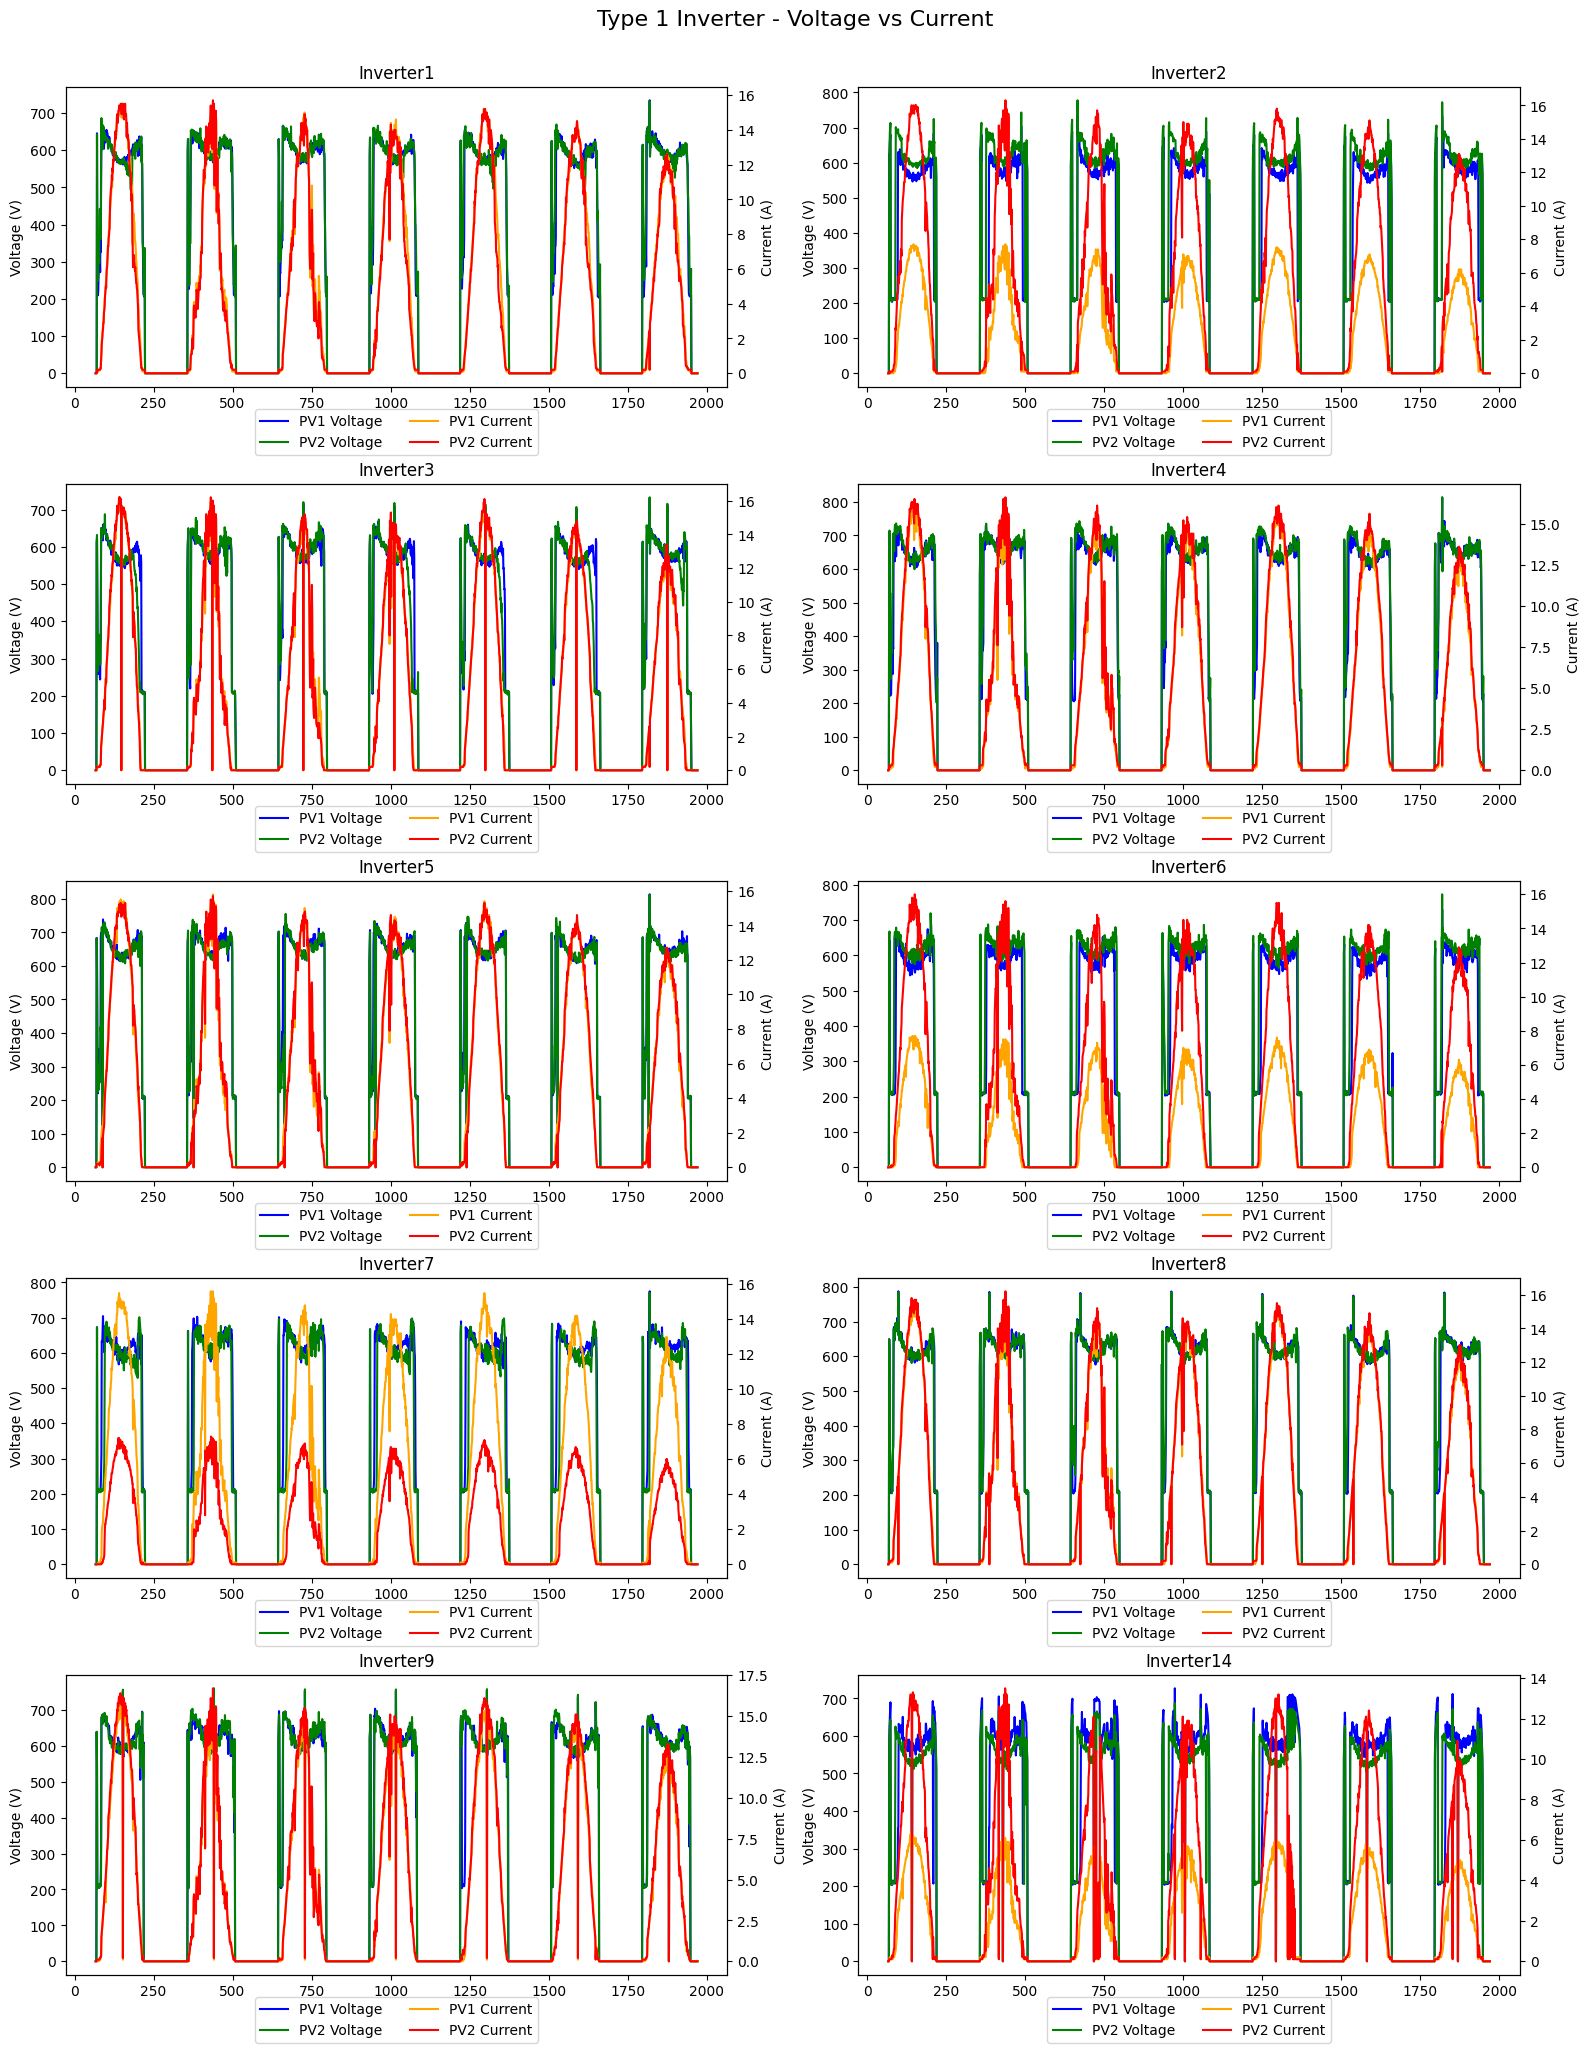

In [ ]:
plot_type1_inverters(updated_df, type1_inverters)

In [ ]:
import math

def plot_type2_inverters(df, type2_inverters, time_col='Time'):
    n = len(type2_inverters)
    nrows = math.ceil(n)  # One row per inverter
    fig, axs = plt.subplots(nrows, 2, figsize=(14, 5 * nrows))  # 2 plots per inverter

    if nrows == 1:
        axs = [axs]  # Make it iterable if only one inverter

    for i, inverter_num in enumerate(type2_inverters):
        inverter = f"Inverter{inverter_num}"

        # Columns for PV1
        pv1_voltage_col = f"{inverter}-pv1_voltage"
        pv1_current_col = f"{inverter}-pv1_current"

        # String current columns
        string_current_cols = [col for col in df.columns if col.startswith(inverter) and "string" in col.lower()]

        # Required columns
        cols_needed = [time_col, pv1_voltage_col, pv1_current_col] + string_current_cols
        plot_df = df[cols_needed].replace(65536, pd.NA).dropna()
        # Separate time and data columns
        time_series = df[[time_col]]
        data_series = df[[col for col in cols_needed if col != time_col]]

        # Ensure data is numeric
        data_series = data_series.apply(pd.to_numeric, errors='coerce')

        # Mask values > 1000 (likely bad voltage readings)
        data_series = data_series.mask(data_series > 1000)

        # Combine time and data again
        plot_df = pd.concat([time_series, data_series], axis=1).dropna()

        #plot_df = df[cols_needed].apply(pd.to_numeric, errors='coerce')  # Ensure numeric
        #plot_df = plot_df.mask(plot_df > 1000).dropna()

        # Left plot: PV1 voltage and current
        ax_voltage = axs[i][0]
        ax_voltage.set_title(f"{inverter} - PV1 Voltage & Current")
        l1 = ax_voltage.plot(plot_df[time_col], plot_df[pv1_voltage_col], label='PV1 Voltage (V)', color='tab:blue')
        ax_voltage.set_xlabel('Time')
        ax_voltage.set_ylabel('Voltage (V)', color='tab:blue')
        ax_voltage.tick_params(axis='y', labelcolor='tab:blue')

        axv2 = ax_voltage.twinx()
        l2 = axv2.plot(plot_df[time_col], plot_df[pv1_current_col], label='PV1 Current (A)', color='tab:orange')
        axv2.set_ylabel('Current (A)', color='tab:orange')
        axv2.tick_params(axis='y', labelcolor='tab:orange')

        lines = l1 + l2
        labels = [line.get_label() for line in lines]
        ax_voltage.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2, fontsize='small')

        # Right plot: String currents
        ax_current = axs[i][1]
        ax_current.set_title(f"{inverter} - String Currents")
        for col in string_current_cols:
            ax_current.plot(plot_df[time_col], plot_df[col], label=col)
        ax_current.set_xlabel('Time')
        ax_current.set_ylabel('Current (A)')
        ax_current.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3, fontsize='x-small')

    plt.tight_layout(rect=[0, 0.05, 1, 1])  # space at bottom for legends
    plt.show()

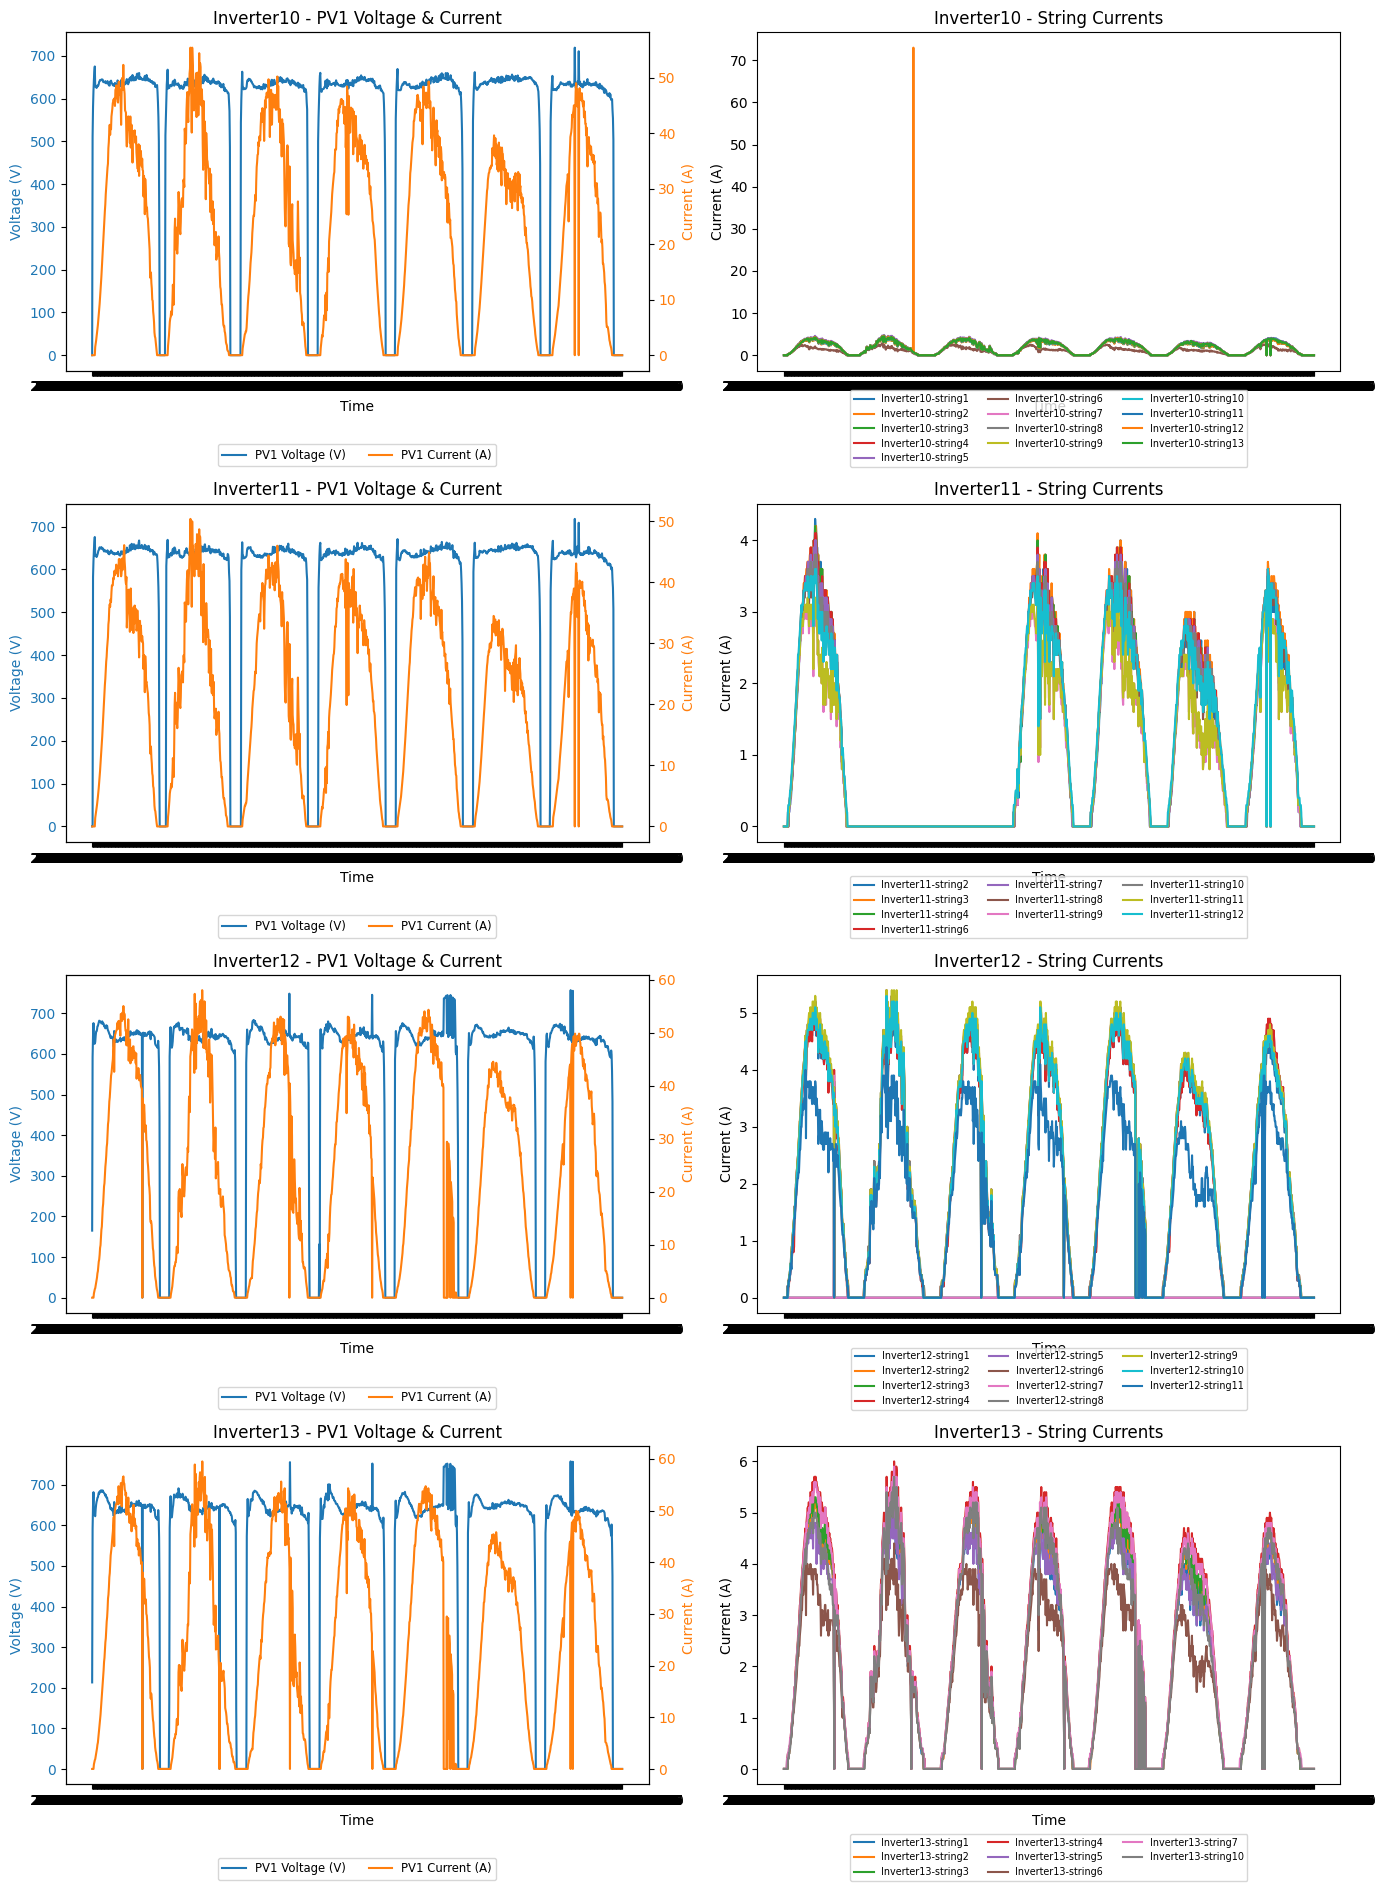

In [ ]:
plot_type2_inverters(updated_df, type2_inverters, time_col='Time')

In [ ]:
def analyze_type1_weekly_issues(df, inverter_name, zero_thresh=0.1, imbalance_pct=0.10):
    """
    More nuanced analysis of a Type 1 inverter’s weekly PV1/PV2 currents & voltages.
    Uses medians, percentiles, and zero‐count fractions to catch edge‐cases that averages miss.

    Parameters:
      df (DataFrame): wide‐format, indexed by timestamp (DatetimeIndex), with columns:
                      '{inverter_name}-pv1_current', '{inverter_name}-pv2_current',
                      '{inverter_name}-pv1_voltage', '{inverter_name}-pv2_voltage'.
      inverter_name (str): e.g. "Inverter14"
      zero_thresh (float): anything ≤ this counts as “zero” (default 0.1 A for current, or 1 V for voltage)
      imbalance_pct (float): fraction threshold to detect PV1 vs PV2 median imbalance (default 10%)

    Returns:
      dict with:
        - median, pct10, pct90 for PV1/PV2 currents & voltages
        - zero‐fraction
        - lists of spike timestamps
        - imbalance flags/reasons
    """
    summary = {'inverter': inverter_name}

    # 1) Column names
    pv1_c = f"{inverter_name}-pv1_current"
    pv2_c = f"{inverter_name}-pv2_current"
    pv1_v = f"{inverter_name}-pv1_voltage"
    pv2_v = f"{inverter_name}-pv2_voltage"

    # 2) Slice out only those 4 series
    try:
        df_local = df[[pv1_c, pv2_c, pv1_v, pv2_v]].copy()
    except KeyError as e:
        print(f"[{inverter_name}] Missing columns: {e}")
        return None

    # 3) Compute statistics for currents and voltages
    stats = {}
    for kind in ['pv1_current', 'pv2_current', 'pv1_voltage', 'pv2_voltage']:
        col = f"{inverter_name}-{kind}"
        arr = df_local[col].values

        # Median & Percentiles
        m   = np.nanmedian(arr)
        pct10 = np.nanpercentile(arr, 10)
        pct90 = np.nanpercentile(arr, 90)

        # Fraction near‐zero
        zero_frac = np.isnan(arr).sum() / len(arr)  # if NaNs still exist
        # For currents: consider <= zero_thresh as zero. For voltages: <= (zero_thresh*10)
        if 'current' in kind:
            zero_frac = np.sum(arr <= zero_thresh) / len(arr)
        else:
            zero_frac = np.sum(arr <= (zero_thresh * 10)) / len(arr)

        stats[kind+'_med']   = m
        stats[kind+'_pct10'] = pct10
        stats[kind+'_pct90'] = pct90
        stats[kind+'_zero_frac'] = zero_frac

    # 4) Record stats into summary
    summary.update({
        'pv1_current_med':   stats['pv1_current_med'],
        'pv2_current_med':   stats['pv2_current_med'],
        'pv1_voltage_med':   stats['pv1_voltage_med'],
        'pv2_voltage_med':   stats['pv2_voltage_med'],
        'pv1_current_pct10': stats['pv1_current_pct10'],
        'pv2_current_pct10': stats['pv2_current_pct10'],
        'pv1_current_pct90': stats['pv1_current_pct90'],
        'pv2_current_pct90': stats['pv2_current_pct90'],
        'pv1_voltage_pct10': stats['pv1_voltage_pct10'],
        'pv2_voltage_pct10': stats['pv2_voltage_pct10'],
        'pv1_voltage_pct90': stats['pv1_voltage_pct90'],
        'pv2_voltage_pct90': stats['pv2_voltage_pct90'],
        'pv1_current_zero_frac': stats['pv1_current_zero_frac'],
        'pv2_current_zero_frac': stats['pv2_current_zero_frac'],
        'pv1_voltage_zero_frac': stats['pv1_voltage_zero_frac'],
        'pv2_voltage_zero_frac': stats['pv2_voltage_zero_frac'],
    })

    # 5) Flag “offline” if median ≈ 0 or >90% readings near zero
    summary['pv1_offline'] = (abs(stats['pv1_current_med']) <= zero_thresh) or (stats['pv1_current_zero_frac'] > 0.9)
    summary['pv2_offline'] = (abs(stats['pv2_current_med']) <= zero_thresh) or (stats['pv2_current_zero_frac'] > 0.9)

    # 6) Spike detection
    #   Define a “spike” as value > (pct90 + 2*IQR) while neighbors ≤ zero_thresh
    def find_spikes(series, pct90, col_zero_thresh):
        spikes = []
        arr = series.values
        iqr = np.nanpercentile(arr, 75) - np.nanpercentile(arr, 25)
        spike_thr = pct90 + 2 * iqr

        idxs = series.index
        for i in range(1, len(arr)-1):
            prev_v = arr[i-1]
            curr_v = arr[i]
            next_v = arr[i+1]
            if (prev_v <= col_zero_thresh and curr_v > spike_thr and next_v <= col_zero_thresh):
                spikes.append(idxs[i])
        return spikes

    # Build spike lists
    summary['pv1_current_spikes']  = find_spikes(df_local[pv1_c],  stats['pv1_current_pct90'],  zero_thresh)
    summary['pv2_current_spikes']  = find_spikes(df_local[pv2_c],  stats['pv2_current_pct90'],  zero_thresh)
    summary['pv1_voltage_spikes']  = find_spikes(df_local[pv1_v],  stats['pv1_voltage_pct90'], zero_thresh*10)
    summary['pv2_voltage_spikes']  = find_spikes(df_local[pv2_v],  stats['pv2_voltage_pct90'], zero_thresh*10)

    # 7) Imbalance detection using medians
    curr_med1 = stats['pv1_current_med']
    curr_med2 = stats['pv2_current_med']
    if max(abs(curr_med1), abs(curr_med2)) > 0:
        summary['current_imbalance'] = abs(curr_med1 - curr_med2) / max(abs(curr_med1), abs(curr_med2)) > imbalance_pct
    else:
        summary['current_imbalance'] = False

    volt_med1 = stats['pv1_voltage_med']
    volt_med2 = stats['pv2_voltage_med']
    if max(abs(volt_med1), abs(volt_med2)) > 0:
        summary['voltage_imbalance'] = abs(volt_med1 - volt_med2) / max(abs(volt_med1), abs(volt_med2)) > imbalance_pct
    else:
        summary['voltage_imbalance'] = False

    # 8) Build textual “imbalance_reason”
    reasons = []
    if summary['pv1_offline']:
        reasons.append("PV1 offline or zero")
    if summary['pv2_offline']:
        reasons.append("PV2 offline or zero")
    if summary['current_imbalance']:
        if curr_med1 < curr_med2:
            reasons.append("PV1 current < PV2 (soiling/shade/string issue on PV1)")
        else:
            reasons.append("PV2 current < PV1 (soiling/shade/string issue on PV2)")
    if summary['voltage_imbalance']:
        if volt_med1 < volt_med2:
            reasons.append("PV1 voltage < PV2 (possible string mismatch on PV1)")
        else:
            reasons.append("PV2 voltage < PV1 (possible string mismatch on PV2)")

    summary['imbalance_reason'] = "; ".join(reasons) if reasons else "None"

    return summary

In [ ]:
all_summaries = []
for inv in type1_inverters:
    try:
        summary = analyze_type1_weekly_issues(updated_df, f"Inverter{inv}",
                                              zero_thresh=1e-3,
                                              imbalance_pct=0.05)
        all_summaries.append(summary)
    except Exception as e:
        print(f"Error processing {inv}: {e}")

# 4) Turn the list of summaries into a DataFrame
import pandas as pd
summary_df = pd.DataFrame(all_summaries)

# 5) Inspect the results
display(summary_df)
summary_df.to_excel(f"summary.xlsx", index=False)
#files.download(f"summary.xlsx")

inverter  pv1_current_med  pv2_current_med  pv1_voltage_med  \
0   Inverter1             5.40             4.90           587.10   
1   Inverter2             2.70             5.30           571.40   
2   Inverter3             5.40             5.30           572.60   
3   Inverter4             5.40             5.60           644.65   
4   Inverter5             5.45             5.60           644.95   
5   Inverter6             2.65             5.05           574.25   
6   Inverter7             5.50             2.50           614.85   
7   Inverter8             5.30             5.10           615.10   
8   Inverter9             5.25             5.10           608.35   
9  Inverter14             2.00             3.80           579.00   

   pv2_voltage_med  pv1_current_pct10  pv2_current_pct10  pv1_current_pct90  \
0           586.70                0.0                0.0               13.8   
1           605.50                0.0                0.0                6.8   
2           572.30                0.0                0.0               14.0   
3           650.75                0.0                0.0               14.0   
4           641.40                0.0                0.0               13.7   
5           611.40                0.0                0.0                6.7   
6           589.60                0.0                0.0               13.7   
7           612.05                0.0                0.0               13.6   
8           605.50                0.0                0.0               13.8   
9           543.25                0.0                0.0                5.4   

   pv2_current_pct90  pv1_voltage_pct10  ...  pv2_voltage_zero_frac  \
0              13.67                0.0  ...               0.128433   
1              14.30                0.0  ...               0.142973   
2              14.37                0.0  ...               0.125202   
3              14.60                0.0  ...               0.130048   
4              13.80                0.0  ...               0.133279   
5              13.67                0.0  ...               0.128433   
6               6.30                0.0  ...               0.132472   
7              14.00                0.0  ...               0.129241   
8              14.50                0.0  ...               0.148627   
9              11.60                0.0  ...               0.152666   

   pv1_offline  pv2_offline                       pv1_current_spikes  \
0        False        False                                       []   
1        False        False                                       []   
2        False        False                                    [505]   
3        False        False                                       []   
4        False        False                              [509, 1946]   
5        False        False  [363, 367, 649, 1080, 1086, 1513, 1808]   
6        False        False                                       []   
7        False        False                                   [1951]   
8        False        False                                       []   
9        False        False                                       []   

                  pv2_current_spikes  pv1_voltage_spikes  pv2_voltage_spikes  \
0                                 []                  []                  []   
1                                 []                  []                  []   
2                 [1081, 1085, 1951]                  []                  []   
3                                 []                  []                  []   
4                                 []                  []                  []   
5  [358, 796, 938, 1083, 1085, 1223]                  []                  []   
6                                 []                  []                  []   
7                                 []                  []                  []   
8                                 []                  []                  []   
9          

In [ ]:
import numpy as np
import pandas as pd

def analyze_type2_weekly_issues(
    df: pd.DataFrame,
    inverter_name: str,
    zero_thresh: float = 0.1,
    low_current_pct: float = 0.10
) -> dict:
    """
    Detailed weekly analysis for a Type 2 inverter’s PV1 and multiple string currents.

    Parameters:
      df (DataFrame): time‐indexed (DatetimeIndex) wide‐format, with columns like:
                      '{inverter_name}-pv1_current',
                      '{inverter_name}-pv1_voltage',
                      '{inverter_name}-string1', '{inverter_name}-string2', … etc.
      inverter_name (str): e.g. "Inverter13"
      zero_thresh (float): anything ≤ this counts as “zero” (default 0.1 A)
      low_current_pct (float): fraction threshold to detect low‐performing strings
                               (default 10% below the best string median)

    Returns:
      dict with:
        - PV1 current/voltage: median, pct10, pct90, zero‐fraction, spike timestamps
        - For each string: median, pct10, pct90, zero‐fraction, spike timestamps
        - low_performing_strings: list of string‐column names whose median is > low_current_pct below max‐median
    """
    summary = {'inverter': inverter_name}

    # 1) Column names for PV1
    pv1_c = f"{inverter_name}-pv1_current"
    pv1_v = f"{inverter_name}-pv1_voltage"

    # 2) Identify all string‐current columns (e.g. "Inverter13-string1", "Inverter13-string2", …)
    string_cols = [
        col for col in df.columns
        if col.startswith(inverter_name) and "string" in col.lower()
    ]

    # 3) Slice out PV1 + all string currents + PV1 voltage
    needed = [pv1_c, pv1_v] + string_cols
    try:
        df_local = df[needed].copy()
    except KeyError as e:
        print(f"[{inverter_name}] Missing columns: {e}")
        return None

    # 4) Compute stats for PV1 current & PV1 voltage
    stats = {}
    for kind in ['pv1_current', 'pv1_voltage']:
        col = f"{inverter_name}-{kind}"
        arr = df_local[col].values

        # Median & Percentiles
        m = np.nanmedian(arr)
        pct10 = np.nanpercentile(arr, 10)
        pct90 = np.nanpercentile(arr, 90)

        # Zero‐fraction (for current: ≤ zero_thresh; for voltage: ≤ zero_thresh*10)
        if kind == 'pv1_current':
            zero_frac = np.sum(arr <= zero_thresh) / len(arr)
        else:
            zero_frac = np.sum(arr <= (zero_thresh * 10)) / len(arr)

        stats[f'{kind}_med'] = m
        stats[f'{kind}_pct10'] = pct10
        stats[f'{kind}_pct90'] = pct90
        stats[f'{kind}_zero_frac'] = zero_frac

    # 5) Compute stats for each string current
    for col in string_cols:
        arr = df_local[col].values

        m = np.nanmedian(arr)
        pct10 = np.nanpercentile(arr, 10)
        pct90 = np.nanpercentile(arr, 90)

        zero_frac = np.sum(arr <= zero_thresh) / len(arr)

        stats[f'{col}_med'] = m
        stats[f'{col}_pct10'] = pct10
        stats[f'{col}_pct90'] = pct90
        stats[f'{col}_zero_frac'] = zero_frac

    # 6) Record PV1 stats into summary
    summary.update({
        'pv1_current_med':    stats['pv1_current_med'],
        'pv1_current_pct10':  stats['pv1_current_pct10'],
        'pv1_current_pct90':  stats['pv1_current_pct90'],
        'pv1_current_zero_frac': stats['pv1_current_zero_frac'],
        'pv1_voltage_med':    stats['pv1_voltage_med'],
        'pv1_voltage_pct10':  stats['pv1_voltage_pct10'],
        'pv1_voltage_pct90':  stats['pv1_voltage_pct90'],
        'pv1_voltage_zero_frac': stats['pv1_voltage_zero_frac'],
    })

    # 7) Record each string’s stats into summary
    for col in string_cols:
        summary[f'{col}_med'] = stats[f'{col}_med']
        summary[f'{col}_pct10'] = stats[f'{col}_pct10']
        summary[f'{col}_pct90'] = stats[f'{col}_pct90']
        summary[f'{col}_zero_frac'] = stats[f'{col}_zero_frac']

    # 8) Identify low‐performing strings (median > low_current_pct below the max‐median)
    string_meds = {col: stats[f'{col}_med'] for col in string_cols}
    if string_meds:
        max_med = max(string_meds.values())
        low_strings = []
        for col, m in string_meds.items():
            if max_med > 0 and (max_med - m) / max_med > low_current_pct:
                low_strings.append(col)
    else:
        low_strings = []

    summary['low_performing_strings'] = low_strings

    # 9) Spike detection helper (same logic as Type 1)
    def find_spikes(series: pd.Series, pct90: float, col_zero_thresh: float):
        spikes = []
        arr = series.values
        iqr = np.nanpercentile(arr, 75) - np.nanpercentile(arr, 25)
        spike_thr = pct90 + 2 * iqr

        idxs = series.index
        for i in range(1, len(arr) - 1):
            prev_v = arr[i - 1]
            curr_v = arr[i]
            next_v = arr[i + 1]
            if (prev_v <= col_zero_thresh and curr_v > spike_thr and next_v <= col_zero_thresh):
                spikes.append(idxs[i])
        return spikes

    # 10) Build spike lists for PV1 current & voltage
    summary['pv1_current_spikes'] = find_spikes(
        df_local[pv1_c],
        stats['pv1_current_pct90'],
        zero_thresh
    )
    summary['pv1_voltage_spikes'] = find_spikes(
        df_local[pv1_v],
        stats['pv1_voltage_pct90'],
        zero_thresh * 10
    )

    # 11) Build spike lists for each string
    for col in string_cols:
        pct90 = stats[f'{col}_pct90']
        summary[f'{col}_spikes'] = find_spikes(
            df_local[col],
            pct90,
            zero_thresh
        )

    return summary

In [ ]:
all_type2_summaries = []
for inv in type2_inverters:
    try:
        summary = analyze_type2_weekly_issues(
            updated_df,
            f"Inverter{inv}",
            zero_thresh=1e-3,
            low_current_pct=0.05  # e.g. flag any string >5% below the best string
        )
        all_type2_summaries.append(summary)
    except Exception as e:
        print(f"Error processing Inverter{inv}: {e}")

# Turn the list of dicts into a DataFrame
import pandas as pd
type2_summary_df = pd.DataFrame(all_type2_summaries)

# Inspect or save
display(type2_summary_df)
type2_summary_df.to_excel("type2_summary.xlsx", index=False)
#files.download(f"type2_summary.xlsx")

inverter  pv1_current_med  pv1_current_pct10  pv1_current_pct90  \
0  Inverter10             25.2                0.0              45.40   
1  Inverter11             21.8                0.0              40.32   
2  Inverter12             22.7                0.0              49.00   
3  Inverter13             22.7                0.0              49.87   

   pv1_current_zero_frac  pv1_voltage_med  pv1_voltage_pct10  \
0               0.178514           633.10                0.0   
1               0.183360           638.10                0.0   
2               0.181745           641.15                0.0   
3               0.180129           641.20                0.0   

   pv1_voltage_pct90  pv1_voltage_zero_frac  Inverter10-string1_med  ...  \
0             646.52               0.118740                     1.9  ...   
1             651.80               0.126010                     NaN  ...   
2             665.40               0.126817                     NaN  ...   
3             669.67               0.126817                     NaN  ...   

   Inverter13-string10_pct90  Inverter13-string10_zero_frac  \
0                        NaN                            NaN   
1                        NaN                            NaN   
2                        NaN                            NaN   
3                        4.6                       0.264136   

   Inverter13-string1_spikes  Inverter13-string2_spikes  \
0                        NaN                        NaN   
1                        NaN                        NaN   
2                        NaN                        NaN   
3                         []                         []   

   Inverter13-string3_spikes  Inverter13-string4_spikes  \
0                        NaN                        NaN   
1                        NaN                        NaN   
2                        NaN                        NaN   
3                         []                         []   

   Inverter13-string5_spikes  Inverter13-string6_spikes  \
0                        NaN                        NaN   
1                        NaN                        NaN   
2                        NaN                        NaN   
3                         []                         []   

   Inverter13-string7_spikes  Inverter13-string10_spikes  
0                        NaN                         NaN  
1                        NaN                         NaN  
2                        NaN                         NaN  
3                         []                          []  

[4 rows x 222 columns]

# **LONG TERM DATA 2025(NER)**

In [ ]:
# Path to your Google Drive folder with weekly Excel files (this data is acquired using)
ner_2025_data_path = '/content/drive/MyDrive/FPE Data/2025 data'

# List to store cleaned weekly DataFrames
all_weeks_data = []

for fname in sorted(os.listdir(ner_2025_data_path)):
    if not fname.lower().endswith((".xls", ".xlsx")):
        continue

    path = os.path.join(ner_2025_data_path, fname)
    df_raw = pd.read_excel(path)

    # Step 1: Clean and summarize
    df_week, _ = clean_and_summarize_dataframe(df_raw)

    # Step 2: Normalize column names
    df_norm = normalize_inverter_column_names(df_week)

    # Step 3: Append to master list
    all_weeks_data.append(df_norm)

# Step 4: Combine all weeks into one DataFrame
df_full = pd.concat(all_weeks_data, ignore_index=True)

# Step 5: Ensure 'Time' is datetime and sort
df_full['Time'] = pd.to_datetime(df_full['Time'], errors='coerce')
df_full = df_full.dropna(subset=['Time'])  # Drop rows where Time couldn't be parsed
df_full = df_full.sort_values('Time')

# Step 6: Save to Excel
output_path = '/content/drive/MyDrive/FPE Data/Combined_Full_Inverter_Data.xlsx'
df_full.to_excel(output_path, index=False)

print(f"Combined data saved to: {output_path}")

Combined data saved to: /content/drive/MyDrive/FPE Data/Combined_Full_Inverter_Data.xlsx


In [ ]:
file_path = '/content/drive/MyDrive/FPE Data/Combined_Full_Inverter_Data.xlsx'
df_full = pd.read_excel(file_path)

In [ ]:
from collections import Counter

def split_inverters_by_type(df):
    """
    Groups inverters into Type 1 (pv1/pv2), Type 2 (string), and Hybrid (both).
    """
    inverter_column_map = group_inverter_columns(df)

    from collections import Counter
    type_counts = Counter(info["type"] for info in inverter_column_map.values())
    print(f"\n🔎 Inverter Type Counts: {dict(type_counts)}\n")

    type1_inverters = [inv for inv, info in inverter_column_map.items() if info["type"] == "type1"]
    type2_inverters = [inv for inv, info in inverter_column_map.items() if info["type"] == "type2"]
    hybrid_inverters = [inv for inv, info in inverter_column_map.items() if info["type"] == "hybrid"]

    print(f"⚙️ Type 1 Inverters: {len(type1_inverters)}")
    print(f"⚙️ Type 2 Inverters: {len(type2_inverters)}")
    print(f"⚙️ Hybrid Inverters: {len(hybrid_inverters)}")

    return type1_inverters, type2_inverters, hybrid_inverters
df_full.columns = df_full.columns.astype(str)
type1_inverters_full, type2_inverters_full,hybrid_inverters=split_inverters_by_type(df_full)


🔎 Inverter Type Counts: {'type1': 10, 'type2': 4}

⚙️ Type 1 Inverters: 10
⚙️ Type 2 Inverters: 4
⚙️ Hybrid Inverters: 0


In [ ]:
# Ensure all column names are strings to avoid .startswith() errors
df_full.columns = df_full.columns.map(str)

type1_cols = ['Time']
for inv in type1_inverters_full:
    prefix = f"{inv}-"
    type1_cols.extend([col for col in df_full.columns if col.startswith(prefix)])

type1_df = df_full[type1_cols]

type2_cols = ['Time']
for inv in type2_inverters_full:
    prefix = f"{inv}-"
    type2_cols.extend([col for col in df_full.columns if col.startswith(prefix)])

type2_df = df_full[type2_cols]

#type1_df.to_excel('/content/drive/MyDrive/FPE Data/Type1_Full_Inverter_Data.xlsx', index=False)
#type2_df.to_excel('/content/drive/MyDrive/FPE Data/Type2_Full_Inverter_Data.xlsx', index=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_daily_voltage_type1(df):
    """
    Plots daily average PV1 and PV2 voltage for each Type 1 inverter in a grid layout.
    Automatically removes invalid values >= 65536.

    Parameters:
        df (DataFrame): Cleaned Type 1 inverter data with 'Time' column as datetime.
    """

    # Ensure Time is datetime
    df = df.copy()
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    df = df.dropna(subset=['Time']).sort_values('Time')

    # Replace absurdly large values with NaN, only for numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].mask(df[numeric_cols] >= 65536)

    # Extract unique Type 1 inverter names
    inverter_names = sorted(set(col.split('-')[0] for col in df.columns if '-pv1_voltage' in col))

    # Grid layout
    n_inv = len(inverter_names)
    n_cols = int(np.ceil(np.sqrt(n_inv)))
    n_rows = int(np.ceil(n_inv / n_cols))
    print(f"Plotting {n_inv} Type 1 inverters in {n_rows} rows and {n_cols} columns.\n")

    if n_inv == 1:
        fig, ax = plt.subplots(figsize=(7, 5))
        axs = [ax]
    else:
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=False)
        if isinstance(axs, np.ndarray):
            axs = axs.flatten()
        else:
            axs = [axs]


    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=False)

    # Normalize axs to always be a flat list
    axs = np.array(axs).reshape(-1)


    for idx, inv in enumerate(inverter_names):
        pv1_col = f"{inv}-pv1_voltage"
        pv2_col = f"{inv}-pv2_voltage"

        if pv1_col not in df.columns or pv2_col not in df.columns:
            continue

        sub_df = df[['Time', pv1_col, pv2_col]].copy()
        sub_df['Date'] = sub_df['Time'].dt.date

        daily_avg = sub_df.groupby('Date')[[pv1_col, pv2_col]].mean().reset_index()

        ax = axs[idx]
        ax.plot(daily_avg['Date'], daily_avg[pv1_col], label='PV1 Voltage', color='blue')
        ax.plot(daily_avg['Date'], daily_avg[pv2_col], label='PV2 Voltage', color='green')
        ax.set_title(inv)
        ax.set_xlabel('Date')
        ax.set_ylabel('Voltage (V)')
        ax.grid(True)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(fontsize='small')

    # Hide unused axes
    for j in range(n_inv, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.suptitle('Daily Average PV1 & PV2 Voltages - Type 1 Inverters', fontsize=16, y=1.02)
    plt.show()

Plotting 10 Type 1 inverters in 3 rows and 4 columns.



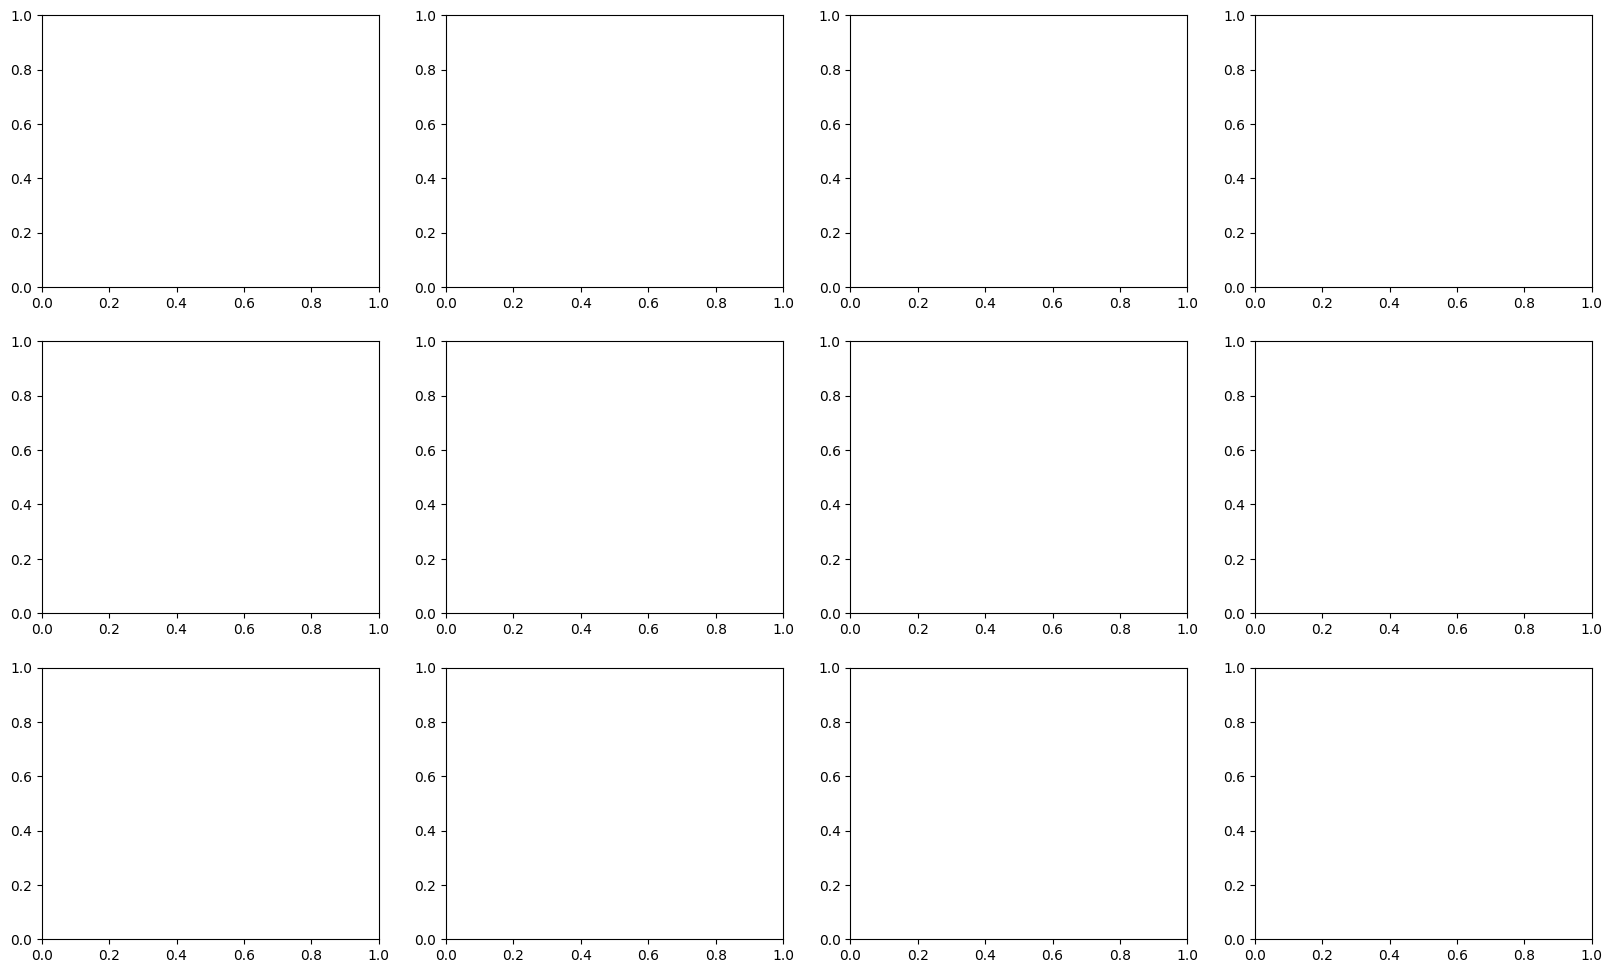

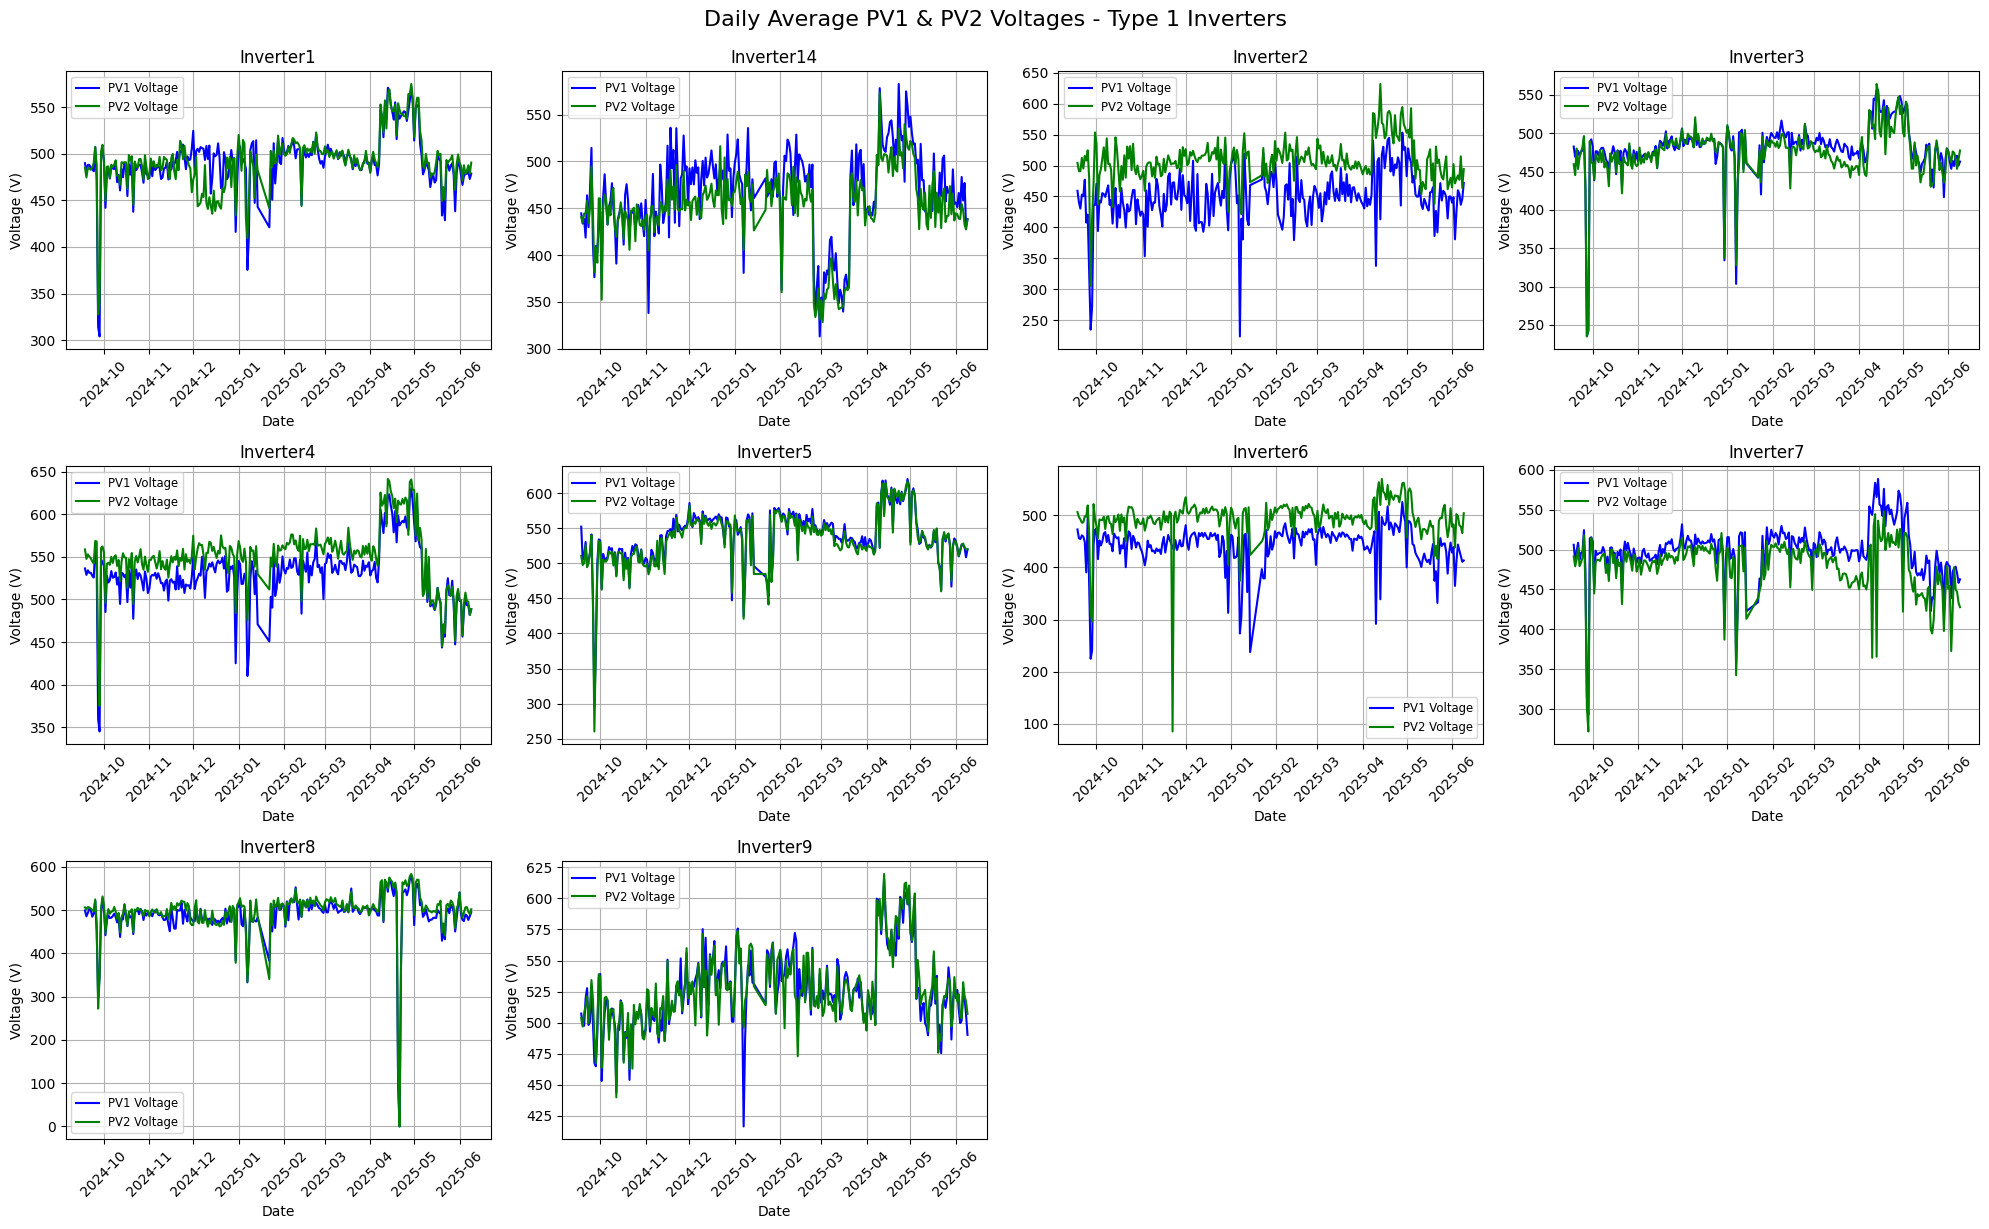

In [ ]:
plot_daily_voltage_type1(type1_df)

In [ ]:
def type1_inverter_mismatch_and_drop_analysis(df, type1_inverters, drop_threshold_v=0.2, drop_threshold_c=0.15, window_size=7):
    """
    Computes mismatch %, sudden voltage drops, and sudden current drops for Type 1 inverters.

    Parameters:
        df (DataFrame): Full cleaned dataset with Time column in datetime format.
        type1_inverters (list): List of Type 1 inverter names, e.g., ['Inverter1', 'Inverter2', ...]
        drop_threshold_v (float): Fractional threshold for voltage sudden drop detection (default 20%).
        drop_threshold_c (float): Fractional threshold for current sudden drop detection (default 15%).
        window_size (int): Rolling window size (in data points) for baseline computation (default 7 for ~35min on 5min data).

    Returns:
        summary_df (DataFrame): Summary of mismatch stats and sudden drops for each Type 1 inverter.
    """
    results = []

    for inv in type1_inverters:

        # Column names
        pv1_v = f"{inv}-pv1_voltage"
        pv2_v = f"{inv}-pv2_voltage"
        pv1_c = f"{inv}-pv1_current"
        pv2_c = f"{inv}-pv2_current"

        # Filter relevant columns
        sub_df = df[['Time', pv1_v, pv2_v, pv1_c, pv2_c]].copy()

        # Filter for daytime hours
        sub_df['Hour'] = sub_df['Time'].dt.hour
        day_df = sub_df[(sub_df['Hour'] >= 7) & (sub_df['Hour'] <= 17)].copy()

        ### VOLTAGE ANALYSIS ###
        max_voltage = day_df[[pv1_v, pv2_v]].max(axis=1)
        valid_mask_v = max_voltage > 0

        # Mismatch %
        day_df.loc[valid_mask_v, 'Mismatch_%_V'] = abs(day_df.loc[valid_mask_v, pv1_v] - day_df.loc[valid_mask_v, pv2_v]) / max_voltage[valid_mask_v] * 100
        mean_mismatch_v = day_df['Mismatch_%_V'].mean()
        std_mismatch_v = day_df['Mismatch_%_V'].std()
        mismatch_10_pct_v = (day_df['Mismatch_%_V'] > 10).mean() * 100

        # Rolling median for sudden drops
        day_df['Rolling_Median_V'] = day_df[pv1_v].rolling(window=window_size, center=True, min_periods=3).median()
        sudden_drops_pv1_v = (day_df[pv1_v] < day_df['Rolling_Median_V'] * (1 - drop_threshold_v)).sum()

        day_df['Rolling_Median_V2'] = day_df[pv2_v].rolling(window=window_size, center=True, min_periods=3).median()
        sudden_drops_pv2_v = (day_df[pv2_v] < day_df['Rolling_Median_V2'] * (1 - drop_threshold_v)).sum()

        # Daily average drops
        day_df['Date'] = day_df['Time'].dt.date
        daily_avg_v = day_df.groupby('Date')[[pv1_v, pv2_v]].mean().reset_index()
        max_daily_v = daily_avg_v[[pv1_v, pv2_v]].max(axis=1)

        daily_mismatch_pct_v = abs(daily_avg_v[pv1_v] - daily_avg_v[pv2_v]) / max_daily_v * 100
        daily_drop_pv1_v = (daily_mismatch_pct_v > 10).sum()
        daily_drop_pv2_v = (daily_mismatch_pct_v > 10).sum()

        ### CURRENT ANALYSIS ###
        max_current = day_df[[pv1_c, pv2_c]].max(axis=1)
        valid_mask_c = max_current > 0

        day_df.loc[valid_mask_c, 'Mismatch_%_C'] = abs(day_df.loc[valid_mask_c, pv1_c] - day_df.loc[valid_mask_c, pv2_c]) / max_current[valid_mask_c] * 100
        mean_mismatch_c = day_df['Mismatch_%_C'].mean()
        std_mismatch_c = day_df['Mismatch_%_C'].std()
        mismatch_10_pct_c = (day_df['Mismatch_%_C'] > 10).mean() * 100

        day_df['Rolling_Median_C'] = day_df[pv1_c].rolling(window=window_size, center=True, min_periods=3).median()
        sudden_drops_pv1_c = (day_df[pv1_c] < day_df['Rolling_Median_C'] * (1 - drop_threshold_c)).sum()

        day_df['Rolling_Median_C2'] = day_df[pv2_c].rolling(window=window_size, center=True, min_periods=3).median()
        sudden_drops_pv2_c = (day_df[pv2_c] < day_df['Rolling_Median_C2'] * (1 - drop_threshold_c)).sum()

        daily_avg_c = day_df.groupby('Date')[[pv1_c, pv2_c]].mean().reset_index()
        max_daily_c = daily_avg_c[[pv1_c, pv2_c]].max(axis=1)

        daily_mismatch_pct_c = abs(daily_avg_c[pv1_c] - daily_avg_c[pv2_c]) / max_daily_c * 100
        daily_drop_pv1_c = (daily_mismatch_pct_c > 10).sum()
        daily_drop_pv2_c = (daily_mismatch_pct_c > 10).sum()

        ### STORE RESULTS ###
        results.append({
            'Inverter': inv,
            'Mean Mismatch % (V)': round(mean_mismatch_v, 2),
            'Mismatch Std Dev % (V)': round(std_mismatch_v, 2),
            '% of Mismatch > 10% (V)': round(mismatch_10_pct_v, 2),
            'Sudden Drops PV1 (V)': sudden_drops_pv1_v,
            'Sudden Drops PV2 (V)': sudden_drops_pv2_v,
            'Daily Mean Drops PV1 (>10%) (V)': daily_drop_pv1_v,
            'Daily Mean Drops PV2 (>10%) (V)': daily_drop_pv2_v,
            'Mean Mismatch % (C)': round(mean_mismatch_c, 2),
            'Mismatch Std Dev % (C)': round(std_mismatch_c, 2),
            '% of Mismatch > 10% (C)': round(mismatch_10_pct_c, 2),
            'Sudden Drops PV1 (C)': sudden_drops_pv1_c,
            'Sudden Drops PV2 (C)': sudden_drops_pv2_c,
            'Daily Mean Drops PV1 (>10%) (C)': daily_drop_pv1_c,
            'Daily Mean Drops PV2 (>10%) (C)': daily_drop_pv2_c,
        })

    summary_df = pd.DataFrame(results)
    return summary_df

In [ ]:
type1_summary_df = type1_inverter_mismatch_and_drop_analysis(df_full, type1_inverters_full)
display(type1_summary_df)

Inverter  Mean Mismatch % (V)  Mismatch Std Dev % (V)  \
0   Inverter1                 5.03                    8.78   
1   Inverter2                11.04                   19.93   
2   Inverter3                 4.60                   10.03   
3   Inverter4                 5.07                   10.63   
4   Inverter5                 3.01                    5.92   
5   Inverter6                11.60                   61.76   
6   Inverter7                 6.26                   13.69   
7   Inverter8                 4.11                    9.87   
8   Inverter9                 2.76                    7.19   
9  Inverter14                10.15                   14.75   

   % of Mismatch > 10% (V)  Sudden Drops PV1 (V)  Sudden Drops PV2 (V)  \
0                    11.47                   246                   232   
1                    14.51                   250                   341   
2                     9.26                   263                   224   
3                     9.07                   200                   285   
4                     3.79                   242                   224   
5                    15.02                    98                   195   
6                     9.51                   219                   106   
7                     5.90                   244                   275   
8                     3.60                   352                   368   
9                    19.33                   417                   642   

   Daily Mean Drops PV1 (>10%) (V)  Daily Mean Drops PV2 (>10%) (V)  \
0                               15                               15   
1                              144                              144   
2                                0                                0   
3                                6                                6   
4                                1                                1   
5                              142                              142   
6                                7                                7   
7                                1                                1   
8                                1                                1   
9                                5                                5   

   Mean Mismatch % (C)  Mismatch Std Dev % (C)  % of Mismatch > 10% (C)  \
0                15.02                   15.45                    48.00   
1                57.84                   16.96                    94.73   
2                 9.19                   16.68                    16.98   
3                15.32                   17.19                    38.38   
4                 8.02                   12.76                    17.25   
5                55.28                   19.28                    89.91   
6                32.00                   32.30                    52.30   
7                 8.43                   16.48                    13.16   
8                 7.66                   14.06                    14.56   
9                47.52                   16.66                    85.96   

   Sudden Drops PV1 (C)  Sudden Drops PV2 (C)  \
0                  2142                  1955   
1                  2185                  2628   
2                  2098                  1967   
3                  2184                  2072   
4                  2090                  1983   
5                  2330                  2234   
6                  2208                  1761   
7                  2082                  2028   
8                  2352                  2593   
9                  2974                  2536   

   Daily Mean Drops PV1 (>10%) (C)  Daily Mean Drops PV2 (>10%) (C)  
0                              104                              104  
1                              258                              258  
2                               85                               85  
3                              104                              104  
4        

In [ ]:
def check_and_filter_outliers(df, columns, min_val, max_val, param_name="Value"):
    """
    Prints and filters outliers in specified columns based on given min/max values.
    Replaces outliers with NaN and shows summary.
    """
    total_high = 0
    total_low = 0

    print(f"\n🔍 Outlier check for: {param_name}")
    for col in columns:
        over = df[df[col] > max_val]
        under = df[df[col] < min_val]

        count_high = len(over)
        count_low = len(under)
        total_high += count_high
        total_low += count_low

        if count_high > 0 or count_low > 0:
            print(f"\nColumn: {col}")
            if count_high > 0:
                print(f"  ⚠️ {count_high} values > {max_val}")
                display(over[['Time', col]])
            if count_low > 0:
                print(f"  ⚠️ {count_low} values < {min_val}")
                display(under[['Time', col]])

        # Replace outliers with NaN
        df.loc[(df[col] > max_val) | (df[col] < min_val), col] = np.nan

    print(f"\n📊 Total outliers > {max_val}: {total_high}")
    print(f"📊 Total outliers < {min_val}: {total_low}")
    return df

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_inverter_voltage_current_summary(df_full, summary_df, voltage_limit=1000):
    """
    Generates cleaner subplots for inverter voltage, current mismatch, and drop events.
    Handles large number of inverters better with readable layouts.
    """

    df = df_full.copy()
    df['Hour'] = df['Time'].dt.hour
    day = df[(df['Hour'] >= 7) & (df['Hour'] <= 17)].copy()

    # Voltage columns
    volt_cols = [c for c in day.columns if c.endswith('-pv1_voltage') or c.endswith('-pv2_voltage')]

    # ✅ Step 1: Print voltage outliers before filtering
    min_voltage = 0
    max_voltage = 1000

    print("⚠️ Voltage Outliers:")
    total_high, total_low = 0, 0

    for col in volt_cols:
      over_max = day[day[col] > max_voltage]
      under_min = day[day[col] < min_voltage]

      count_high = len(over_max)
      count_low = len(under_min)
      total_high += count_high
      total_low += count_low

      if count_high > 0 or count_low > 0:
          print(f"\n🔍 Column: {col}")
          if count_high > 0:
              print(f"  ⚠️ {count_high} values > {max_voltage} V")
              display(over_max[['Time', col]])
          if count_low > 0:
              print(f"  ⚠️ {count_low} values < {min_voltage} V")
              display(under_min[['Time', col]])

    print(f"\n📊 Total values > {max_voltage} V across all inverters: {total_high}")
    print(f"📊 Total values < {min_voltage} V across all inverters: {total_low}")

    # ✅ Step 2: Apply voltage filtering (set outliers to NaN)
    for col in volt_cols:
        day.loc[(day[col] > max_voltage) | (day[col] < min_voltage), col] = np.nan


    volt_long = (
        day.melt(id_vars=['Time'], value_vars=volt_cols, var_name='Series', value_name='Voltage')
        .dropna(subset=['Voltage'])
    )
    volt_long['Inverter'] = volt_long['Series'].str.extract(r'^(Inverter\d+)')

    # Current mismatch
    curr1 = [c for c in day.columns if c.endswith('_pv1_current')]
    curr2 = [c for c in day.columns if c.endswith('_pv2_current')]
    mismatch_list = []
    for inv in summary_df['Inverter']:
        c1 = f"{inv}-pv1_current"
        c2 = f"{inv}-pv2_current"

        if c1 not in day.columns or c2 not in day.columns:
            continue

        tmp = day[['Time', c1, c2]].copy().dropna()
        tmp['Date'] = tmp['Time'].dt.date
        grp = tmp.groupby('Date')[[c1, c2]].mean().reset_index()
        grp['MismatchPct'] = (grp[c1] - grp[c2]).abs() / grp[[c1, c2]].max(axis=1) * 100
        grp['Inverter'] = inv
        mismatch_list.append(grp[['Date', 'Inverter', 'MismatchPct']])

    mismatch_df = pd.concat(mismatch_list, ignore_index=True)

    # Drop counts
    summary_df['Drops_V_Total'] = summary_df['Sudden Drops PV1 (V)'] + summary_df['Sudden Drops PV2 (V)']
    summary_df['Drops_C_Total'] = summary_df['Sudden Drops PV1 (C)'] + summary_df['Sudden Drops PV2 (C)']

    # Plotting
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=False, sharey=False)

    # Voltage Boxplot
    sns.boxplot(x='Inverter', y='Voltage', hue='Inverter', data=volt_long, ax=axes[0, 0], palette='Set3', legend=False)
    axes[0, 0].set_title("Daytime Voltage Distribution per Inverter", fontsize=12)
    axes[0, 0].set_xlabel("")
    axes[0, 0].set_ylabel("Voltage [V]")
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Current Mismatch Boxplot
    sns.boxplot(x='Inverter', y='MismatchPct', hue='Inverter', data=mismatch_df, ax=axes[0, 1], palette='Set2', legend=False)
    axes[0, 1].set_title("Daily Mean Current Mismatch % per Inverter", fontsize=12)
    axes[0, 1].set_xlabel("")
    axes[0, 1].set_ylabel("Mismatch %")
    axes[0, 1].tick_params(axis='x', rotation=45)

    # Sudden Voltage Drops Barplot
    sns.barplot(x='Inverter', y='Drops_V_Total', hue='Inverter', data=summary_df, ax=axes[1, 0], palette='Blues_d', dodge=False, legend=False)
    axes[1, 0].set_title("Total Sudden Voltage Drops per Inverter", fontsize=12)
    axes[1, 0].set_xlabel("")
    axes[1, 0].set_ylabel("Count of Drops")
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Sudden Current Drops Barplot
    sns.barplot(x='Inverter', y='Drops_C_Total', hue='Inverter', data=summary_df, ax=axes[1, 1], palette='Oranges_d', dodge=False, legend=False)
    axes[1, 1].set_title("Total Sudden Current Drops per Inverter", fontsize=12)
    axes[1, 1].set_xlabel("")
    axes[1, 1].set_ylabel("Count of Drops")
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

⚠️ Voltage Outliers:

🔍 Column: Inverter6-pv2_voltage
  ⚠️ 1 values < 0 V


Time  Inverter6-pv2_voltage
10827 2024-11-22 16:15:00               -64851.0


🔍 Column: Inverter14-pv1_voltage
  ⚠️ 1 values > 1000 V


Time  Inverter14-pv1_voltage
37939 2025-05-03 12:30:00            1.065353e+09


📊 Total values > 1000 V across all inverters: 1
📊 Total values < 0 V across all inverters: 1


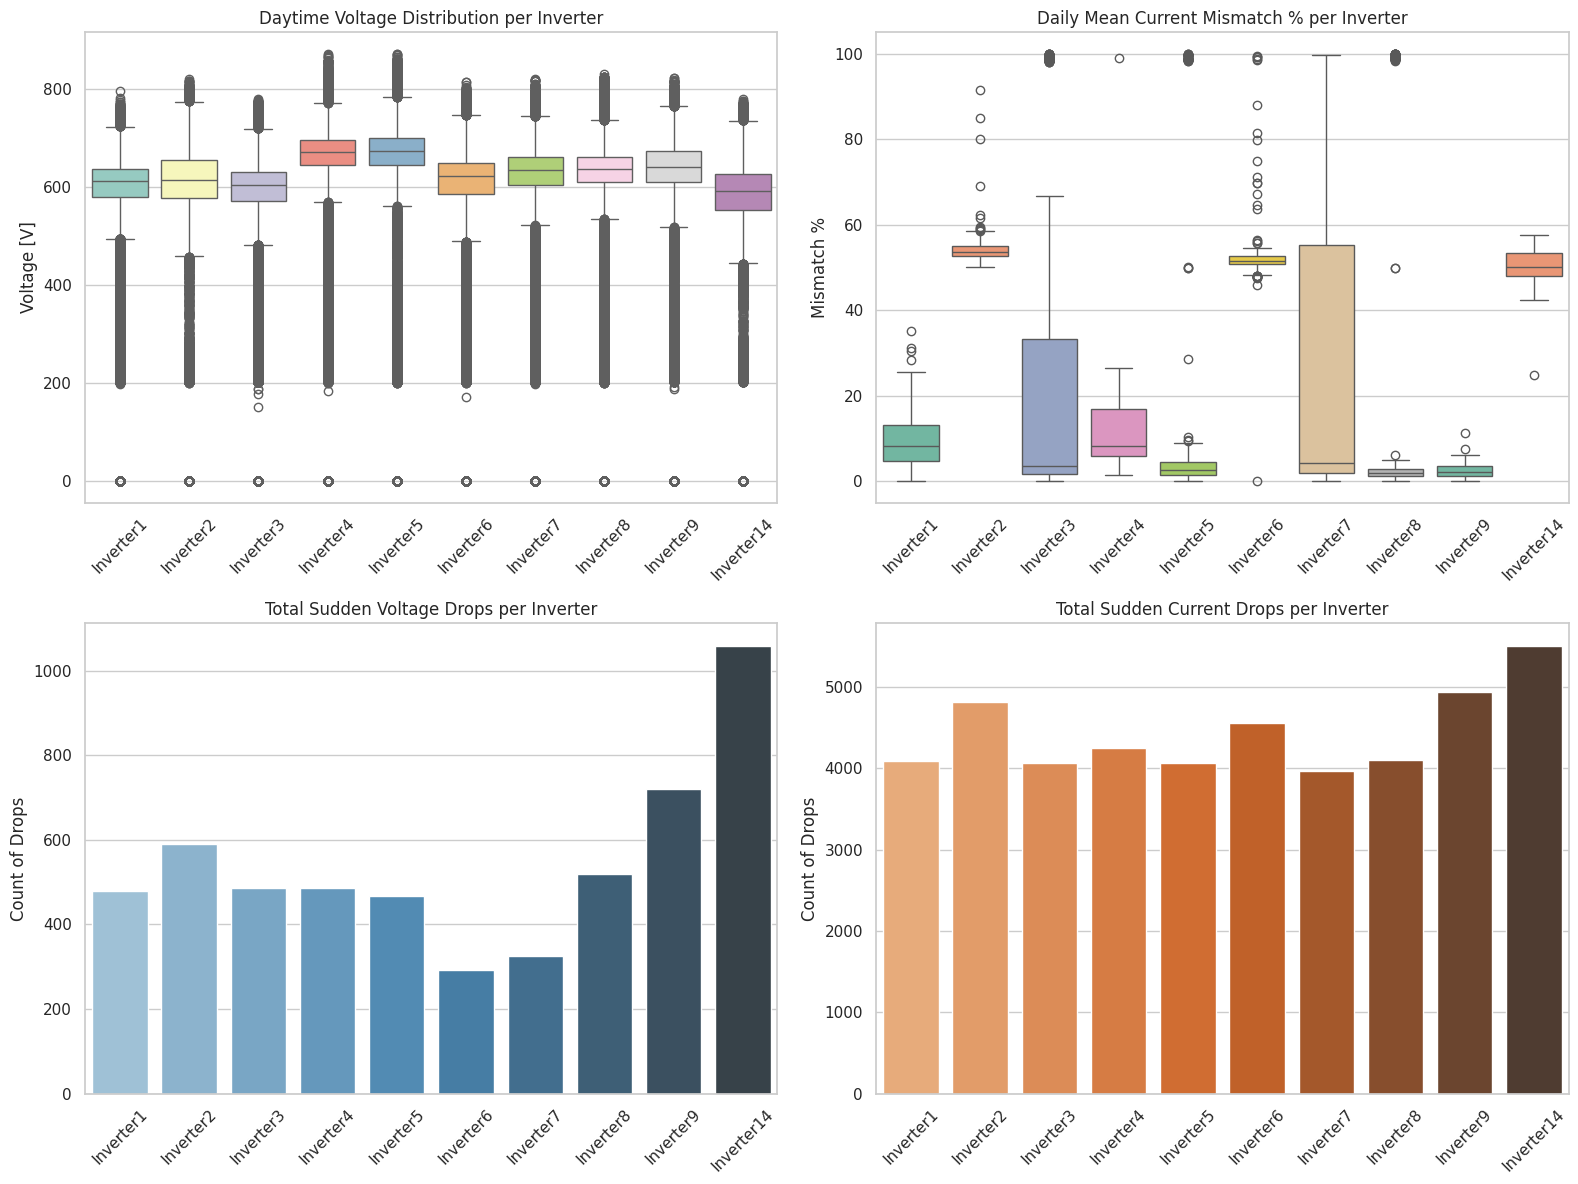

In [ ]:
plot_inverter_voltage_current_summary(type1_df, type1_summary_df)

In [ ]:
import warnings

def plot_type2_string_summary(df, inverter_list, voltage_limit=1000, return_outliers=False):
    """
    Plots boxplots and barplots for PV1 voltage and string currents for Type 2 inverters.
    Outliers are removed using the IQR method to make plots more interpretable.
    """

    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np

    warnings.filterwarnings("ignore")

    df = df.copy()
    df['Hour'] = df['Time'].dt.hour
    day = df[(df['Hour'] >= 7) & (df['Hour'] <= 17)].copy()

    outlier_records = []

    n_inv = len(inverter_list)
    fig, axes = plt.subplots(n_inv, 3, figsize=(18, 4 * n_inv), sharex=False)

    if n_inv == 1:
        axes = np.expand_dims(axes, axis=0)

    for row_idx, inv in enumerate(inverter_list):
        pv1_col = f"{inv}-pv1_voltage"
        string_cols = [c for c in day.columns if c.startswith(inv) and "string" in c.lower()]

        if pv1_col not in day.columns or not string_cols:
            continue

        # --- Handle Voltage Outliers ---
        sub_df = day[['Time', pv1_col]].copy()
        sub_df['Date'] = sub_df['Time'].dt.date
        sub_df['Voltage'] = sub_df[pv1_col]
        sub_df = sub_df[sub_df['Voltage'] < voltage_limit]

        # Remove voltage outliers using IQR
        Q1 = sub_df['Voltage'].quantile(0.25)
        Q3 = sub_df['Voltage'].quantile(0.75)
        IQR = Q3 - Q1
        voltage_mask = (sub_df['Voltage'] >= Q1 - 1.5 * IQR) & (sub_df['Voltage'] <= Q3 + 1.5 * IQR)
        voltage_outliers = sub_df.loc[~voltage_mask]
        sub_df = sub_df.loc[voltage_mask]

        daily_v = sub_df.groupby('Date')['Voltage'].mean().reset_index()

        sns.boxplot(y='Voltage', data=daily_v, color='skyblue', ax=axes[row_idx, 0])
        axes[row_idx, 0].set_title(f"{inv} - Daily PV1 Voltage")
        axes[row_idx, 0].set_ylabel("Voltage (V)")

        outlier_records.extend([
            {"Inverter": inv, "Type": "Voltage", "Date": row['Date'], "Value": row['Voltage']}
            for _, row in voltage_outliers.iterrows()
        ])

        # --- Handle String Current ---
        strings_df = day[['Time'] + string_cols].copy().melt(id_vars=['Time'], var_name='String', value_name='Current')
        strings_df['Date'] = strings_df['Time'].dt.date

        # Remove current outliers using IQR
        Q1 = strings_df['Current'].quantile(0.25)
        Q3 = strings_df['Current'].quantile(0.75)
        IQR = Q3 - Q1
        current_mask = (strings_df['Current'] >= Q1 - 1.5 * IQR) & (strings_df['Current'] <= Q3 + 1.5 * IQR)
        current_outliers = strings_df.loc[~current_mask]
        strings_df = strings_df.loc[current_mask]

        sns.boxplot(x='String', y='Current', data=strings_df, palette='Set3', ax=axes[row_idx, 1])
        axes[row_idx, 1].set_title(f"{inv} - String Current Distribution")
        axes[row_idx, 1].set_xlabel("")
        axes[row_idx, 1].set_ylabel("Current (A)")
        axes[row_idx, 1].tick_params(axis='x', rotation=45)

        medians = strings_df.groupby('String')['Current'].median().reset_index()

        sns.barplot(x='String', y='Current', data=medians, palette='Set2', ax=axes[row_idx, 2])
        axes[row_idx, 2].set_title(f"{inv} - String Median Currents")
        axes[row_idx, 2].set_xlabel("")
        axes[row_idx, 2].set_ylabel("Median Current (A)")
        axes[row_idx, 2].tick_params(axis='x', rotation=45)

        outlier_records.extend([
            {"Inverter": inv, "Type": "String Current", "Date": row['Date'], "String": row['String'], "Value": row['Current']}
            for _, row in current_outliers.iterrows()
        ])

    plt.tight_layout()
    plt.show()

    if return_outliers:
        outlier_df = pd.DataFrame(outlier_records)
        return outlier_df

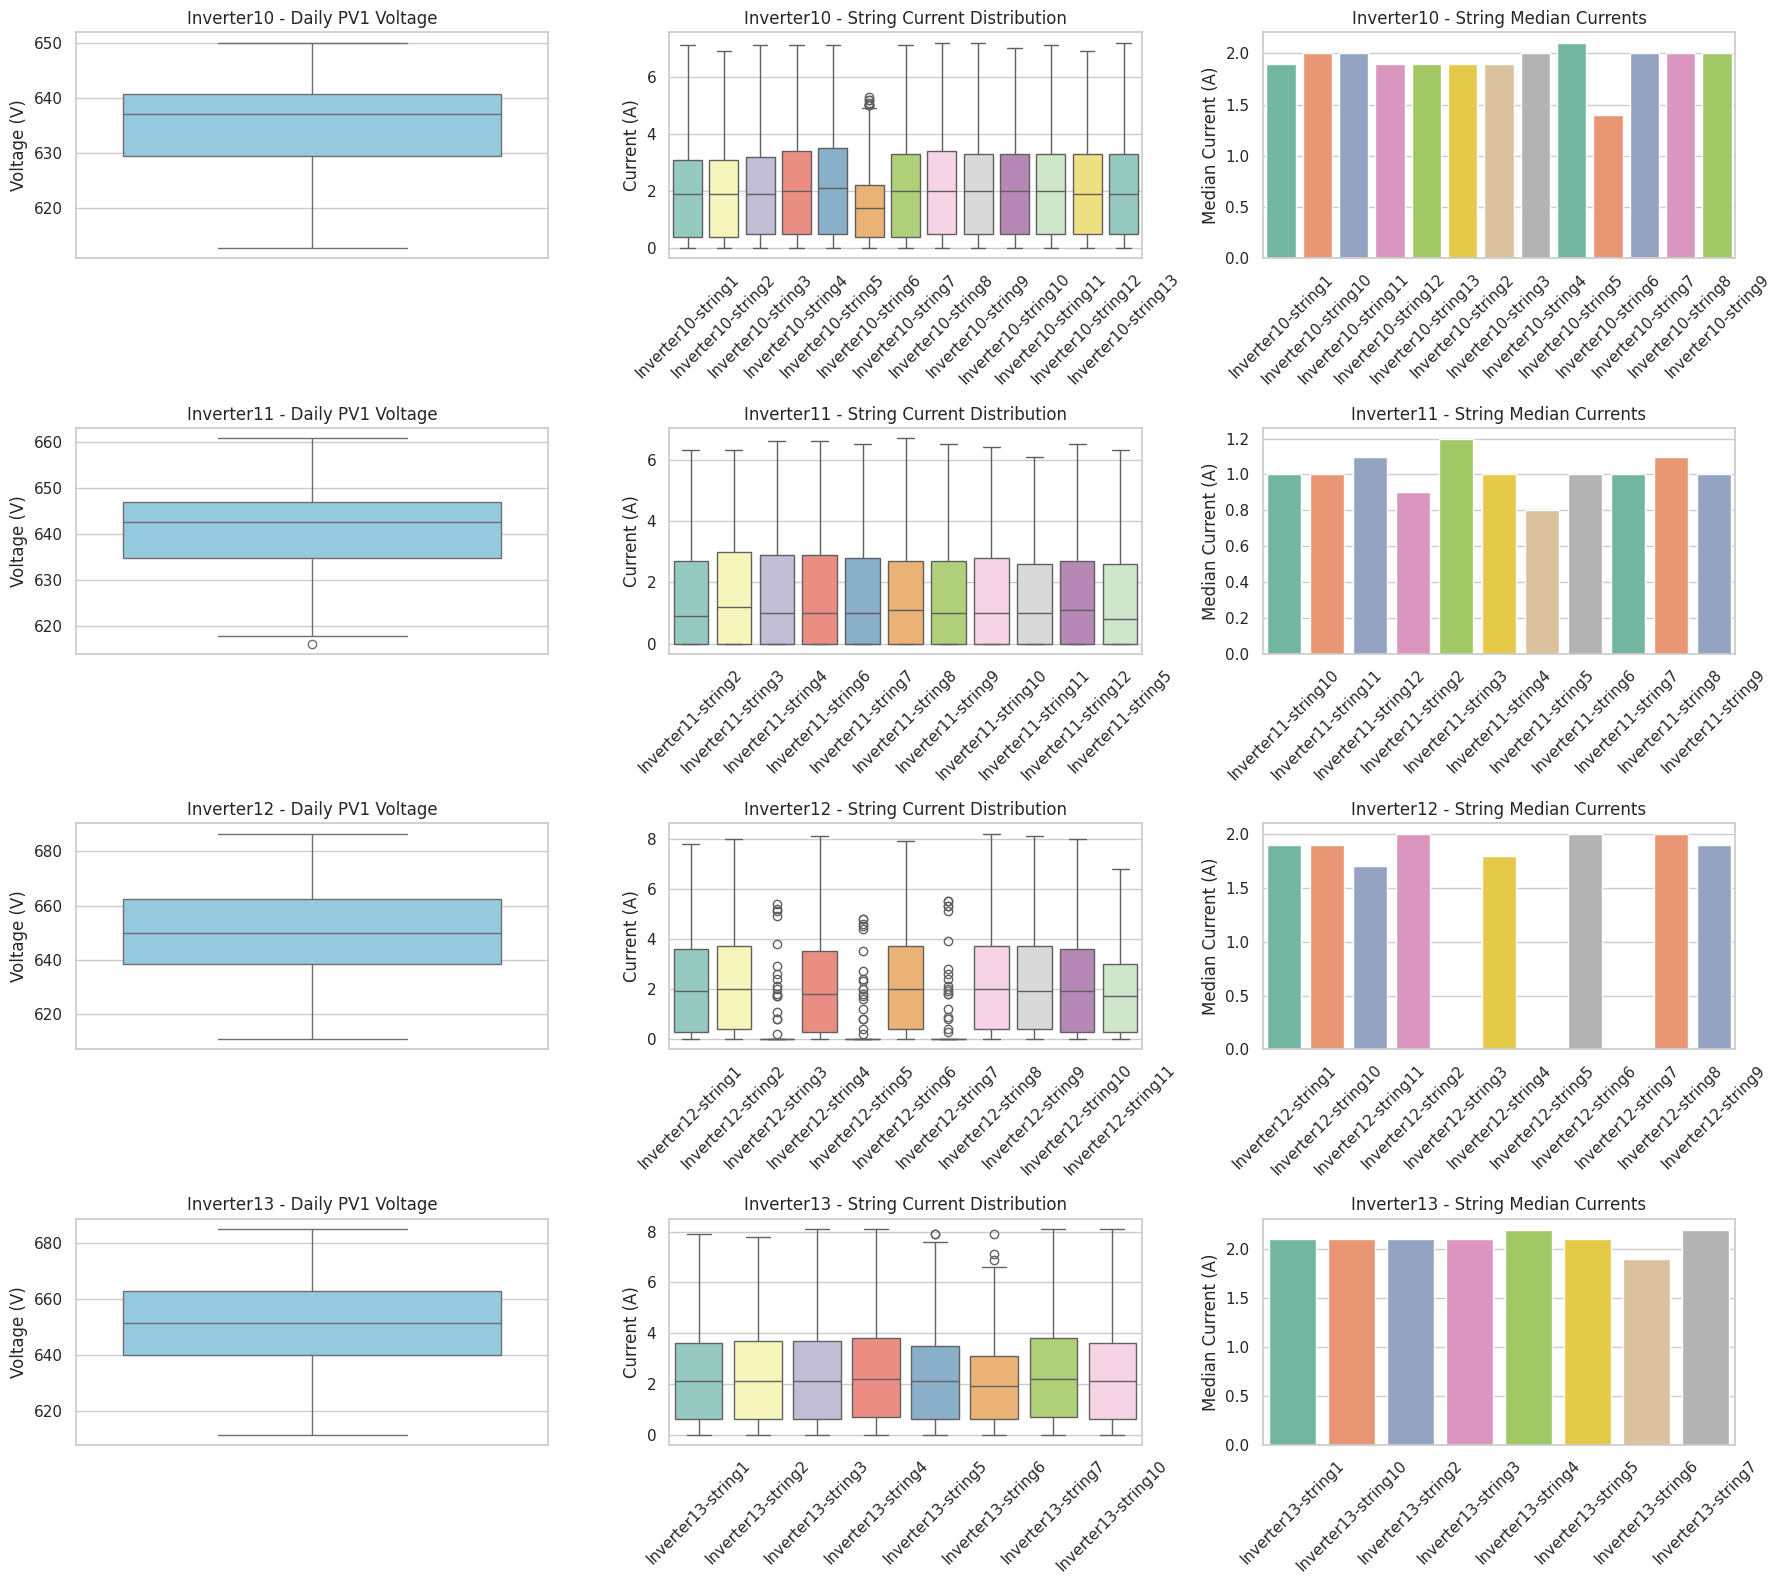

None

In [ ]:
outlier_df=plot_type2_string_summary( type2_df, type2_inverters_full,return_outliers=False)
display(outlier_df)

In [ ]:
import numpy as np
import pandas as pd

def type2_inverter_string_summary(df, type2_inverters, drop_threshold_v=0.2, drop_threshold_c=0.3, window_size=7, low_current_pct=0.10, min_median_threshold=0.5, min_spread_pct=0.05):
    """
    Computes voltage sudden drops, string current sudden drops, low-performing strings, and string current stats for Type 2 inverters.

    Parameters:
        df (DataFrame): Full cleaned dataset with Time column in datetime format.
        type2_inverters (list): List of Type 2 inverter names, e.g., ['Inverter13', ...]
        drop_threshold_v (float): Fractional threshold for voltage sudden drop detection.
        drop_threshold_c (float): Fractional threshold for string current sudden drop detection.
        window_size (int): Rolling window size for baseline computation.
        low_current_pct (float): Threshold to flag low-performing strings (>10% below max median).
        min_median_threshold (float): Minimum median current to consider low-performance check valid.
        min_spread_pct (float): Minimum spread required between max and min string medians to flag low performers.

    Returns:
        summary_df (DataFrame): Summary table per inverter with voltage stats, sudden drops, low-performing strings, and string current stats.
    """
    results = []

    for inv in type2_inverters:

        pv1_v = f"{inv}-pv1_voltage"
        string_cols = [col for col in df.columns if col.startswith(inv) and "string" in col.lower()]

        if pv1_v not in df.columns or not string_cols:
            continue

        sub_df = df[['Time', pv1_v] + string_cols].copy()
        sub_df['Hour'] = sub_df['Time'].dt.hour
        day_df = sub_df[(sub_df['Hour'] >= 7) & (sub_df['Hour'] <= 17)].copy()

        ### VOLTAGE ANALYSIS ###
        day_df['Rolling_Median_V'] = day_df[pv1_v].rolling(window=window_size, center=True, min_periods=3).median()
        sudden_drops_v = (day_df[pv1_v] < day_df['Rolling_Median_V'] * (1 - drop_threshold_v)).sum()

        daily_avg_v = day_df.groupby(day_df['Time'].dt.date)[pv1_v].mean()
        daily_drop_v = (daily_avg_v < daily_avg_v.rolling(window=3, center=True, min_periods=1).median() * (1 - drop_threshold_v)).sum()

        ### STRING CURRENT ANALYSIS ###
        medians = {}
        sudden_drops_c_total = 0
        low_performing_strings = []

        for col in string_cols:
            day_df[f'Rolling_Median_{col}'] = day_df[col].rolling(window=window_size, center=True, min_periods=3).median()
            sudden_drops_c = (day_df[col] < day_df[f'Rolling_Median_{col}'] * (1 - drop_threshold_c)).sum()
            sudden_drops_c_total += sudden_drops_c
            medians[col] = np.nanmedian(day_df[col])

        max_median = max(medians.values()) if medians else 0
        min_median = min(medians.values()) if medians else 0

        ### Improved Low-Performing Logic ###
        if max_median > min_median_threshold and (max_median - min_median) / max_median > min_spread_pct:
            for col, m in medians.items():
                if (max_median - m) / max_median > low_current_pct:
                    low_performing_strings.append(col)

        ### String Current Stats ###
        all_currents = day_df[string_cols].stack()
        mean_current = all_currents.mean()
        std_current = all_currents.std()
        cv_current = std_current / mean_current if mean_current != 0 else np.nan

        ### STORE RESULTS ###
        results.append({
            'Inverter': inv,
            'Sudden Drops PV1 (V)': sudden_drops_v,
            'Daily Mean Drops PV1 (>20%) (V)': daily_drop_v,
            'Total Sudden String Current Drops': sudden_drops_c_total,
            'Low Performing Strings': ", ".join(low_performing_strings),
            'Mean String Current (A)': round(mean_current, 2),
            'Std Dev String Current (A)': round(std_current, 2),
            'CV String Current': round(cv_current, 3)
        })

    summary_df = pd.DataFrame(results)
    return summary_df

In [ ]:
type2_summary_df = type2_inverter_string_summary(type2_df, type2_inverters_full)
pd.set_option('display.max_colwidth', None)
display(type2_summary_df)

Inverter  Sudden Drops PV1 (V)  Daily Mean Drops PV1 (>20%) (V)  \
0  Inverter10                   102                                0   
1  Inverter11                   120                                0   
2  Inverter12                    96                                0   
3  Inverter13                   108                                0   

   Total Sudden String Current Drops  \
0                              31564   
1                              18624   
2                              10217   
3                              10991   

                                                                                                                                             Low Performing Strings  \
0                                                                                                                                                Inverter10-string6   
1  Inverter11-string2, Inverter11-string4, Inverter11-string6, Inverter11-string7, Inverter11-string9, Inverter11-string10, Inverter11-string11, Inverter11-string5   
2                                                                                   Inverter12-string3, Inverter12-string5, Inverter12-string7, Inverter12-string11   
3                                                                                                                                                Inverter13-string6   

   Mean String Current (A)  Std Dev String Current (A)  CV String Current  
0                     1.94                        1.52              0.783  
1                     1.43                        1.48              1.035  
2                     1.84                        1.77              0.962  
3                     2.22                        1.72              0.777

In [ ]:
def plot_daily_voltage_type2(df):
    """
    Plots daily average PV1 voltage for each Type 2 inverter in a grid layout.
    Automatically removes invalid values >= 65536.

    Parameters:
        df (DataFrame): Cleaned Type 2 inverter data with 'Time' column as datetime.
    """

    df = df.copy()  # Ensures safe modification
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    df = df.dropna(subset=['Time']).sort_values('Time')

    # Replace absurdly large values with NaN, only for numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].mask(df[numeric_cols] >= 65536)

    # Extract unique Type 2 inverter names based on pv1_voltage columns
    inverter_names = sorted(set(col.split('-')[0] for col in df.columns if '-pv1_voltage' in col))

    n_inv = len(inverter_names)
    n_cols = int(np.ceil(np.sqrt(n_inv)))
    n_rows = int(np.ceil(n_inv / n_cols))

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=False)
    axs = axs.flatten()

    for idx, inv in enumerate(inverter_names):
        pv1_col = f"{inv}-pv1_voltage"

        if pv1_col not in df.columns:
            continue

        sub_df = df[['Time', pv1_col]].copy()
        sub_df['Date'] = sub_df['Time'].dt.date

        daily_avg = sub_df.groupby('Date')[pv1_col].mean().reset_index()

        ax = axs[idx]
        ax.plot(daily_avg['Date'], daily_avg[pv1_col], label='PV1 Voltage', color='blue')
        ax.set_title(inv)
        ax.set_xlabel('Date')
        ax.set_ylabel('Voltage (V)')
        ax.grid(True)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(fontsize='small')

    # Hide extra axes
    for j in range(n_inv, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.suptitle('Daily Average PV1 Voltages - Type 2 Inverters', fontsize=16, y=1.02)
    plt.show()

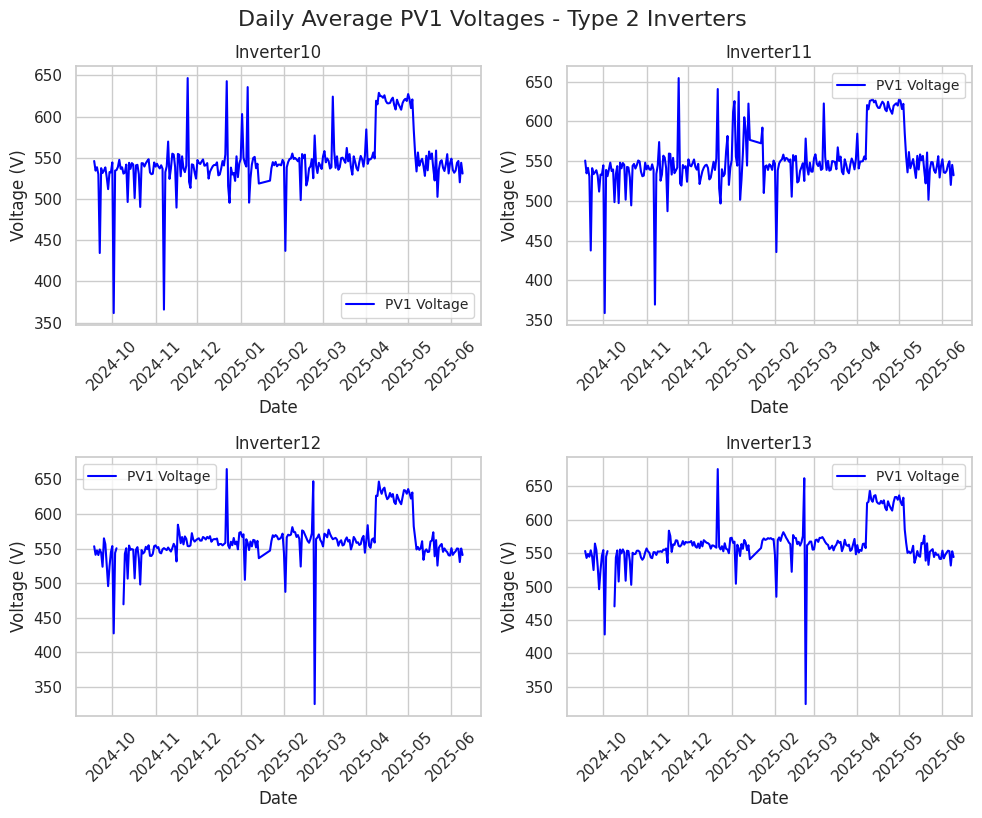

In [ ]:
plot_daily_voltage_type2(type2_df)

In [ ]:
new_data_loc = '/content/drive/My Drive/FPE Data/LOG BOOKS/NER/combined_with_PR_CUF.xlsx'
data_ner = pd.read_excel(new_data_loc)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math

def plot_pr_correlation_type1_v2_final_clean(type1_df, pr_cuf_df, inverter_name,
                                             zero_frac_threshold=0.95, mean_threshold=0.1,
                                             voltage_limit=1000, current_limit=1000):
    """
      Plots PR correlation with PV1/PV2 current and voltage for a given inverter,
      cleans unrealistic values, tracks replacements, skips unreliable metrics,
      prints summary table.

      Returns:
          summary_dict: Dict summarizing skipped metrics and extreme value counts.
    """

    inv_num = inverter_name.replace("Inverter", "")
    voltage_cols = [f"{inverter_name}-pv1_voltage", f"{inverter_name}-pv2_voltage"]
    current_cols = [f"{inverter_name}-pv1_current", f"{inverter_name}-pv2_current"]
    pr_col = f"Inverter {inv_num} PR"

    temp_df = type1_df[["Time"] + voltage_cols + current_cols].copy()
    temp_df["Time"] = pd.to_datetime(temp_df["Time"])
    temp_df["date"] = temp_df["Time"].dt.date

    # Track counts of extreme values replaced
    extreme_counts = {}

    for col in voltage_cols:
        extreme_mask = (temp_df[col] > voltage_limit) | (temp_df[col] < 0)
        extreme_counts[col] = extreme_mask.sum()
        temp_df.loc[extreme_mask, col] = None

    for col in current_cols:
        extreme_mask = (temp_df[col] > current_limit) | (temp_df[col] < 0)
        extreme_counts[col] = extreme_mask.sum()
        temp_df.loc[extreme_mask, col] = None

    # Daily means
    daily_df = temp_df.groupby("date").agg({
        voltage_cols[0]: "mean",
        voltage_cols[1]: "mean",
        current_cols[0]: "mean",
        current_cols[1]: "mean"
    }).reset_index()

    pr_temp = pr_cuf_df[["Date", pr_col]].copy()
    pr_temp["Date"] = pd.to_datetime(pr_temp["Date"])
    pr_temp["date"] = pr_temp["Date"].dt.date

    merged_df = pd.merge(daily_df, pr_temp[["date", pr_col]], on="date", how="inner")

    # Metric filtering
    metrics = {
        "PV1 Current": current_cols[0],
        "PV2 Current": current_cols[1],
        "PV1 Voltage": voltage_cols[0],
        "PV2 Voltage": voltage_cols[1]
    }
    valid_metrics = []
    skipped_metrics = []

    total_days = len(merged_df)
    for label, col in metrics.items():
        zero_frac = (merged_df[col] == 0).sum() / total_days
        mean_val = merged_df[col].mean()

        if zero_frac >= zero_frac_threshold or mean_val < mean_threshold or pd.isna(mean_val):
            skipped_metrics.append(f"{label} (Zero%={zero_frac*100:.1f}%, Mean={mean_val:.2f})")
        else:
            valid_metrics.append((label, col))

    # Plot valid metrics
    if valid_metrics:
        n = len(valid_metrics)
        cols = 2 if n > 1 else 1
        rows = math.ceil(n / cols)
        fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
        axes = axes.flatten() if n > 1 else [axes]

        fig.suptitle(f"{inverter_name} - PR Correlation (Valid Metrics Only)", fontsize=14)

        for ax, (label, col) in zip(axes, valid_metrics):
            sns.scatterplot(data=merged_df, x=col, y=pr_col, ax=ax)
            ax.set_title(f"PR vs {label}")

        for i in range(len(valid_metrics), len(axes)):
            fig.delaxes(axes[i])

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print(f"{inverter_name}: ❌ All metrics skipped (unreliable)")

    # Prepare summary dict
    summary_dict = {
        "Inverter": inverter_name,
        "Skipped Metrics": skipped_metrics,
    }
    for label, col in metrics.items():
        summary_dict[f"{label} Outliers Replaced"] = extreme_counts[col]

    return summary_dict

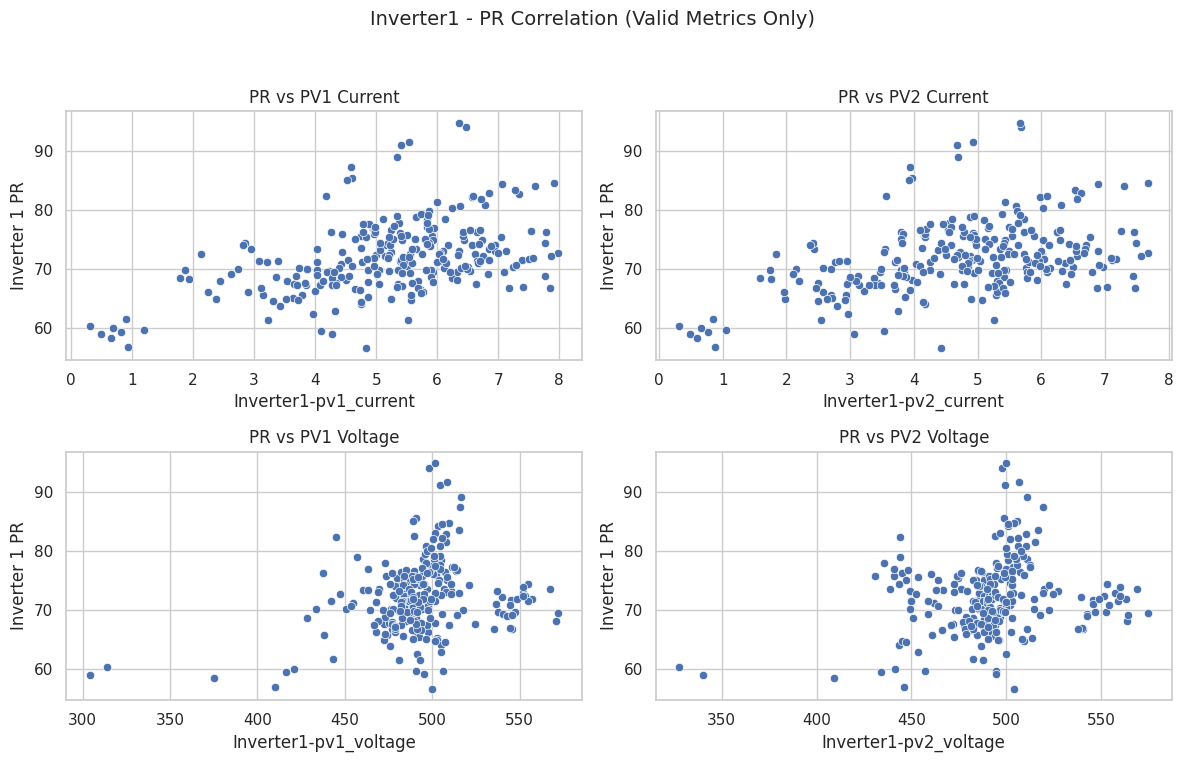

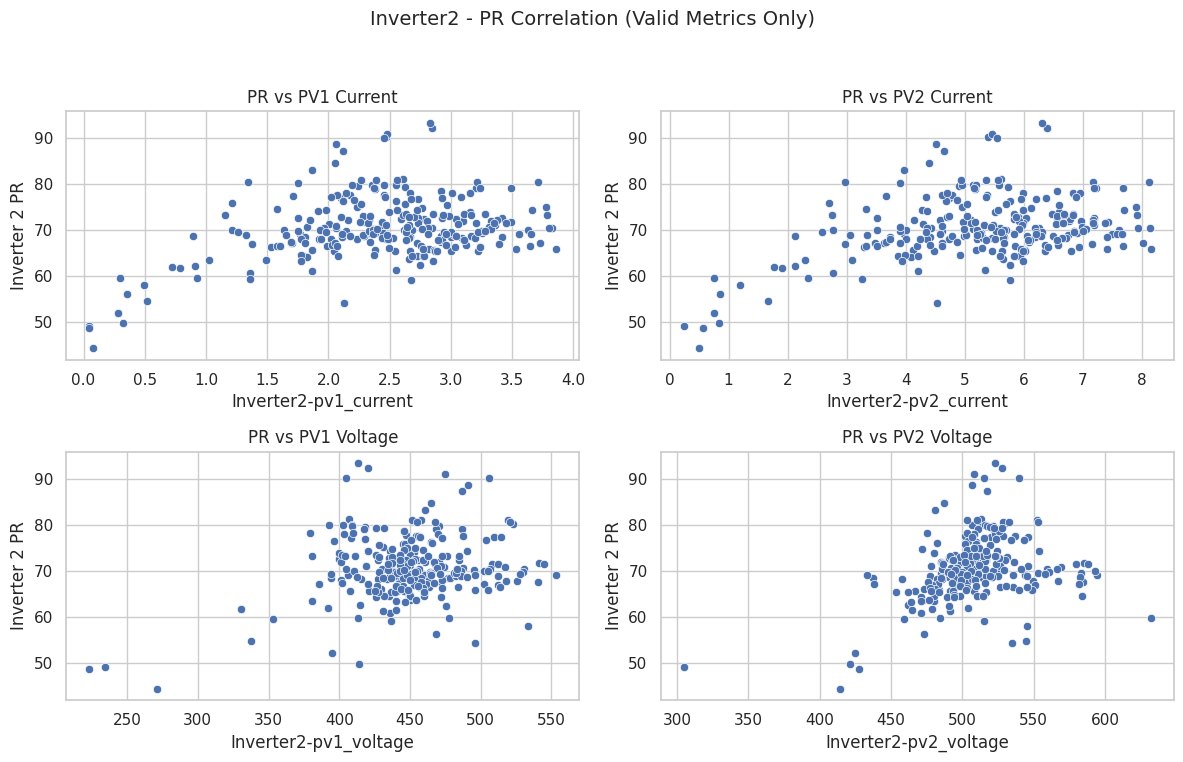

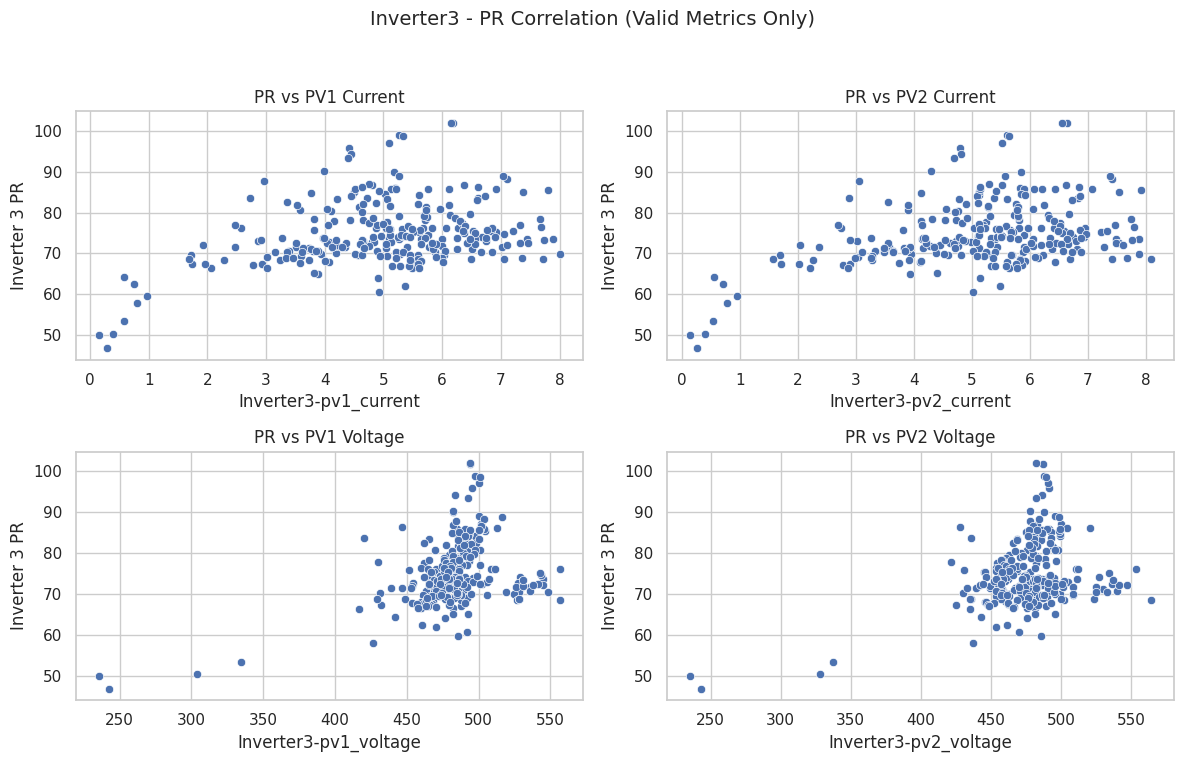

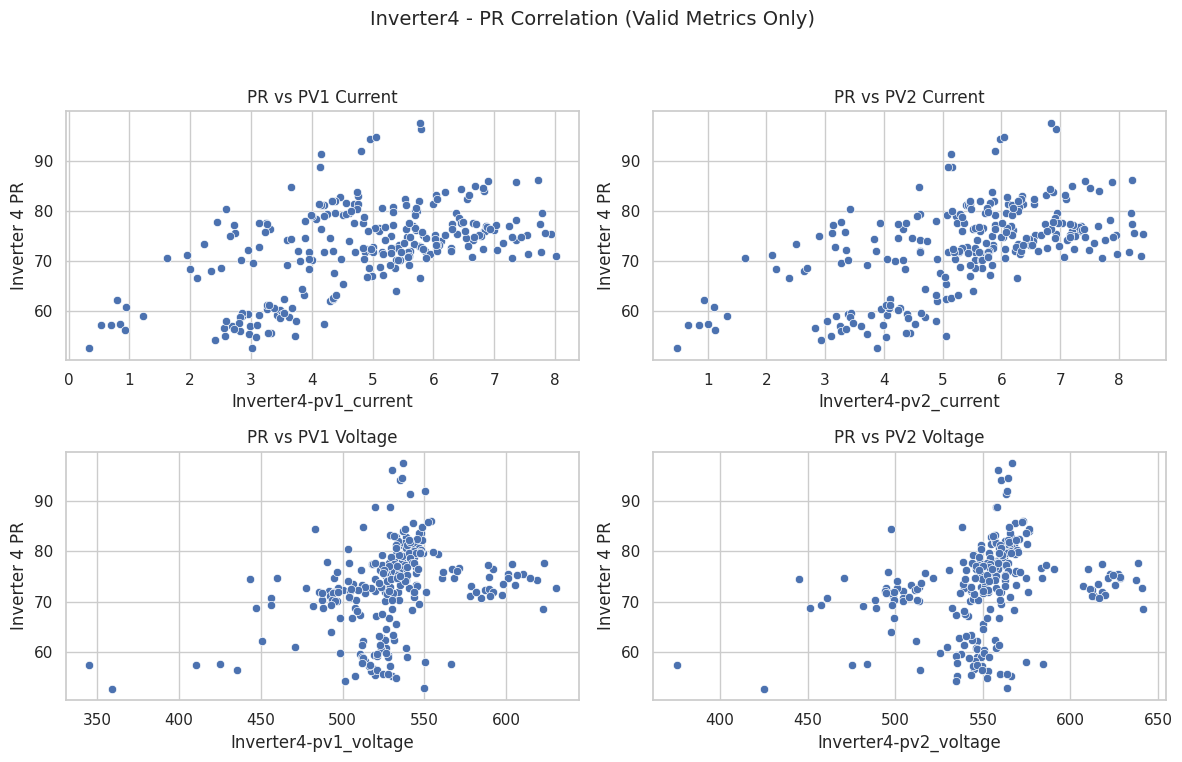

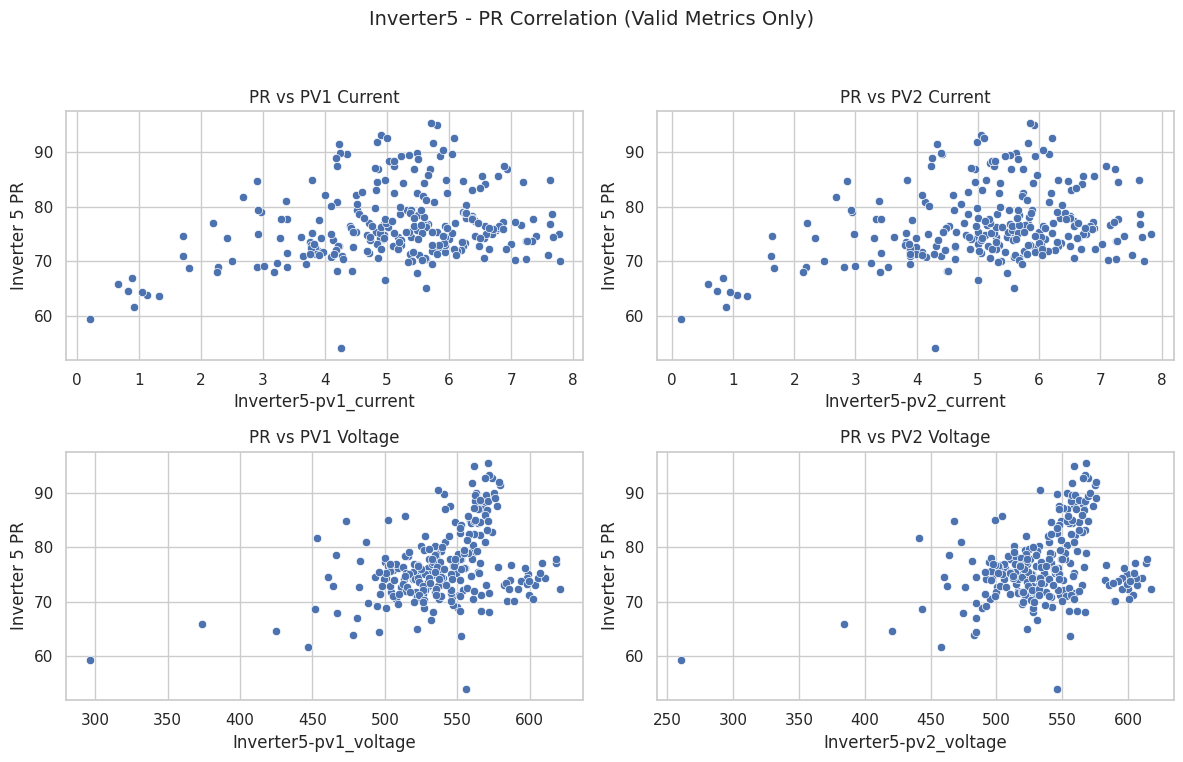

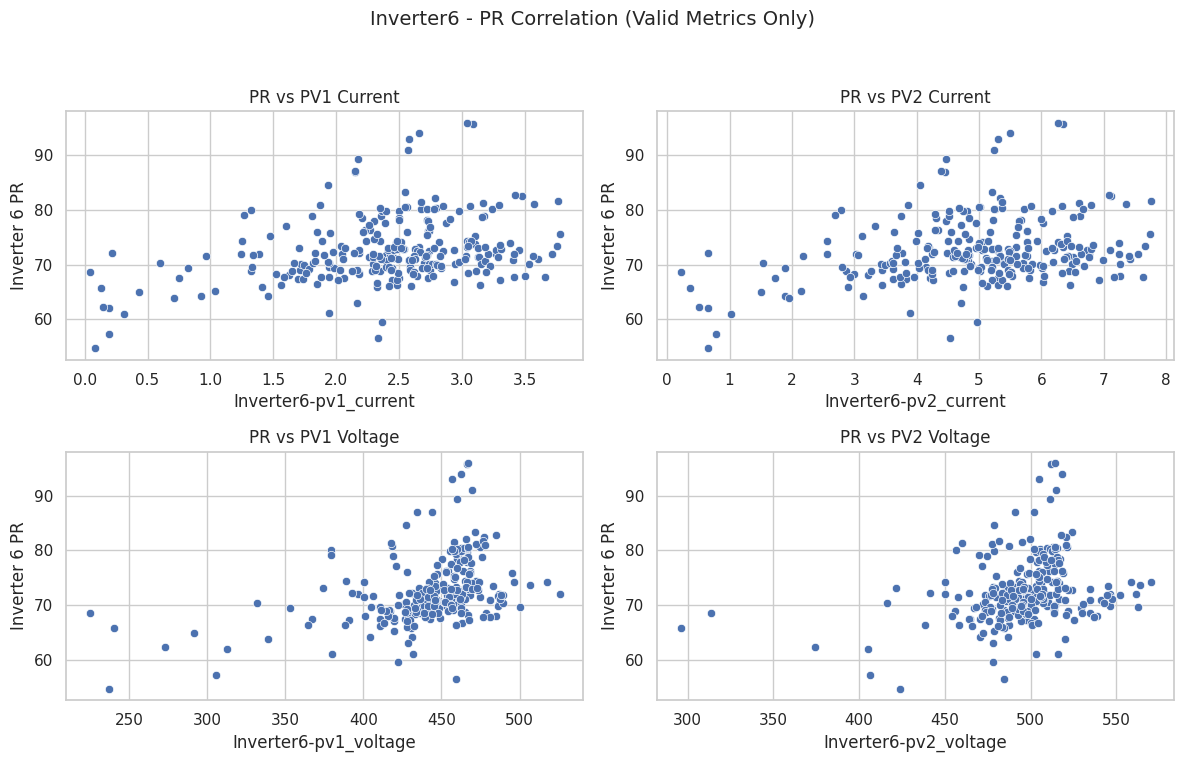

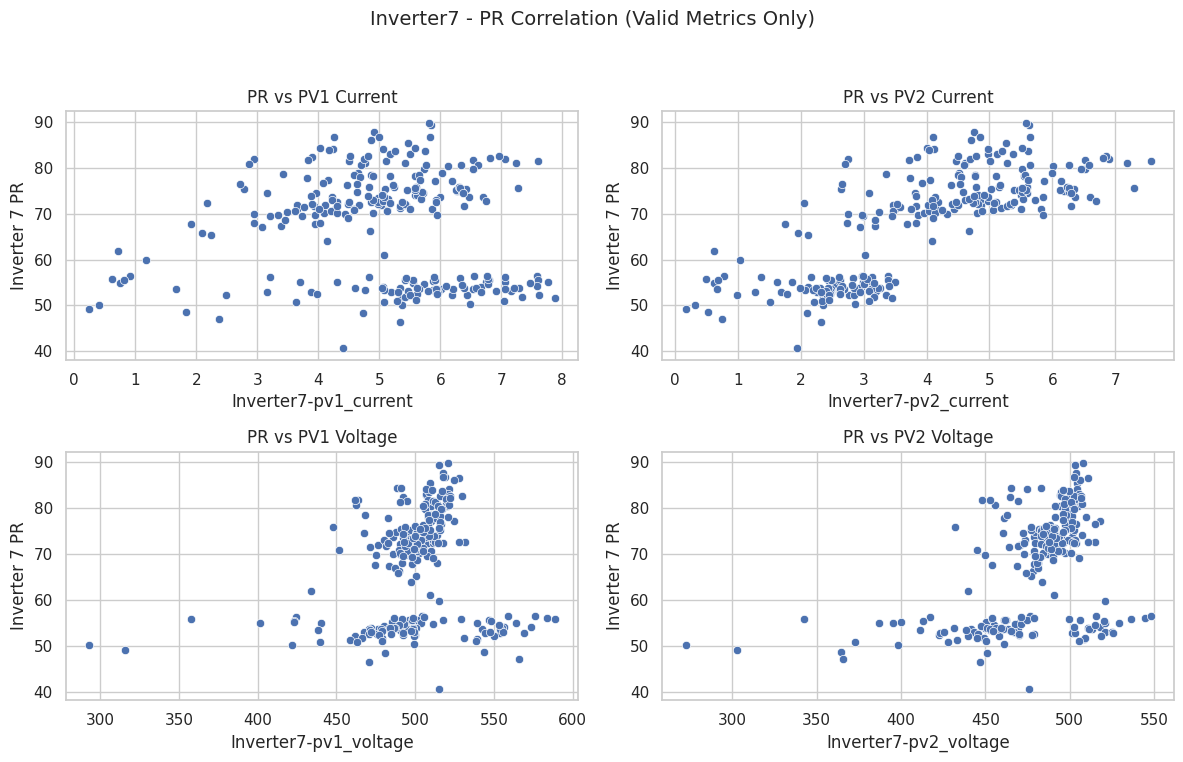

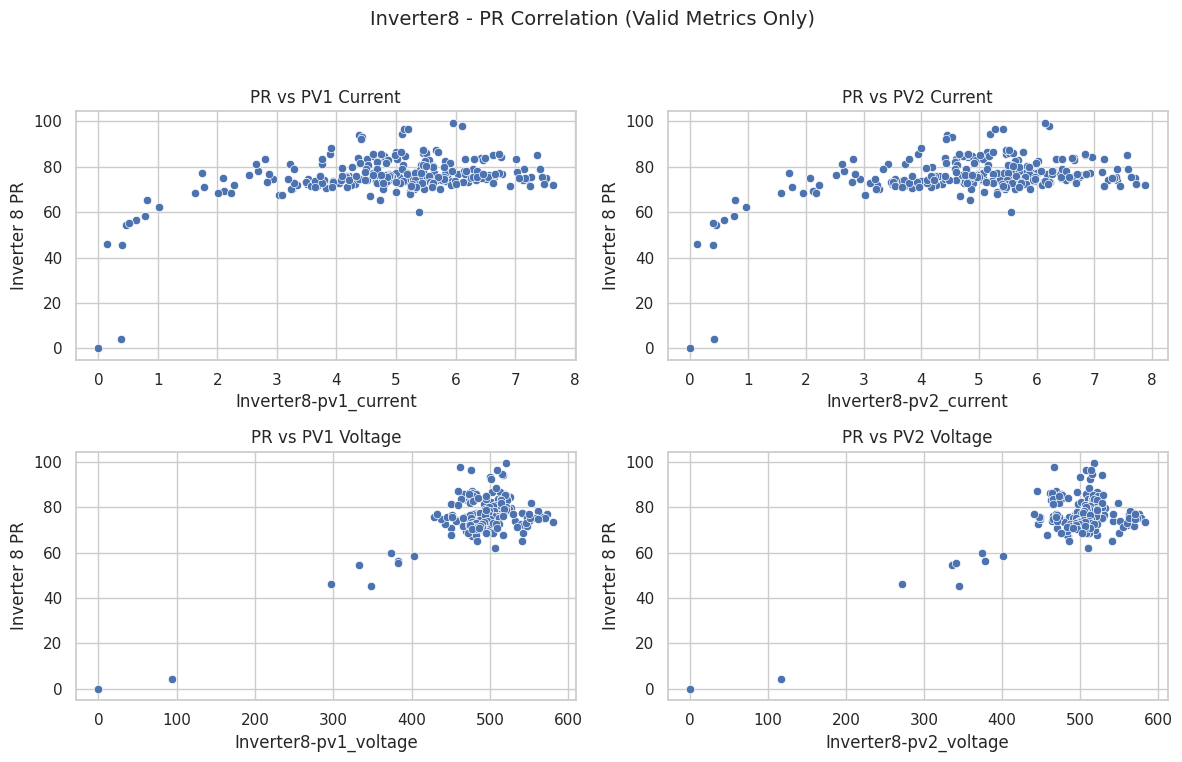

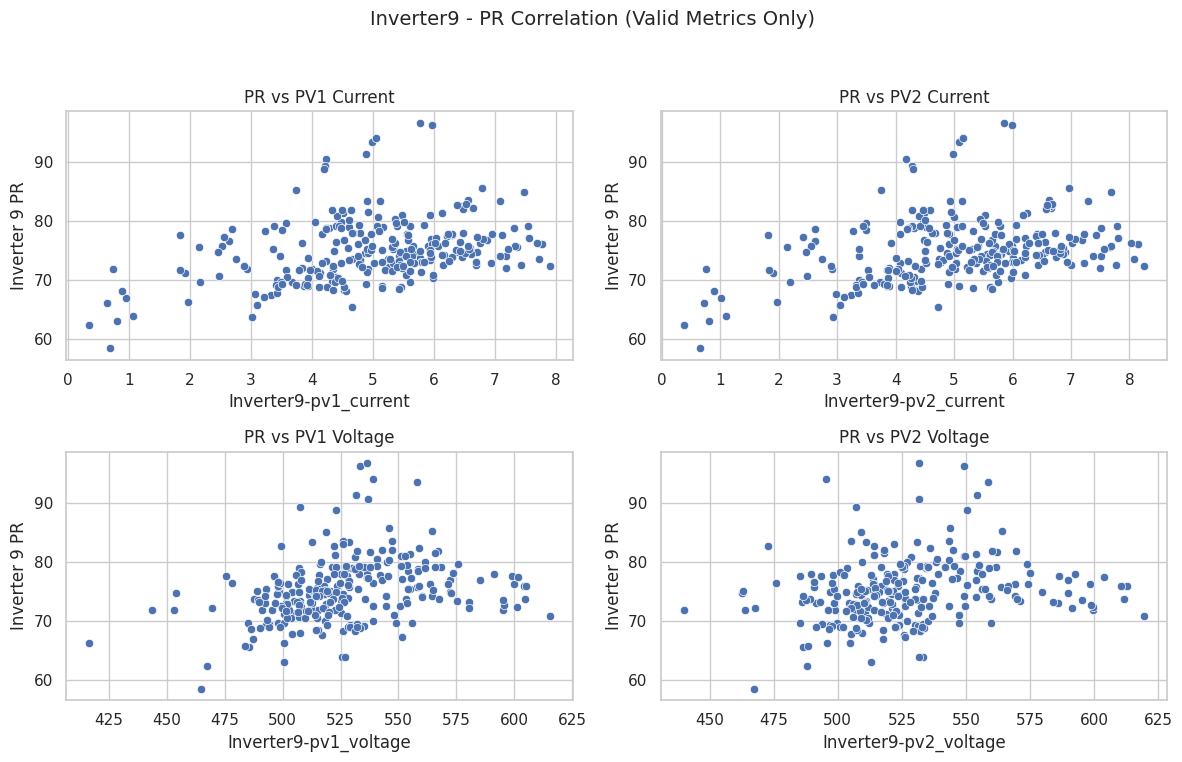

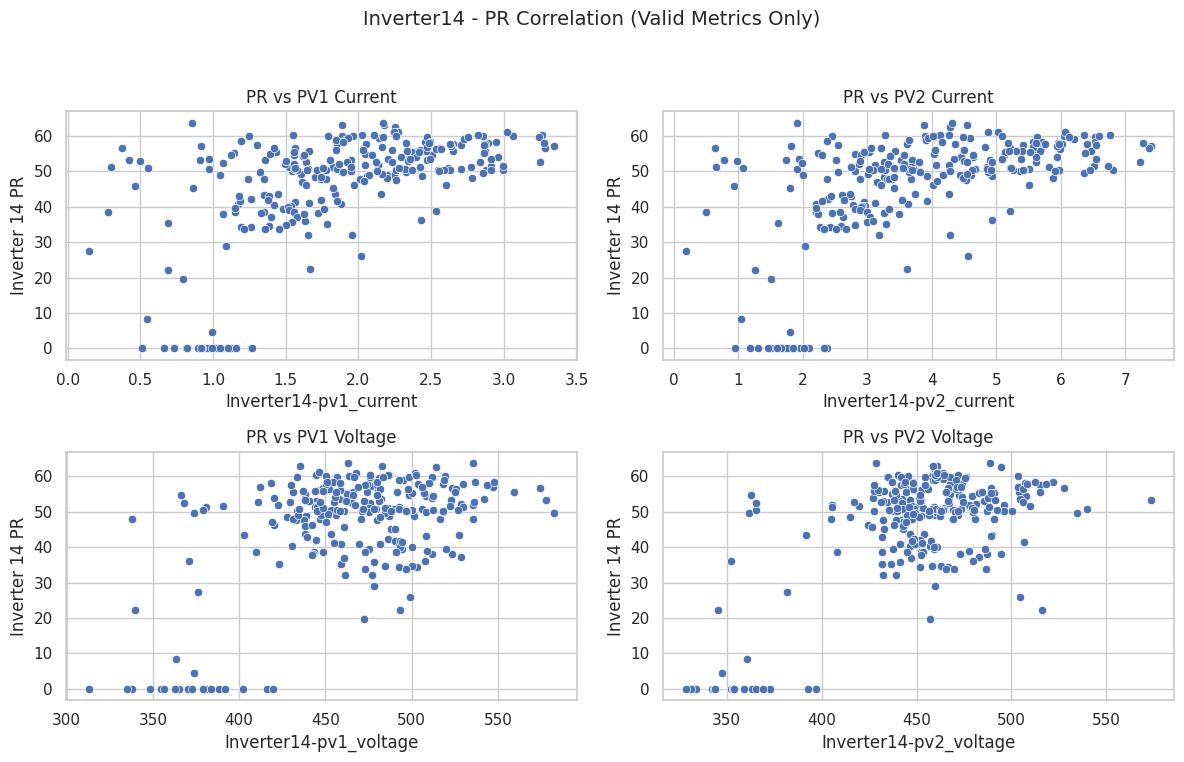

In [ ]:
summary_list = []

for inverter in type1_inverters_full:
    summary = plot_pr_correlation_type1_v2_final_clean(type1_df, data_ner, inverter)
    summary_list.append(summary)

summary_df_type1 = pd.DataFrame(summary_list)

In [ ]:
display(summary_df_type1)

Inverter Skipped Metrics  PV1 Current Outliers Replaced  \
0   Inverter1              []                              8   
1   Inverter2              []                              0   
2   Inverter3              []                            121   
3   Inverter4              []                             31   
4   Inverter5              []                            154   
5   Inverter6              []                            101   
6   Inverter7              []                             75   
7   Inverter8              []                            106   
8   Inverter9              []                              0   
9  Inverter14              []                              0   

   PV2 Current Outliers Replaced  PV1 Voltage Outliers Replaced  \
0                              6                              2   
1                              0                              0   
2                            273                              0   
3                             19                              0   
4                             59                              0   
5                             37                              0   
6                             14                              0   
7                             14                              0   
8                              0                              0   
9                              0                              1   

   PV2 Voltage Outliers Replaced  
0                              0  
1                              0  
2                              0  
3                              0  
4                              0  
5                              1  
6                              0  
7                              0  
8                              0  
9                              0

In [ ]:
def analyze_type2_inverter(type2_df, pr_cuf_df, inverter_name,
                           current_limit=1000, voltage_limit=1000,
                           zero_frac_threshold=0.95, mean_threshold=0.1):
    """
    Compact analysis of a Type 2 inverter.
    Returns a simplified, readable summary dictionary.
    """

    inverter_cols = [col for col in type2_df.columns if inverter_name in col]
    string_cols = sorted([col for col in inverter_cols if "string" in col.lower()])
    pv1_current_col = f"{inverter_name}-pv1_current"
    pv1_voltage_col = f"{inverter_name}-pv1_voltage"
    inv_num = inverter_name.replace("Inverter", "")
    pr_col = f"Inverter {inv_num} PR"

    required_cols = ["Time"] + string_cols + [pv1_current_col, pv1_voltage_col]
    temp_df = type2_df[required_cols].copy()
    temp_df["Time"] = pd.to_datetime(temp_df["Time"])
    temp_df["date"] = temp_df["Time"].dt.date

    extreme_counts = {"Current Outliers": 0, "Voltage Outliers": 0}

    # Clean extreme values
    for col in string_cols + [pv1_current_col]:
        mask = (temp_df[col] > current_limit) | (temp_df[col] < 0)
        extreme_counts["Current Outliers"] += mask.sum()
        temp_df.loc[mask, col] = None

    mask_v = (temp_df[pv1_voltage_col] > voltage_limit) | (temp_df[pv1_voltage_col] < 0)
    extreme_counts["Voltage Outliers"] += mask_v.sum()
    temp_df.loc[mask_v, pv1_voltage_col] = None

    # Daily aggregation
    daily_df = temp_df.groupby("date").agg({col: "mean" for col in string_cols + [pv1_current_col, pv1_voltage_col]}).reset_index()
    daily_df["Total String Current"] = daily_df[string_cols].sum(axis=1)

    # String health check
    unhealthy_strings = []
    total_days = len(daily_df)
    for col in string_cols:
        zero_frac = (daily_df[col] == 0).sum() / total_days
        mean_val = daily_df[col].mean()
        if zero_frac >= zero_frac_threshold or mean_val < mean_threshold or pd.isna(mean_val):
            unhealthy_strings.append(f"{col.split('-')[-1]} (Zero%={zero_frac*100:.1f}%, Mean={mean_val:.2f})")

    # Imbalance check
    daily_df["String Std Dev"] = daily_df[string_cols].std(axis=1)
    avg_imbalance = daily_df["String Std Dev"].mean()

    # Compact summary dictionary
    summary_dict = {
        "Inverter": inverter_name,
        "Unhealthy Strings Count": len(unhealthy_strings),
        "Unhealthy Strings Details": "; ".join(unhealthy_strings) if unhealthy_strings else "-",
        "Avg String Imbalance (Std Dev)": round(avg_imbalance, 2),
        "Total Outliers Replaced (Current)": extreme_counts["Current Outliers"],
        "Total Outliers Replaced (Voltage)": extreme_counts["Voltage Outliers"]
    }

    return summary_dict

In [ ]:
summary_list = []

def plot_type2_inverter_correlation(type2_df, pr_cuf_df, inverter_name):
    inverter_cols = [col for col in type2_df.columns if inverter_name in col]
    string_cols = sorted([col for col in inverter_cols if "string" in col.lower()])
    pv1_current_col = f"{inverter_name}-pv1_current"
    pv1_voltage_col = f"{inverter_name}-pv1_voltage"
    inv_num = inverter_name.replace("Inverter", "")
    pr_col = f"Inverter {inv_num} PR"

    required_cols = ["Time"] + string_cols + [pv1_current_col, pv1_voltage_col]
    temp_df = type2_df[required_cols].copy()
    temp_df["Time"] = pd.to_datetime(temp_df["Time"])
    temp_df["date"] = temp_df["Time"].dt.date

    daily_df = temp_df.groupby("date").agg({col: "mean" for col in string_cols + [pv1_current_col, pv1_voltage_col]}).reset_index()
    daily_df["Total String Current"] = daily_df[string_cols].sum(axis=1)

    pr_temp = pr_cuf_df[["Date", pr_col]].copy()
    pr_temp["Date"] = pd.to_datetime(pr_temp["Date"])
    pr_temp["date"] = pr_temp["Date"].dt.date

    merged_df = pd.merge(daily_df, pr_temp[["date", pr_col]], on="date", how="inner")

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"{inverter_name} - PR Correlation", fontsize=14)

    sns.scatterplot(data=merged_df, x="Total String Current", y=pr_col, ax=axes[0])
    axes[0].set_title("PR vs Total String Current")

    sns.scatterplot(data=merged_df, x=pv1_voltage_col, y=pr_col, ax=axes[1])
    axes[1].set_title("PR vs PV1 Voltage")

    plt.tight_layout()
    plt.show()

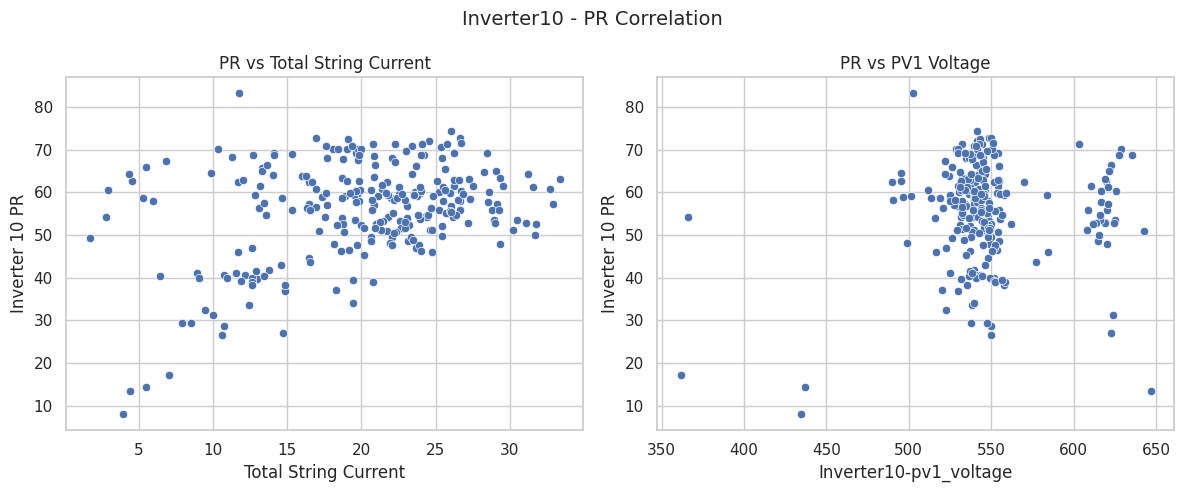

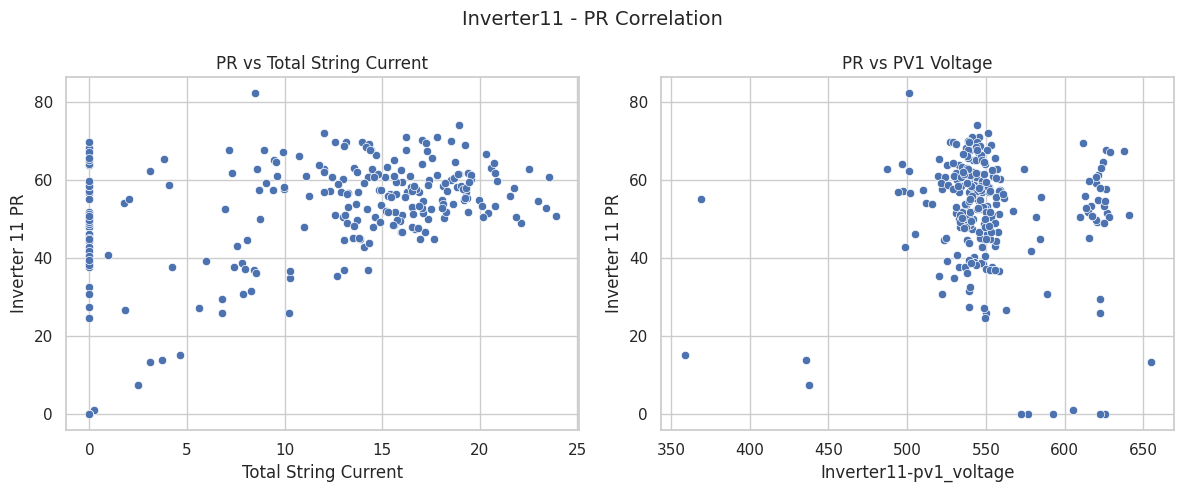

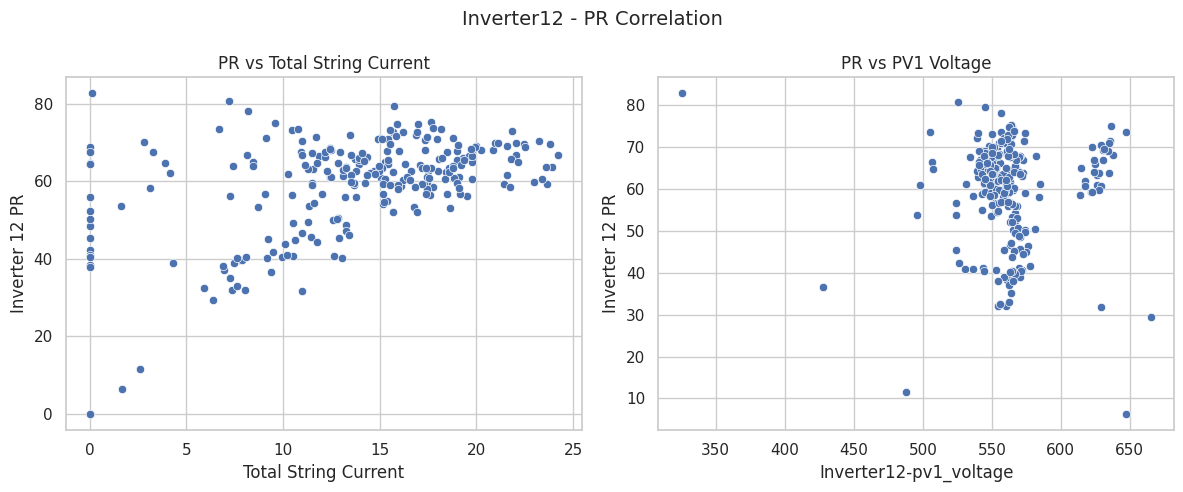

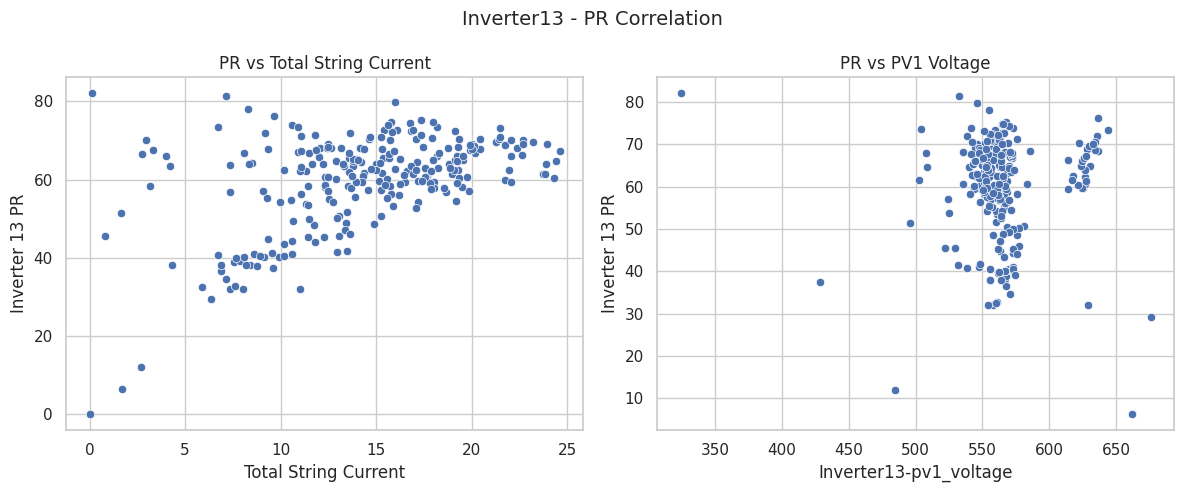

In [ ]:
for inv in ["Inverter10", "Inverter11", "Inverter12", "Inverter13"]:
    summary = analyze_type2_inverter(type2_df, data_ner, inv)
    plot_type2_inverter_correlation(type2_df,data_ner, inv)
    summary_list.append(summary)
summary_df_type2 = pd.DataFrame(summary_list)

In [ ]:
pd.set_option('display.max_colwidth', None)
display(summary_df_type2)

Inverter  Unhealthy Strings Count  \
0  Inverter10                        0   
1  Inverter11                        0   
2  Inverter12                        3   
3  Inverter13                        0   

                                                                              Unhealthy Strings Details  \
0                                                                                                     -   
1                                                                                                     -   
2  string3 (Zero%=28.3%, Mean=0.00); string5 (Zero%=30.2%, Mean=0.00); string7 (Zero%=30.2%, Mean=0.00)   
3                                                                                                     -   

   Avg String Imbalance (Std Dev)  Total Outliers Replaced (Current)  \
0                            0.15                                  0   
1                            0.06                                  0   
2                            0.37                                  0   
3                            0.11                                  0   

   Total Outliers Replaced (Voltage)  
0                                  0  
1                                  1  
2                                  1  
3                                  0

In [ ]:
# ----- Type 1 Health Summary -----

def combine_type1_health_summary(type1_stats: pd.DataFrame,
                                 type1_outliers: pd.DataFrame,
                                 threshold_config: dict) -> pd.DataFrame:
    """
    Combine Type 1 summary metrics and compute health flags with reasons.

    Unhealthy if at least 3 out of the 4 main flags (excluding outliers) are True.

    Parameters:
      type1_stats      - DataFrame from type1_inverter_mismatch_and_drop_analysis
      type1_outliers   - DataFrame from Type1 outlier replacements summary
      threshold_config - dict of thresholds:
          {
            'mismatch_volt_pct': 10,
            'mismatch_curr_pct': 10,
            'drop_voltage_count': 50,
            'drop_current_count': 50,
            'outlier_count': 30
          }

    Returns:
      DataFrame with health flags and reasons.
    """
    df = type1_stats.merge(type1_outliers, on='Inverter', how='left')
    df.fillna(0, inplace=True)

    thr_v = threshold_config.get('mismatch_volt_pct', 10)
    thr_c = threshold_config.get('mismatch_curr_pct', 10)
    thr_vdrop = threshold_config.get('drop_voltage_count', 50)
    thr_cdrop = threshold_config.get('drop_current_count', 50)
    thr_out = threshold_config.get('outlier_count', 30)

    df['High_Volt_Mismatch'] = df['Mean Mismatch % (V)'] > thr_v
    df['High_Volt_Mismatch_Reason'] = df.apply(lambda x: f"{x['Mean Mismatch % (V)']:.1f}%" if x['High_Volt_Mismatch'] else '-', axis=1)

    df['High_Curr_Mismatch'] = df['Mean Mismatch % (C)'] > thr_c
    df['High_Curr_Mismatch_Reason'] = df.apply(lambda x: f"{x['Mean Mismatch % (C)']:.1f}%" if x['High_Curr_Mismatch'] else '-', axis=1)

    df['Frequent_Volt_Drops'] = (df['Sudden Drops PV1 (V)'] + df['Sudden Drops PV2 (V)']) > thr_vdrop
    df['Frequent_Volt_Drops_Reason'] = df.apply(lambda x: f"Drops V1+V2: {int(x['Sudden Drops PV1 (V)'] + x['Sudden Drops PV2 (V)'])}" if x['Frequent_Volt_Drops'] else '-', axis=1)

    df['Frequent_Curr_Drops'] = (df['Sudden Drops PV1 (C)'] + df['Sudden Drops PV2 (C)']) > thr_cdrop
    df['Frequent_Curr_Drops_Reason'] = df.apply(lambda x: f"Drops C1+C2: {int(x['Sudden Drops PV1 (C)'] + x['Sudden Drops PV2 (C)'])}" if x['Frequent_Curr_Drops'] else '-', axis=1)

    df['High_Outliers'] = (df['PV1 Current Outliers Replaced'] + df['PV2 Current Outliers Replaced'] +
                           df['PV1 Voltage Outliers Replaced'] + df['PV2 Voltage Outliers Replaced']) > thr_out
    df['High_Outliers_Reason'] = df.apply(lambda x: f"{int(x['PV1 Current Outliers Replaced'] + x['PV2 Current Outliers Replaced'] + x['PV1 Voltage Outliers Replaced'] + x['PV2 Voltage Outliers Replaced'])} replaced" if x['High_Outliers'] else '-', axis=1)

    # Overall logic: at least 3 of 4 flags True (excluding outliers)
    flag_cols = ['High_Volt_Mismatch', 'High_Curr_Mismatch', 'Frequent_Volt_Drops', 'Frequent_Curr_Drops']
    reason_cols = ['High_Volt_Mismatch_Reason', 'High_Curr_Mismatch_Reason', 'Frequent_Volt_Drops_Reason', 'Frequent_Curr_Drops_Reason', 'High_Outliers_Reason']

    df['Overall_Health'] = df[flag_cols].sum(axis=1) >= 3
    df['Overall_Health'] = df['Overall_Health'].map({True: 'Unhealthy', False: 'Healthy'})

    df['Overall_Reason'] = df.apply(lambda x: '; '.join([x[col] for col in reason_cols if x[col] != '-']), axis=1)

    return df[['Inverter'] + flag_cols + reason_cols + ['High_Outliers', 'High_Outliers_Reason', 'Overall_Health', 'Overall_Reason']]


# ----- Type 2 Health Summary -----

def combine_type2_health_summary(type2_stats: pd.DataFrame,
                                 type2_outliers: pd.DataFrame,
                                 threshold_config: dict) -> pd.DataFrame:
    """
    Combine Type 2 summary metrics and compute health flags with reasons.

    Unhealthy if at least 3 of 4 main flags True (excluding outliers).

    Parameters:
      type2_stats     - DataFrame from type2_inverter_string_summary
      type2_outliers  - DataFrame from analyze_type2_inverter compact summary
      threshold_config- dict of thresholds:
         {
            'low_string_count': 1,
            'cv_threshold': 0.2,
            'voltage_drop_count': 50,
            'outlier_count': 30
         }

    Returns:
      DataFrame with health flags and reasons.
    """
    df = type2_stats.merge(type2_outliers, on='Inverter', how='left')
    df.fillna(0, inplace=True)

    thr_low_str = threshold_config.get('low_string_count', 1)
    thr_cv = threshold_config.get('cv_threshold', 0.2)
    thr_vdrop = threshold_config.get('voltage_drop_count', 50)
    thr_out = threshold_config.get('outlier_count', 30)

    df['Frequent_Volt_Drops'] = df['Sudden Drops PV1 (V)'] > thr_vdrop
    df['Frequent_Volt_Drops_Reason'] = df.apply(lambda x: f"Drops PV1: {int(x['Sudden Drops PV1 (V)'])}" if x['Frequent_Volt_Drops'] else '-', axis=1)

    df['Low_String_Performance'] = df['Low Performing Strings'].apply(lambda x: len(str(x).split(',')) >= thr_low_str if x else False)
    df['Low_String_Reason'] = df.apply(lambda x: f"{x['Low Performing Strings']} low strings" if x['Low_String_Performance'] else '-', axis=1)

    df['CV_Imbalance'] = df['CV String Current'] > thr_cv
    df['CV_Imbalance_Reason'] = df.apply(lambda x: f"CV={x['CV String Current']:.2f}" if x['CV_Imbalance'] else '-', axis=1)

    df['High_Outliers'] = (df['Total Outliers Replaced (Current)'] + df['Total Outliers Replaced (Voltage)']) > thr_out
    df['High_Outliers_Reason'] = df.apply(lambda x: f"Outliers={int(x['Total Outliers Replaced (Current)'] + x['Total Outliers Replaced (Voltage)'])}" if x['High_Outliers'] else '-', axis=1)

    flag_cols = ['Frequent_Volt_Drops', 'Low_String_Performance', 'CV_Imbalance']
    reason_cols = ['Frequent_Volt_Drops_Reason', 'Low_String_Reason', 'CV_Imbalance_Reason', 'High_Outliers_Reason']

    df['Overall_Health'] = df[flag_cols].sum(axis=1) >= 3
    df['Overall_Health'] = df['Overall_Health'].map({True: 'Unhealthy', False: 'Healthy'})

    df['Overall_Reason'] = df.apply(lambda x: '; '.join([x[col] for col in reason_cols if x[col] != '-']), axis=1)

    return df[['Inverter'] + flag_cols + reason_cols + ['High_Outliers', 'High_Outliers_Reason', 'Overall_Health', 'Overall_Reason']]

In [ ]:
type1_final = combine_type1_health_summary(
     type1_summary_df,
     summary_df_type1,
     {
         'mismatch_volt_pct': 10,
         'mismatch_curr_pct': 10,
         'drop_voltage_count': 50,
         'drop_current_count': 50,
         'outlier_count': 30
     }
 )

type2_final = combine_type2_health_summary(
     type2_summary_df,
     summary_df_type2,
     {
         'low_string_count': 1,
         'cv_threshold': 0.2,
         'voltage_drop_count': 50,
         'outlier_count': 30
     }
 )

display(type1_final)
display(type2_final)
# CV = Std Dev String Current / Mean String Current

Inverter  High_Volt_Mismatch  High_Curr_Mismatch  Frequent_Volt_Drops  \
0   Inverter1               False                True                 True   
1   Inverter2                True                True                 True   
2   Inverter3               False               False                 True   
3   Inverter4               False                True                 True   
4   Inverter5               False               False                 True   
5   Inverter6                True                True                 True   
6   Inverter7               False                True                 True   
7   Inverter8               False               False                 True   
8   Inverter9               False               False                 True   
9  Inverter14                True                True                 True   

   Frequent_Curr_Drops High_Volt_Mismatch_Reason High_Curr_Mismatch_Reason  \
0                 True                         -                     15.0%   
1                 True                     11.0%                     57.8%   
2                 True                         -                         -   
3                 True                         -                     15.3%   
4                 True                         -                         -   
5                 True                     11.6%                     55.3%   
6                 True                         -                     32.0%   
7                 True                         -                         -   
8                 True                         -                         -   
9                 True                     10.2%                     47.5%   

  Frequent_Volt_Drops_Reason Frequent_Curr_Drops_Reason High_Outliers_Reason  \
0           Drops V1+V2: 478          Drops C1+C2: 4097                    -   
1           Drops V1+V2: 591          Drops C1+C2: 4813                    -   
2           Drops V1+V2: 487          Drops C1+C2: 4065         394 replaced   
3           Drops V1+V2: 485          Drops C1+C2: 4256          50 replaced   
4           Drops V1+V2: 466          Drops C1+C2: 4073         213 replaced   
5           Drops V1+V2: 293          Drops C1+C2: 4564         139 replaced   
6           Drops V1+V2: 325          Drops C1+C2: 3969          89 replaced   
7           Drops V1+V2: 519          Drops C1+C2: 4110         120 replaced   
8           Drops V1+V2: 720          Drops C1+C2: 4945                    -   
9          Drops V1+V2: 1059          Drops C1+C2: 5510                    -   

   High_Outliers High_Outliers_Reason Overall_Health  \
0          False                    -      Unhealthy   
1          False                    -      Unhealthy   
2           True         394 replaced        Healthy   
3           True          50 replaced      Unhealthy   
4           True         213 replaced        Healthy   
5           True         139 replaced      Unhealthy   
6           True          89 replaced      Unhealthy   
7           True         120 replaced        Healthy   
8          False                    -        Healthy   
9          False                    -      Unhealthy   

                                                    Overall_Reason  
0                       15.0%; Drops V1+V2: 478; Drops C1+C2: 4097  
1                11.0%; 57.8%; Drops V1+V2: 591; Drops C1+C2: 4813  
2                Drops V1+V2: 487; Drops C1+C2: 4065; 394 replaced  
3          15.3%; Drops V1+V2: 485; Drops C1+C2: 4256; 50 replaced  
4                Drops V1+V2: 466; Drops C1+C2: 4073; 213 replaced  
5  11.6%; 55.3%; Drops V1+V2: 293; Drops C1+C2: 4564; 139 replaced  
6          32.0%; Drops V1+V2: 325; Drops C1+C2: 3969; 89 replaced  
7                Drops V1+V2: 519; Drops C1+C2: 4110; 120 replaced  
8                              Drops V1+V2: 720; Drops C1+C2: 4945  
9               10.2%; 47.5%; Drops V1+V2: 1059; Drops C1+C2: 5510

Inverter  Frequent_Volt_Drops  Low_String_Performance  CV_Imbalance  \
0  Inverter10                 True                    True          True   
1  Inverter11                 True                    True          True   
2  Inverter12                 True                    True          True   
3  Inverter13                 True                    True          True   

  Frequent_Volt_Drops_Reason  \
0             Drops PV1: 102   
1             Drops PV1: 120   
2              Drops PV1: 96   
3             Drops PV1: 108   

                                                                                                                                                              Low_String_Reason  \
0                                                                                                                                                Inverter10-string6 low strings   
1  Inverter11-string2, Inverter11-string4, Inverter11-string6, Inverter11-string7, Inverter11-string9, Inverter11-string10, Inverter11-string11, Inverter11-string5 low strings   
2                                                                                   Inverter12-string3, Inverter12-string5, Inverter12-string7, Inverter12-string11 low strings   
3                                                                                                                                                Inverter13-string6 low strings   

  CV_Imbalance_Reason High_Outliers_Reason  High_Outliers  \
0             CV=0.78                    -          False   
1             CV=1.03                    -          False   
2             CV=0.96                    -          False   
3             CV=0.78                    -          False   

  High_Outliers_Reason Overall_Health  \
0                    -      Unhealthy   
1                    -      Unhealthy   
2                    -      Unhealthy   
3                    -      Unhealthy   

                                                                                                                                                                                          Overall_Reason  
0                                                                                                                                                Drops PV1: 102; Inverter10-string6 low strings; CV=0.78  
1  Drops PV1: 120; Inverter11-string2, Inverter11-string4, Inverter11-string6, Inverter11-string7, Inverter11-string9, Inverter11-string10, Inverter11-string11, Inverter11-string5 low strings; CV=1.03  
2                                                                                    Drops PV1: 96; Inverter12-string3, Inverter12-string5, Inverter12-string7, Inverter12-string11 low strings; CV=0.96  
3                                                                                                                                                Drops PV1: 108; Inverter13-string6 low strings; CV=0.78

In [ ]:
# Export to Excel
type1_final.to_excel('Type1_Health_Summary.xlsx', index=False)
type2_final.to_excel('Type2_Health_Summary.xlsx', index=False)

# Download in Colab
from google.colab import files
files.download('Type1_Health_Summary.xlsx')
files.download('Type2_Health_Summary.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **ANALYSIS FOR OTHER PLANTS**

# 1. **STAR WIRE EXT PHASE 2**

In [ ]:
def combine_excel_yearwise(input_folder, output_path):
    import pandas as pd
    import os

    all_dfs = []

    for fname in sorted(os.listdir(input_folder)):
        if fname.lower().endswith((".xls", ".xlsx")):
            fpath = os.path.join(input_folder, fname)
            try:
                df_raw = pd.read_excel(fpath)
                df_cleaned, _ = clean_and_summarize_dataframe(df_raw)
                df_norm = normalize_inverter_column_names(df_cleaned)
                all_dfs.append(df_norm)
            except Exception as e:
                print(f"⚠️ Skipped {fname} due to error: {e}")

    if all_dfs:
        df_combined = pd.concat(all_dfs, ignore_index=True)
        df_combined.to_excel(output_path, index=False)
        print(f"✅ Saved combined data to: {output_path}")
    else:
        print("❌ No valid Excel files found.")

In [ ]:
combine_excel_yearwise(
    input_folder="/content/drive/MyDrive/FPE Data/STAR WIRE EXT PHASE 2 WEEKLY",
    output_path="/content/drive/MyDrive/FPE Data/STAR WIRE EXT PHASE 2 WEEKLY//STAR_WIRE_EXT_PHASE_2_combined.xlsx"
)

✅ Saved combined data to: /content/drive/MyDrive/FPE Data/STAR WIRE EXT PHASE 2 WEEKLY//STAR_WIRE_EXT_PHASE_2_combined.xlsx


In [ ]:
combined_path_starwire = "/content/drive/MyDrive/FPE Data/STAR WIRE EXT PHASE 2 WEEKLY//STAR_WIRE_EXT_PHASE_2_combined.xlsx"
df_2 = pd.read_excel(combined_path_starwire)

In [ ]:
df_2.columns = df_2.columns.astype(str)
df_2["Time"] = pd.to_datetime(df_2["Time"], errors='coerce')
type1_inverters_2, type2_inverters_2,hybrid_inverters_2=split_inverters_by_type(df_2)


🔎 Inverter Type Counts: {'type1': 9}

⚙️ Type 1 Inverters: 9
⚙️ Type 2 Inverters: 0
⚙️ Hybrid Inverters: 0


Plotting 9 Type 1 inverters in 3 rows and 3 columns.



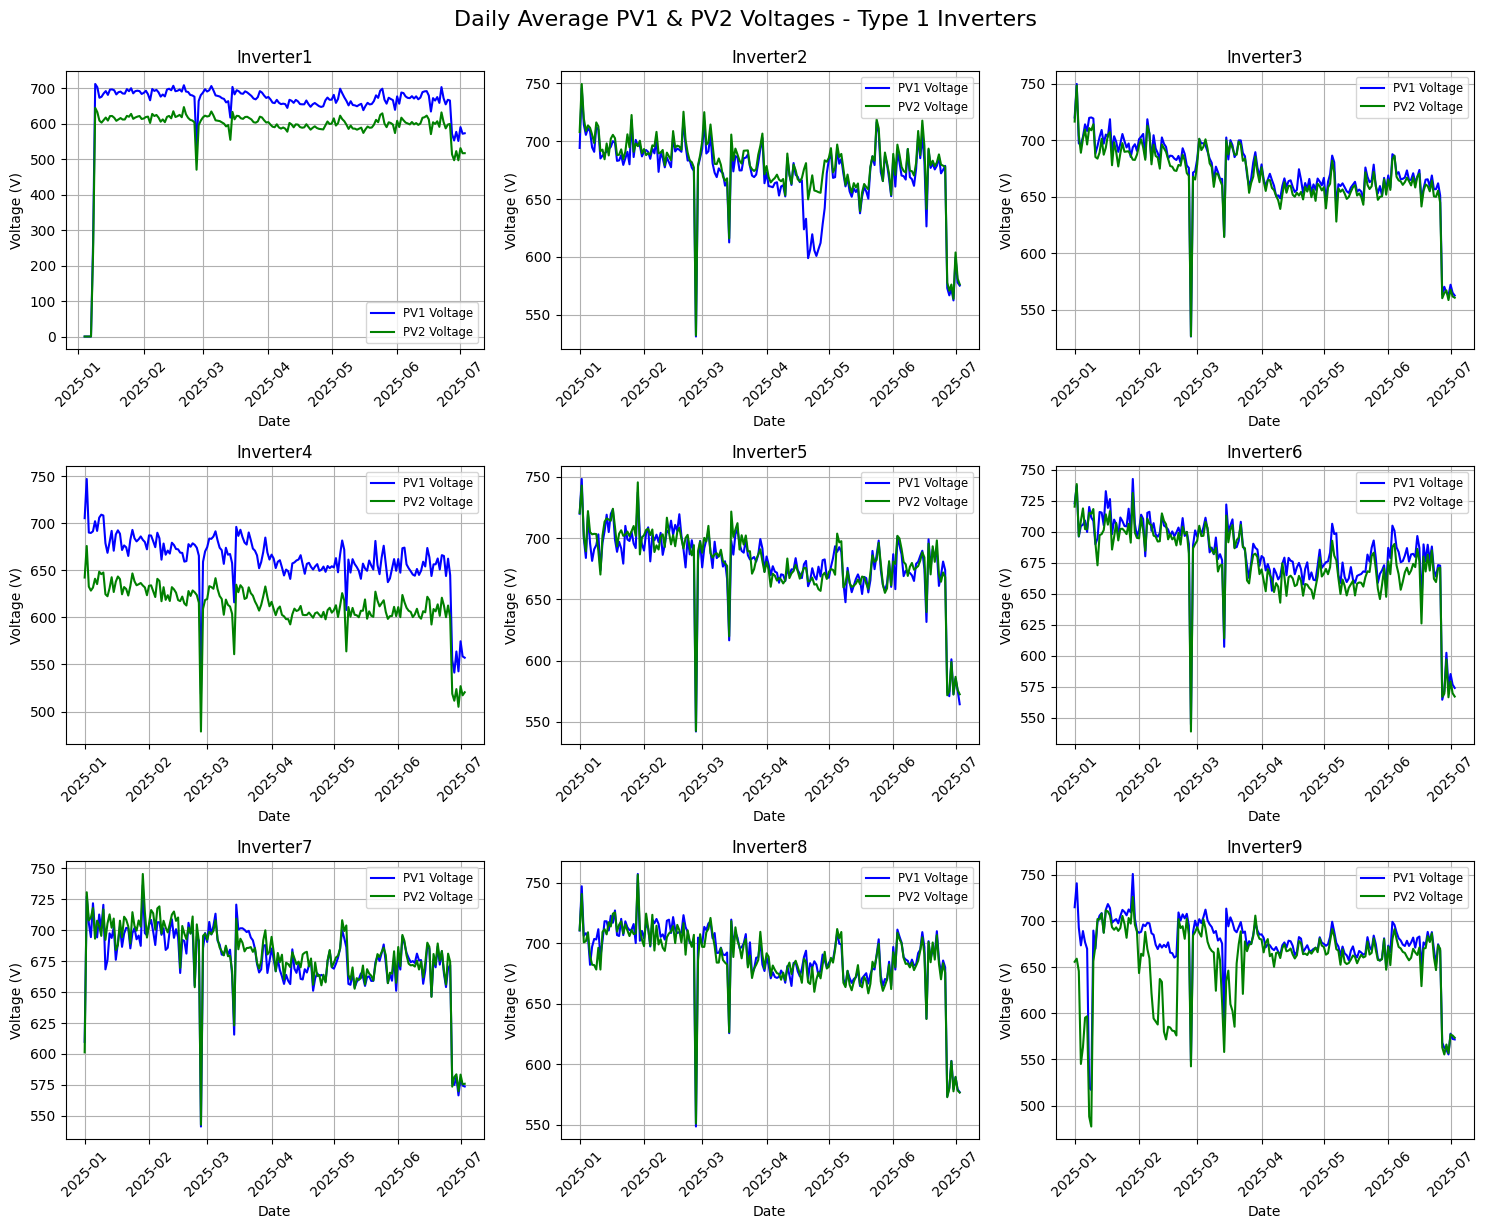

In [ ]:
plot_daily_voltage_type1(df_2)

In [ ]:
type1_summary_df_2 = type1_inverter_mismatch_and_drop_analysis(df_2, type1_inverters_2)
display(type1_summary_df_2)

Inverter  Mean Mismatch % (V)  Mismatch Std Dev % (V)  \
0  Inverter1                10.23                    1.85   
1  Inverter2                 1.70                    3.80   
2  Inverter3                 1.32                    4.44   
3  Inverter4                 7.94                    2.67   
4  Inverter5                 2.04                    6.75   
5  Inverter6                 1.90                    5.79   
6  Inverter7                 1.79                    5.24   
7  Inverter8                 1.67                    6.22   
8  Inverter9                 4.09                    6.07   

   % of Mismatch > 10% (V)  Sudden Drops PV1 (V)  Sudden Drops PV2 (V)  \
0                    54.75                    86                    80   
1                     1.97                   314                   310   
2                     0.73                   303                   289   
3                    15.08                   112                   110   
4                     2.10                   357                   357   
5                     1.63                   327                   294   
6                     0.81                   282                   272   
7                     1.50                   312                   304   
8                    14.42                    70                   126   

   Daily Mean Drops PV1 (>10%) (V)  Daily Mean Drops PV2 (>10%) (V)  \
0                              119                              119   
1                                0                                0   
2                                0                                0   
3                                0                                0   
4                                0                                0   
5                                0                                0   
6                                0                                0   
7                                0                                0   
8                               19                               19   

   Mean Mismatch % (C)  Mismatch Std Dev % (C)  % of Mismatch > 10% (C)  \
0                50.69                    7.11                    93.15   
1                 3.61                    6.50                     6.52   
2                 2.56                    7.18                     4.58   
3                51.94                   11.40                    96.55   
4                13.29                   12.20                    44.25   
5                 5.71                    9.80                    12.67   
6                 3.64                    7.50                     6.38   
7                 8.88                    9.34                    25.49   
8                55.56                   10.46                    96.81   

   Sudden Drops PV1 (C)  Sudden Drops PV2 (C)  \
0                  3232                  3354   
1                  3490                  3418   
2                  3286                  3281   
3                  3066                  3092   
4                  3555                  3366   
5                  3298                  3202   
6                  3334                  3312   
7                  3346                  3260   
8                  3296                  3223   

   Daily Mean Drops PV1 (>10%) (C)  Daily Mean Drops PV2 (>10%) (C)  
0                              177                              177  
1                                0                                0  
2                                0                                0  
3                              184                              184  
4                               54                               54  
5                                0                                0  
6                                1                                1  
7                               21                               21  
8                              184                              184

⚠️ Voltage Outliers:

📊 Total values > 1000 V across all inverters: 0
📊 Total values < 0 V across all inverters: 0


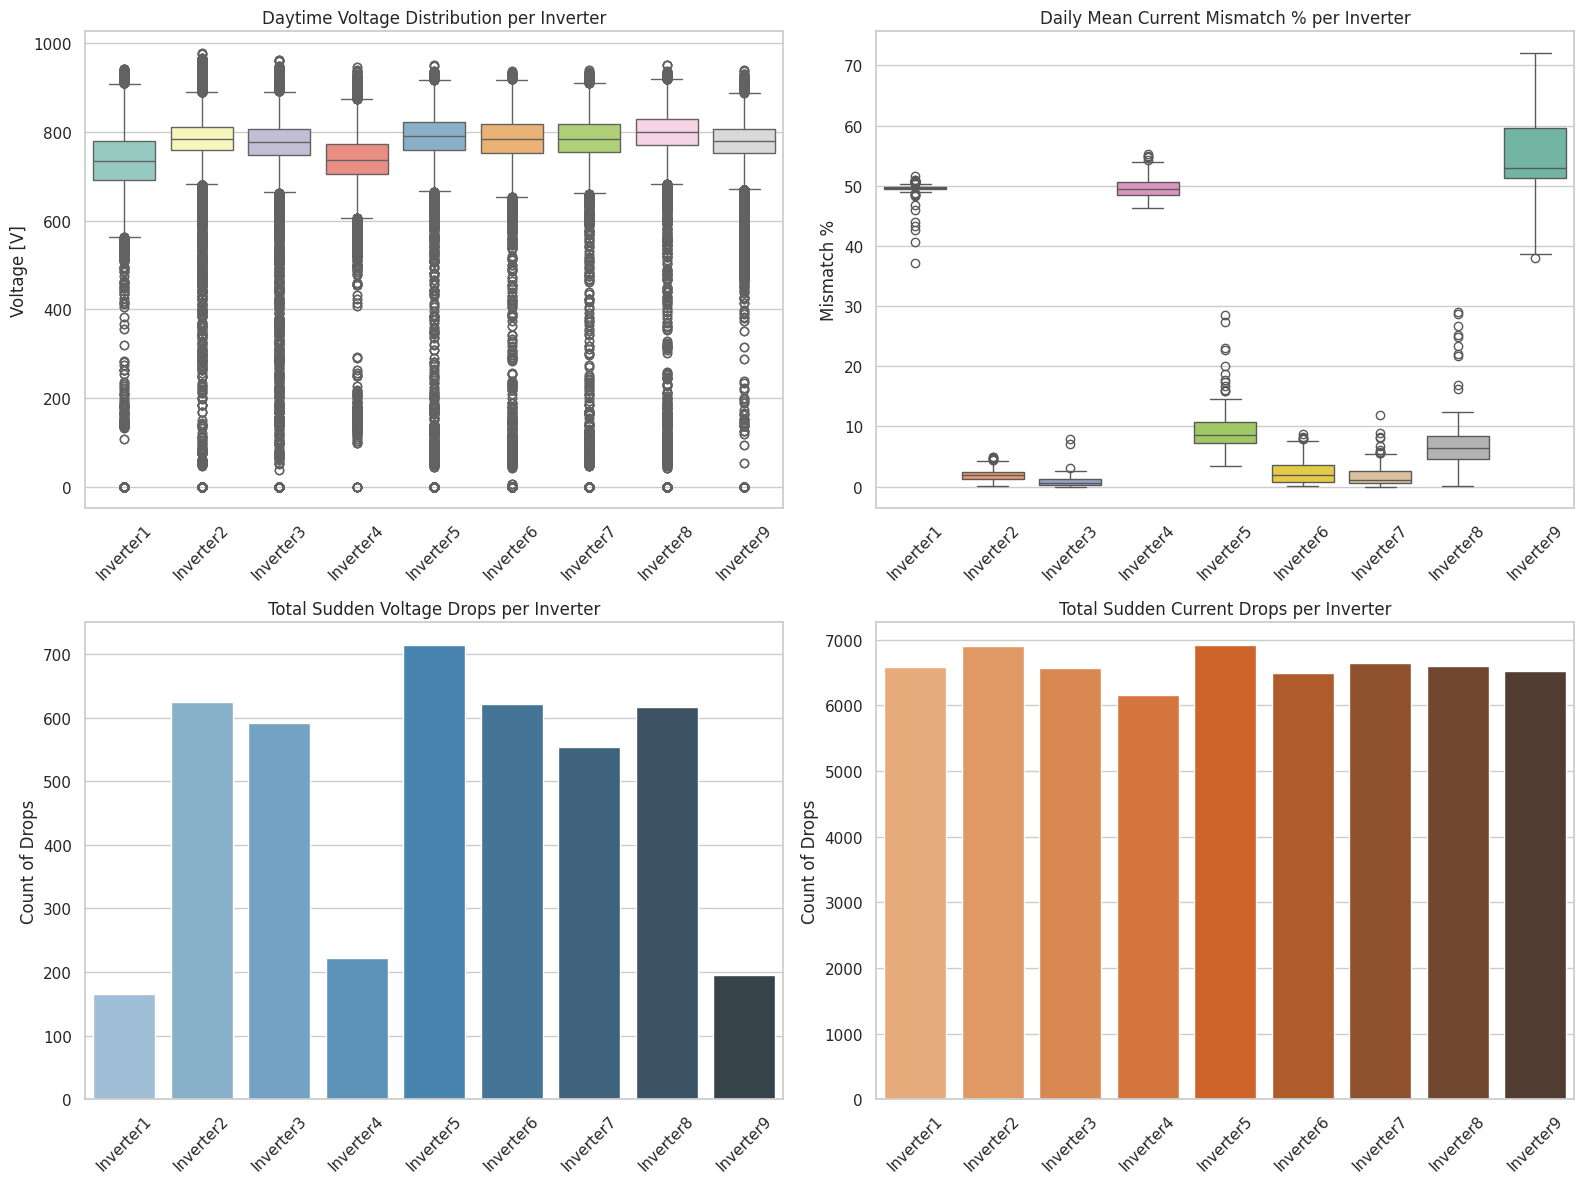

In [ ]:
plot_inverter_voltage_current_summary(df_2, type1_summary_df_2)

In [ ]:
outlier_df_2=plot_type2_string_summary( type2_df, type2_inverters_full,return_outliers=False)
display(outlier_df)

In [ ]:
new_data_loc_2 = '/content/drive/My Drive/FPE Data/LOG BOOKS/Star wire Ext Phase 2/combined_with_PR_CUF.xlsx'
data_starwire_ext_ph2 = pd.read_excel(new_data_loc_2)

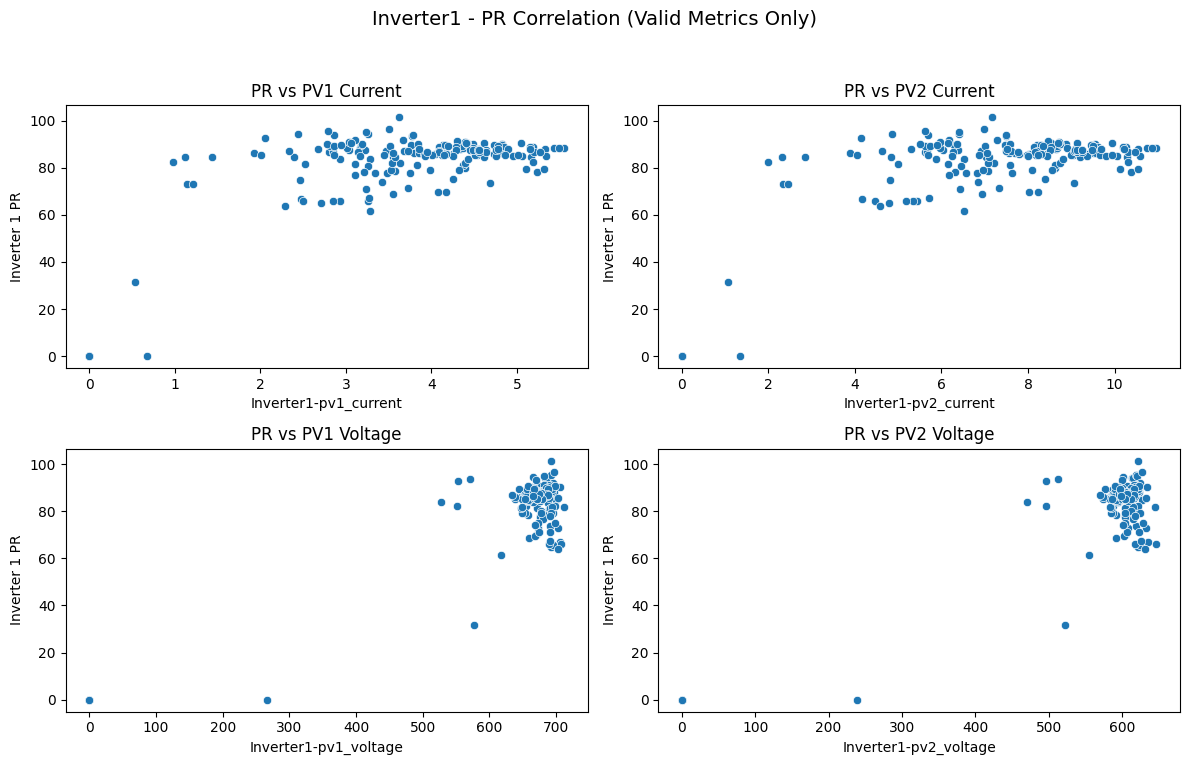

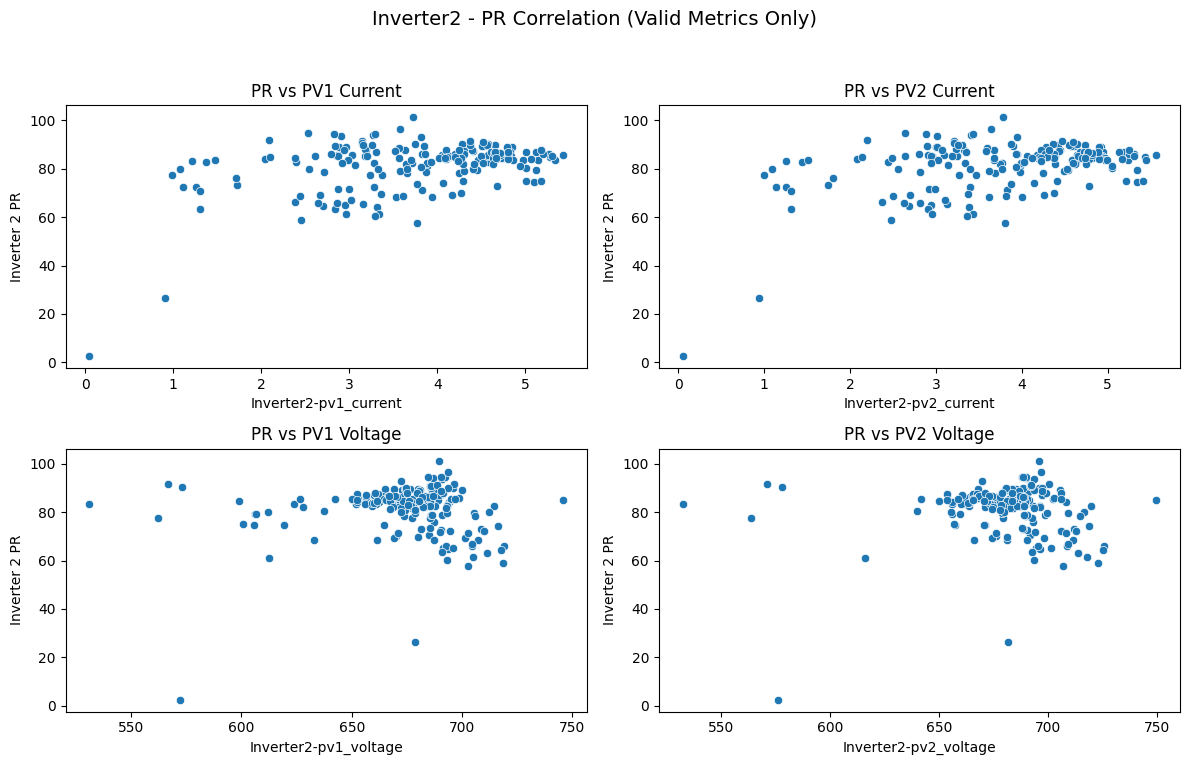

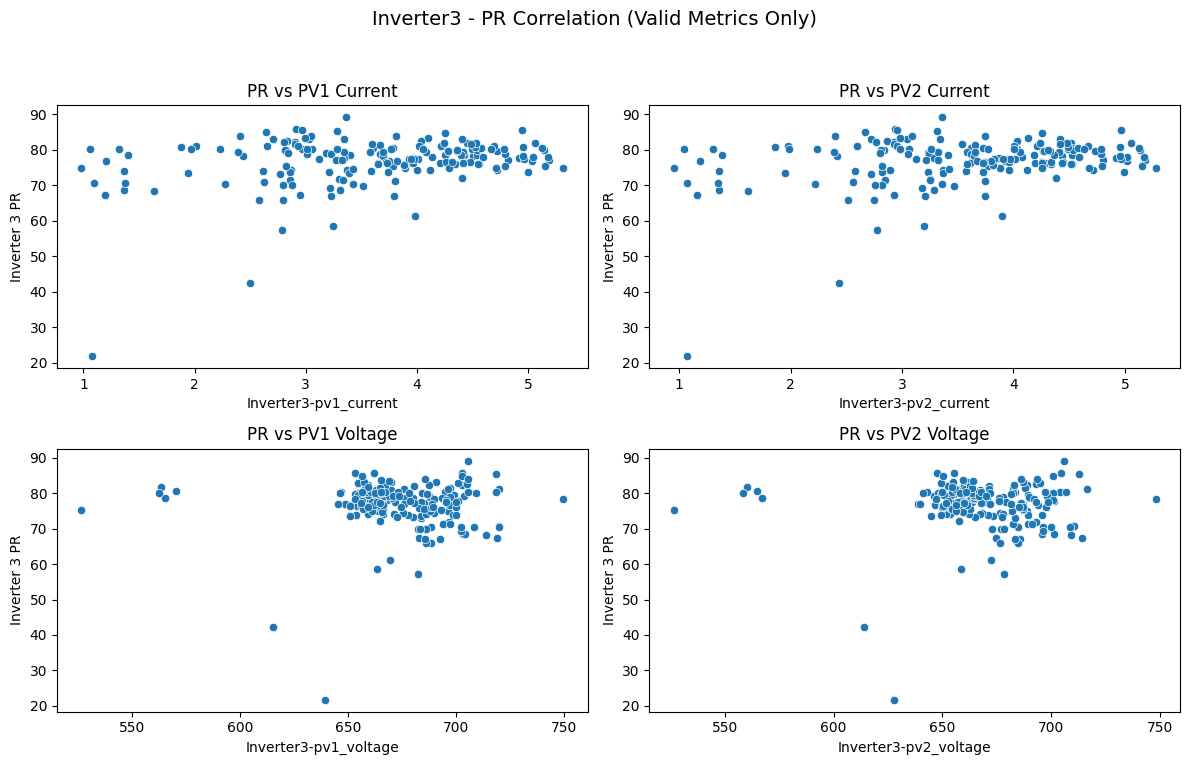

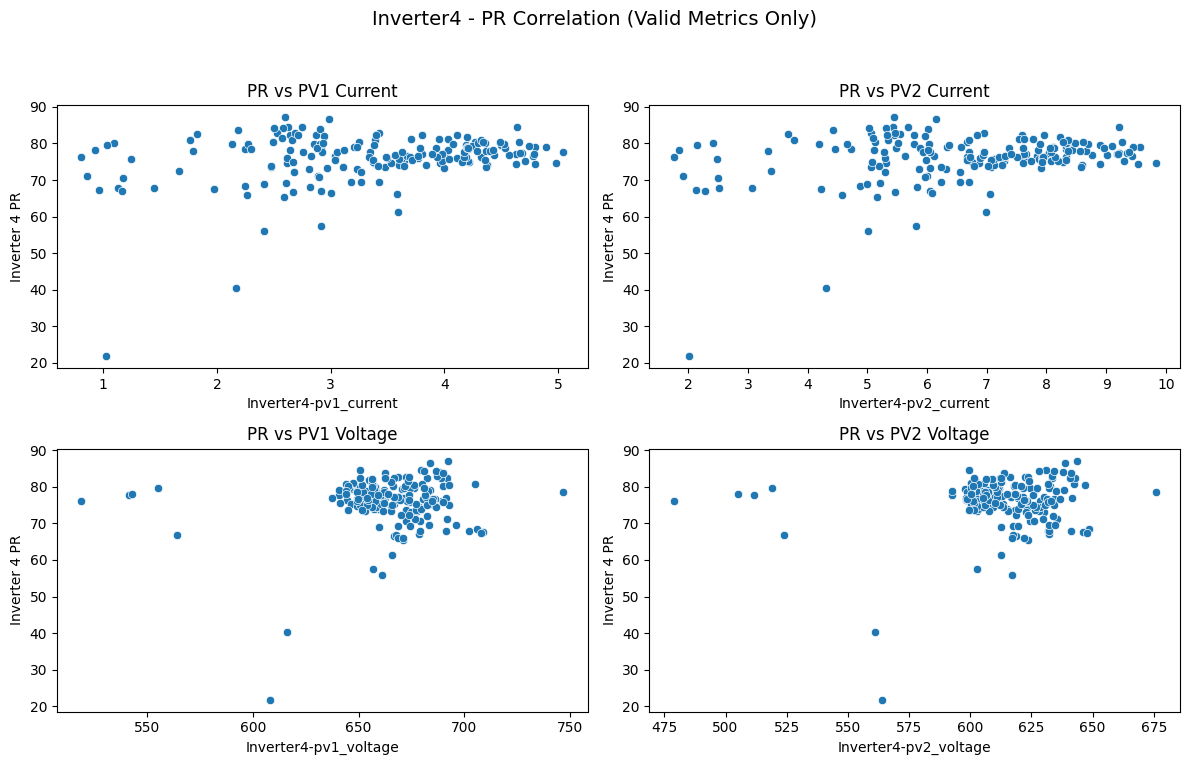

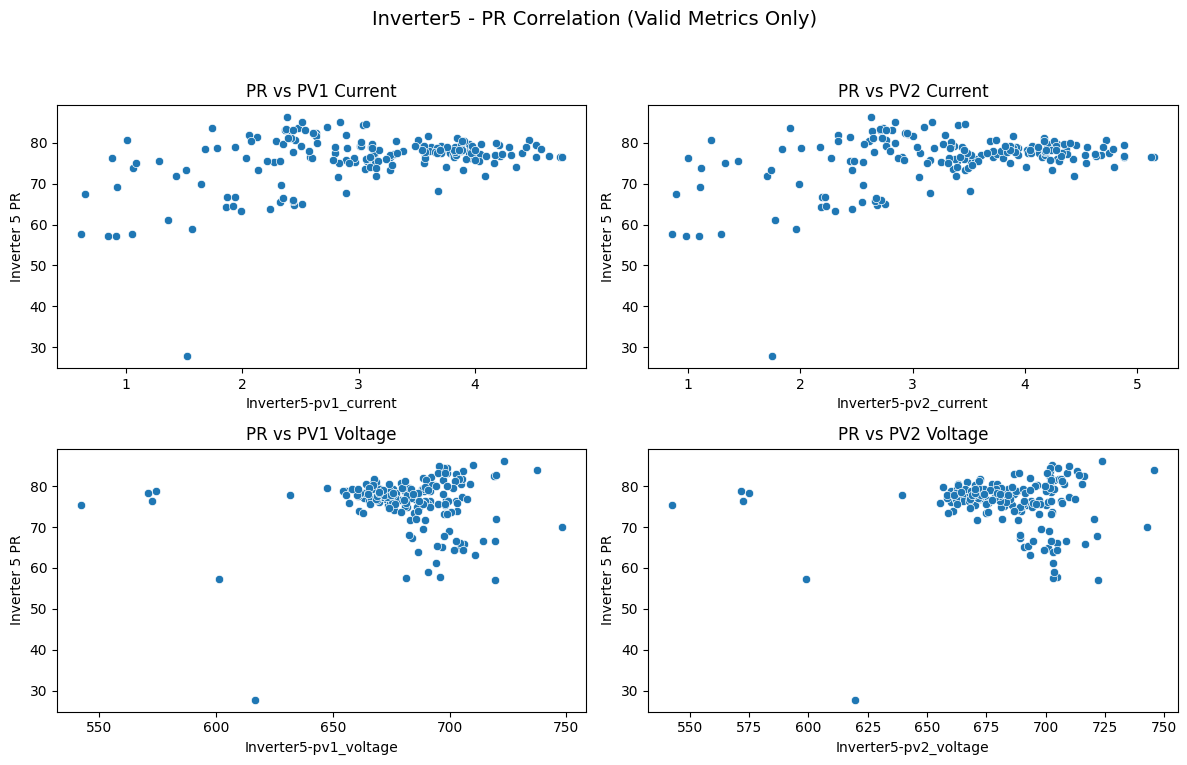

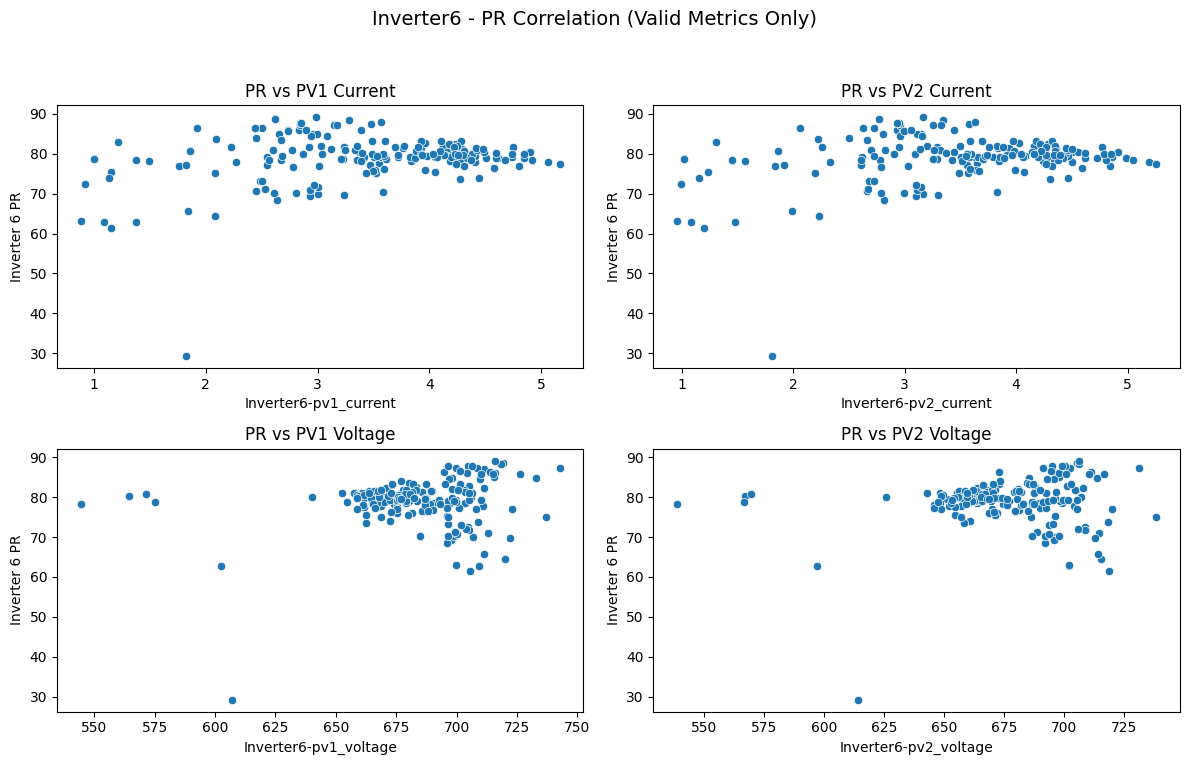

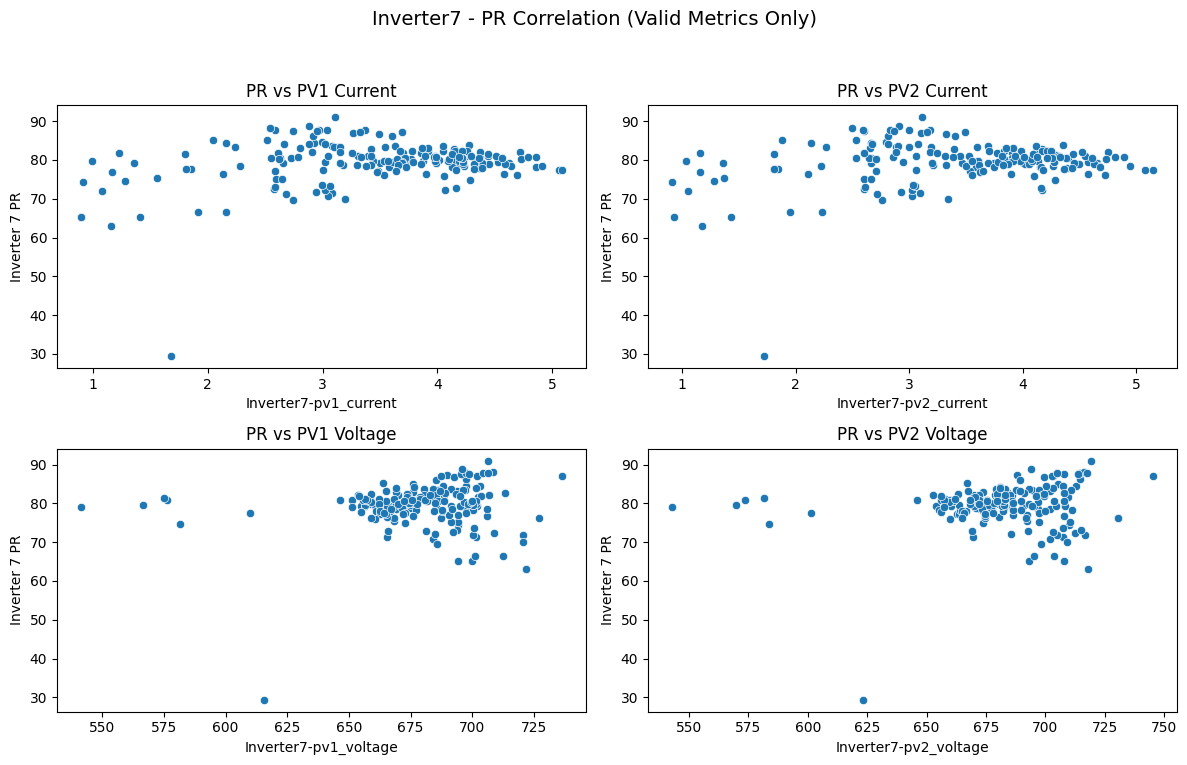

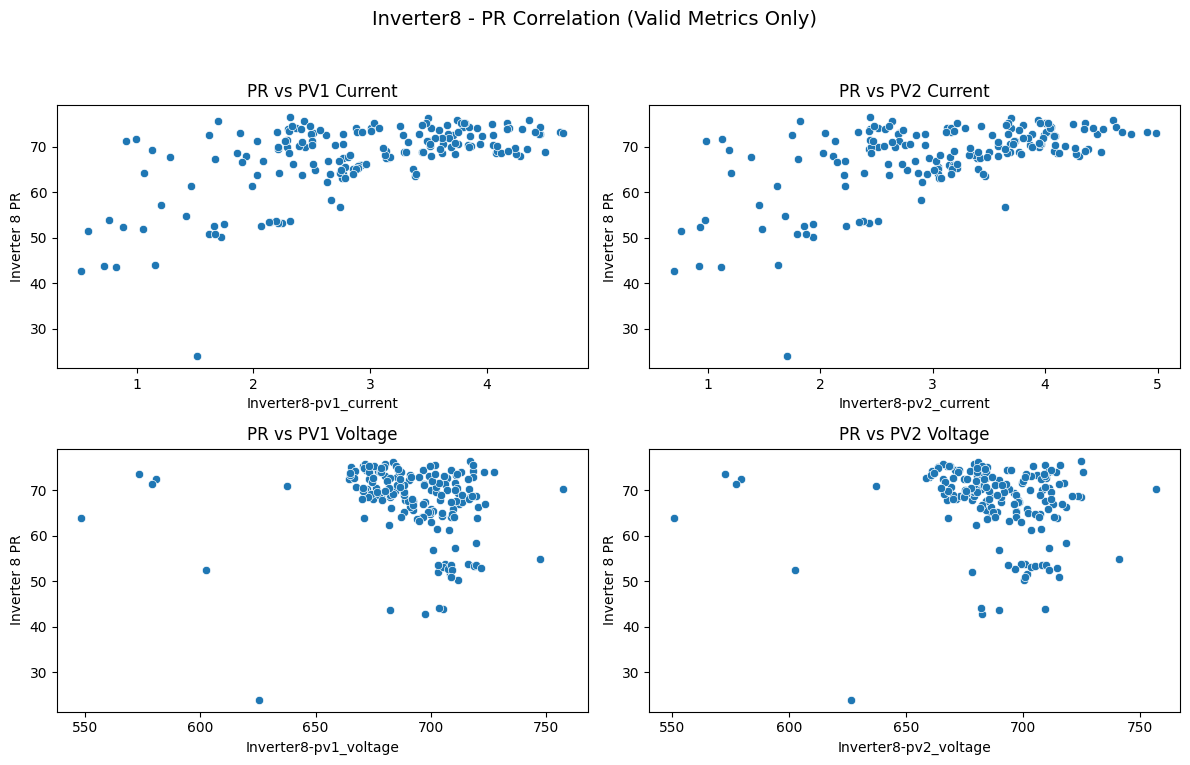

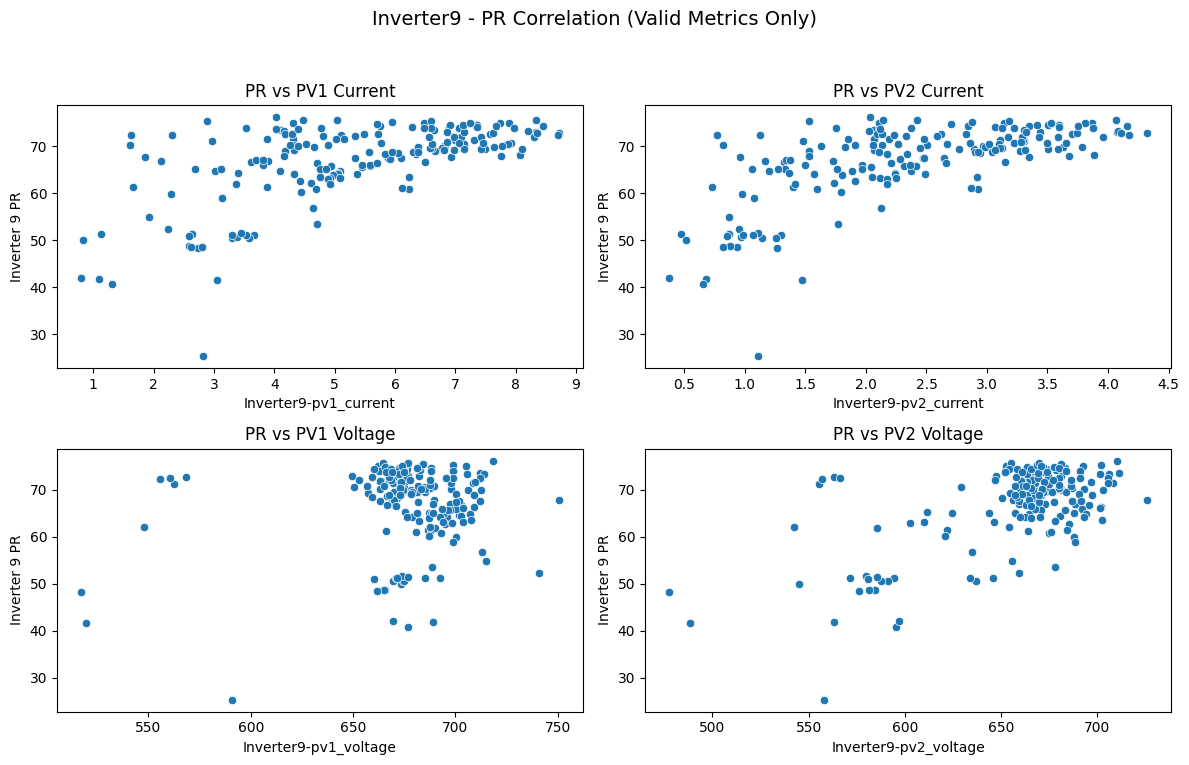

In [ ]:
summary_list_2 = []

for inverter in type1_inverters_2:
    summary = plot_pr_correlation_type1_v2_final_clean(df_2, data_starwire_ext_ph2, inverter)
    summary_list_2.append(summary)

summary_df_type1_2 = pd.DataFrame(summary_list_2)

In [ ]:
display(summary_df_type1_2)

Inverter Skipped Metrics  PV1 Current Outliers Replaced  \
0  Inverter1              []                              0   
1  Inverter2              []                              0   
2  Inverter3              []                              0   
3  Inverter4              []                              0   
4  Inverter5              []                              0   
5  Inverter6              []                              0   
6  Inverter7              []                              0   
7  Inverter8              []                              0   
8  Inverter9              []                              0   

   PV2 Current Outliers Replaced  PV1 Voltage Outliers Replaced  \
0                              0                              0   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   
5                              0                              0   
6                              0                              0   
7                              0                              0   
8                              0                              0   

   PV2 Voltage Outliers Replaced  
0                              0  
1                              0  
2                              0  
3                              0  
4                              0  
5                              0  
6                              0  
7                              0  
8                              0

In [ ]:
type1_final_2 = combine_type1_health_summary(
     type1_summary_df_2,
     summary_df_type1_2,
     {
         'mismatch_volt_pct': 10,
         'mismatch_curr_pct': 10,
         'drop_voltage_count': 50,
         'drop_current_count': 50,
         'outlier_count': 30
     }
 )
display(type1_final_2)
type1_final_2.to_excel("Star Wire Ext Ph 2 Health Summary.xlsx", index=False)
files.download("Star Wire Ext Ph 2 Health Summary.xlsx")

Inverter  High_Volt_Mismatch  High_Curr_Mismatch  Frequent_Volt_Drops  \
0  Inverter1                True                True                 True   
1  Inverter2               False               False                 True   
2  Inverter3               False               False                 True   
3  Inverter4               False                True                 True   
4  Inverter5               False                True                 True   
5  Inverter6               False               False                 True   
6  Inverter7               False               False                 True   
7  Inverter8               False               False                 True   
8  Inverter9               False                True                 True   

   Frequent_Curr_Drops High_Volt_Mismatch_Reason High_Curr_Mismatch_Reason  \
0                 True                     10.2%                     50.7%   
1                 True                         -                         -   
2                 True                         -                         -   
3                 True                         -                     51.9%   
4                 True                         -                     13.3%   
5                 True                         -                         -   
6                 True                         -                         -   
7                 True                         -                         -   
8                 True                         -                     55.6%   

  Frequent_Volt_Drops_Reason Frequent_Curr_Drops_Reason High_Outliers_Reason  \
0           Drops V1+V2: 166          Drops C1+C2: 6586                    -   
1           Drops V1+V2: 624          Drops C1+C2: 6908                    -   
2           Drops V1+V2: 592          Drops C1+C2: 6567                    -   
3           Drops V1+V2: 222          Drops C1+C2: 6158                    -   
4           Drops V1+V2: 714          Drops C1+C2: 6921                    -   
5           Drops V1+V2: 621          Drops C1+C2: 6500                    -   
6           Drops V1+V2: 554          Drops C1+C2: 6646                    -   
7           Drops V1+V2: 616          Drops C1+C2: 6606                    -   
8           Drops V1+V2: 196          Drops C1+C2: 6519                    -   

   High_Outliers High_Outliers_Reason Overall_Health  \
0          False                    -      Unhealthy   
1          False                    -        Healthy   
2          False                    -        Healthy   
3          False                    -      Unhealthy   
4          False                    -      Unhealthy   
5          False                    -        Healthy   
6          False                    -        Healthy   
7          False                    -        Healthy   
8          False                    -      Unhealthy   

                                      Overall_Reason  
0  10.2%; 50.7%; Drops V1+V2: 166; Drops C1+C2: 6586  
1                Drops V1+V2: 624; Drops C1+C2: 6908  
2                Drops V1+V2: 592; Drops C1+C2: 6567  
3         51.9%; Drops V1+V2: 222; Drops C1+C2: 6158  
4         13.3%; Drops V1+V2: 714; Drops C1+C2: 6921  
5                Drops V1+V2: 621; Drops C1+C2: 6500  
6                Drops V1+V2: 554; Drops C1+C2: 6646  
7                Drops V1+V2: 616; Drops C1+C2: 6606  
8         55.6%; Drops V1+V2: 196; Drops C1+C2: 6519

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 2. **DMART WARDHA**

In [ ]:
combine_excel_yearwise(
    input_folder="/content/drive/MyDrive/FPE Data/DMART WARDHA WEEKLY/2025",
    output_path="/content/drive/MyDrive/FPE Data/DMART WARDHA WEEKLY/COMBINED DATA/DMART WARDHA 2025.xlsx"
)

✅ Saved combined data to: /content/drive/MyDrive/FPE Data/DMART WARDHA WEEKLY/COMBINED DATA/DMART WARDHA 2025.xlsx


In [ ]:
combine_excel_yearwise(
    input_folder="/content/drive/MyDrive/FPE Data/DMART WARDHA WEEKLY/2024",
    output_path="/content/drive/MyDrive/FPE Data/DMART WARDHA WEEKLY/COMBINED DATA/DMART WARDHA 2024.xlsx"
)

✅ Saved combined data to: /content/drive/MyDrive/FPE Data/DMART WARDHA WEEKLY/COMBINED DATA/DMART WARDHA 2024.xlsx


In [ ]:
combine_excel_yearwise(
    input_folder="/content/drive/MyDrive/FPE Data/DMART WARDHA WEEKLY/2023",
    output_path="/content/drive/MyDrive/FPE Data/DMART WARDHA WEEKLY/COMBINED DATA/DMART WARDHA 2023.xlsx"
)

✅ Saved combined data to: /content/drive/MyDrive/FPE Data/DMART WARDHA WEEKLY/COMBINED DATA/DMART WARDHA 2023.xlsx


In [ ]:
combine_excel_yearwise(
    input_folder="/content/drive/MyDrive/FPE Data/DMART WARDHA WEEKLY/2022",
    output_path="/content/drive/MyDrive/FPE Data/DMART WARDHA WEEKLY/COMBINED DATA/DMART WARDHA 2022.xlsx"
)

✅ Saved combined data to: /content/drive/MyDrive/FPE Data/DMART WARDHA WEEKLY/COMBINED DATA/DMART WARDHA 2022.xlsx


In [ ]:
import glob
def combine_excels_in_folder(folder_path, output_path, sort_by_time=True, verbose=True):
    """
    Combines all Excel files in a folder into a single Excel file and returns the DataFrame.

    Args:
        folder_path (str): Folder containing cleaned .xlsx files.
        output_path (str): Path to save the combined Excel.
        sort_by_time (bool): Whether to sort by 'Time' column if present.
        verbose (bool): Whether to print status messages.

    Returns:
        pd.DataFrame: The combined DataFrame.
    """
    excel_files = glob.glob(os.path.join(folder_path, "*.xlsx")) # HAVE TO REMOVE THE EXTRA GLOB

    if not excel_files:
        print("❌ No Excel files found in folder.")
        return pd.DataFrame()  # return empty df if nothing found

    all_dfs = []
    for file in sorted(excel_files):
        try:
            df = pd.read_excel(file)
            all_dfs.append(df)
            if verbose:
                print(f"📄 Loaded: {os.path.basename(file)} → {df.shape[0]} rows")
        except Exception as e:
            print(f"⚠️ Error reading {file}: {e}")

    df_combined = pd.concat(all_dfs, ignore_index=True)

    if sort_by_time and "Time" in df_combined.columns:
        df_combined["Time"] = pd.to_datetime(df_combined["Time"], errors='coerce')
        df_combined = df_combined.dropna(subset=["Time"])
        df_combined = df_combined.sort_values("Time")

    df_combined.to_excel(output_path, index=False)

    print(f"\n✅ Combined file saved at: {output_path}")
    print(f"🔢 Total combined rows: {df_combined.shape[0]}")

    return df_combined
def fast_combine_excels_by_year(folder_path, output_path, verbose=True):
    """
    Combines Excel files in a folder in the order of year embedded in filenames (e.g., '2022.xlsx', '2023.xlsx').

    Args:
        folder_path (str): Folder containing cleaned .xlsx files with year in the filename.
        output_path (str): Path to save the combined Excel file.
        verbose (bool): Print progress info.

    Returns:
        pd.DataFrame: Combined DataFrame without re-sorting.
    """
    excel_files = sorted(glob.glob(os.path.join(folder_path, "*.xlsx")))

    # Prioritize files with 4-digit years in filename
    excel_files = sorted(excel_files, key=lambda x: int(os.path.basename(x)[-9:-5]) if os.path.basename(x)[-9:-5].isdigit() else 0)

    all_dfs = []
    for file in excel_files:
        try:
            df = pd.read_excel(file)
            all_dfs.append(df)
            if verbose:
                print(f"📄 Loaded: {os.path.basename(file)} → {df.shape[0]} rows")
        except Exception as e:
            print(f"⚠️ Failed to read {file}: {e}")

    df_combined = pd.concat(all_dfs, ignore_index=True)
    df_combined.to_excel(output_path, index=False)

    print(f"\n✅ Combined file saved at: {output_path}")
    print(f"🔢 Total rows: {df_combined.shape[0]}")

    return df_combined

In [ ]:
df_final = combine_excels_in_folder(
    folder_path="/content/drive/MyDrive/FPE Data/DMART WARDHA WEEKLY/COMBINED DATA",
    output_path="/content/drive/MyDrive/FPE Data/DMART WARDHA WEEKLY/DMART_WARDHA_ALL_YEARS.xlsx"
)
df_final.head()

📄 Loaded: DMART WARDHA 2022.xlsx → 57117 rows
📄 Loaded: DMART WARDHA 2023.xlsx → 61092 rows
📄 Loaded: DMART WARDHA 2024.xlsx → 61435 rows
📄 Loaded: DMART WARDHA 2025.xlsx → 32703 rows

✅ Combined file saved at: /content/drive/MyDrive/FPE Data/DMART WARDHA WEEKLY/DMART_WARDHA_ALL_YEARS.xlsx
🔢 Total combined rows: 212347


Time  Inverter1-pv1_current  Inverter2-pv1_current  \
43476 2022-02-01 17:20:00                    1.4                    1.2   
43477 2022-02-01 17:25:00                    1.2                    1.0   
43478 2022-02-01 17:30:00                    1.0                    0.8   
43479 2022-02-01 17:35:00                    0.5                    0.4   
43480 2022-02-01 17:40:00                    0.4                    0.3   

       Inverter3-pv1_current  Inverter1-string1  Inverter2-string1  \
43476                    0.0                1.4                1.2   
43477                    0.0                1.2                1.0   
43478                    0.0                1.0                0.8   
43479                    0.0                0.5                0.4   
43480                    0.0                0.0                0.3   

       Inverter3-string1  Inverter1-string2  Inverter2-string2  \
43476                0.0                NaN                NaN   
43477                0.0                NaN                NaN   
43478                0.0                NaN                NaN   
43479                0.0                NaN                NaN   
43480                0.0                NaN                NaN   

       Inverter1-string3  ...  Inverter4-limit_percent  Inverter4-kwh_total  \
43476                1.4  ...                    100.0                  0.0   
43477                1.2  ...                    100.0                  0.0   
43478                0.9  ...                    100.0                  0.0   
43479                0.5  ...                    100.0                  0.0   
43480                0.0  ...                    100.0                  0.0   

       Inverter2-string9  Inverter1-pv2_voltage  Inverter1-pv2_current  \
43476                NaN                    NaN                    NaN   
43477                NaN                    NaN                    NaN   
43478                NaN                    NaN                    NaN   
43479                NaN                    NaN                    NaN   
43480                NaN                    NaN                    NaN   

       Inverter2-string11  Inverter1-pv2_power  Inverter2-pv2_current  \
43476                 NaN                  NaN                    NaN   
43477                 NaN                  NaN                    NaN   
43478                 NaN                  NaN                    NaN   
43479                 NaN                  NaN                    NaN   
43480                 NaN                  NaN                    NaN   

       Inverter2-pv2_power  Inverter2-pv2_voltage  
43476                  NaN                    NaN  
43477                  NaN                    NaN  
43478                  NaN                    NaN  
43479                  NaN                    NaN  
43480                  NaN                    NaN  

[5 rows x 68 columns]

In [ ]:
file_path_wardha = '/content/drive/MyDrive/FPE Data/DMART WARDHA WEEKLY/DMART_WARDHA_ALL_YEARS.xlsx'
df_3 = pd.read_excel(file_path_wardha)

In [ ]:
df_3.columns = df_3.columns.astype(str)
type1_inverters_3, type2_inverters_3,hybird_inverters_3=split_inverters_by_type(df_3)


🔎 Inverter Type Counts: {'type2': 3, 'type1': 1}

⚙️ Type 1 Inverters: 1
⚙️ Type 2 Inverters: 3
⚙️ Hybrid Inverters: 0


In [ ]:
type1_cols_3 = ['Time']
for inv in type1_inverters_3:
    prefix = f"{inv}-"
    matching_cols = [col for col in df_3.columns if col.startswith(prefix)]
    type1_cols_3.extend(matching_cols)  # ✅ Add matching columns to the list

# Filter the columns that actually exist in the DataFrame
existing_cols = [col for col in type1_cols_3 if col in df_3.columns]

# Now safely create the DataFrame
type1_df_3 = df_3[existing_cols]

type2_cols_3 = ['Time']
for inv in type2_inverters_3:
    prefix = f"{inv}-"
    matching_cols = [col for col in df_3.columns if col.startswith(prefix)]
    type2_cols_3.extend(matching_cols)  # ✅ Add matching columns

existing_cols_type2 = [col for col in type2_cols_3 if col in df_3.columns]
type2_df_3 = df_3[existing_cols_type2]

#type1_df_3.to_excel('/content/drive/MyDrive/FPE Data/DMART WARDHA WEEKLY/Type1_Full_Inverter_Data_WARDHA.xlsx', index=False)
#type2_df_3.to_excel('/content/drive/MyDrive/FPE Data/DMART WARDHA WEEKLY/Type2_Full_Inverter_Data_WARDHA.xlsx', index=False)

Plotting 1 Type 1 inverters in 1 rows and 1 columns.



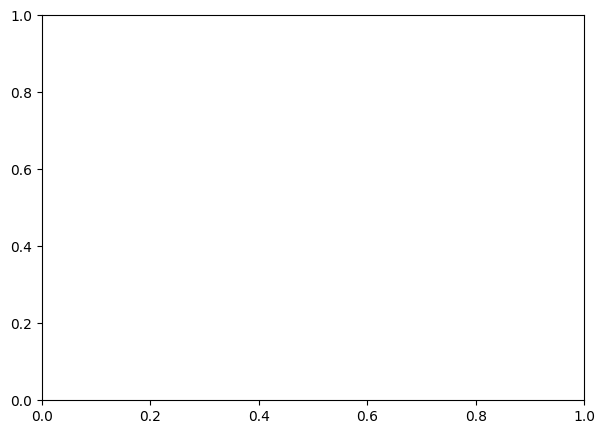

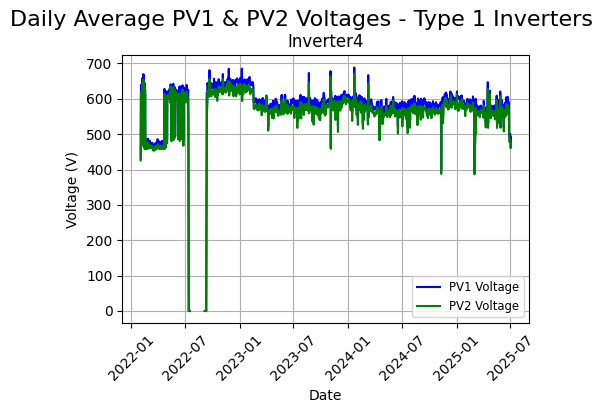

In [ ]:
plot_daily_voltage_type1(type1_df_3)

In [ ]:
type1_summary_df_3 = type1_inverter_mismatch_and_drop_analysis(df_3, type1_inverters_3)
display(type1_summary_df_3)

Inverter  Mean Mismatch % (V)  Mismatch Std Dev % (V)  \
0  Inverter4                 3.24                    3.82   

   % of Mismatch > 10% (V)  Sudden Drops PV1 (V)  Sudden Drops PV2 (V)  \
0                     3.33                   595                   390   

   Daily Mean Drops PV1 (>10%) (V)  Daily Mean Drops PV2 (>10%) (V)  \
0                                0                                0   

   Mean Mismatch % (C)  Mismatch Std Dev % (C)  % of Mismatch > 10% (C)  \
0                44.44                     8.7                    94.21   

   Sudden Drops PV1 (C)  Sudden Drops PV2 (C)  \
0                 14074                 13635   

   Daily Mean Drops PV1 (>10%) (C)  Daily Mean Drops PV2 (>10%) (C)  
0                             1187                             1187

⚠️ Voltage Outliers:

🔍 Column: Inverter4-pv1_voltage
  ⚠️ 12 values > 1000 V


Time  Inverter4-pv1_voltage
1126  2022-02-10 10:40:00                 1976.0
3044  2022-02-20 14:45:00                 2005.0
4068  2022-02-25 12:15:00                 2418.0
5320  2022-03-03 10:45:00                 1941.0
11071 2022-03-30 09:15:00                 1672.0
11084 2022-03-30 10:20:00                 2191.0
11319 2022-03-31 11:50:00                 2409.0
11969 2022-04-03 12:15:00                 2189.0
17709 2022-05-01 11:10:00                 2316.0
20486 2022-05-17 08:10:00                 1048.0
21402 2022-05-22 14:40:00                 1863.0
22256 2022-05-27 11:40:00                 2450.0


🔍 Column: Inverter4-pv2_voltage
  ⚠️ 13 values > 1000 V


Time  Inverter4-pv2_voltage
1126  2022-02-10 10:40:00                 1998.5
3044  2022-02-20 14:45:00                 2028.7
4068  2022-02-25 12:15:00                 2451.0
5320  2022-03-03 10:45:00                 1973.1
11071 2022-03-30 09:15:00                 1695.2
11084 2022-03-30 10:20:00                 2236.2
11319 2022-03-31 11:50:00                 2453.3
11969 2022-04-03 12:15:00                 2218.3
17709 2022-05-01 11:10:00                 2365.9
20486 2022-05-17 08:10:00                 1070.8
21402 2022-05-22 14:40:00                 1892.6
22256 2022-05-27 11:40:00                 2480.2
71064 2023-04-01 07:50:00                 7958.0


📊 Total values > 1000 V across all inverters: 25
📊 Total values < 0 V across all inverters: 0


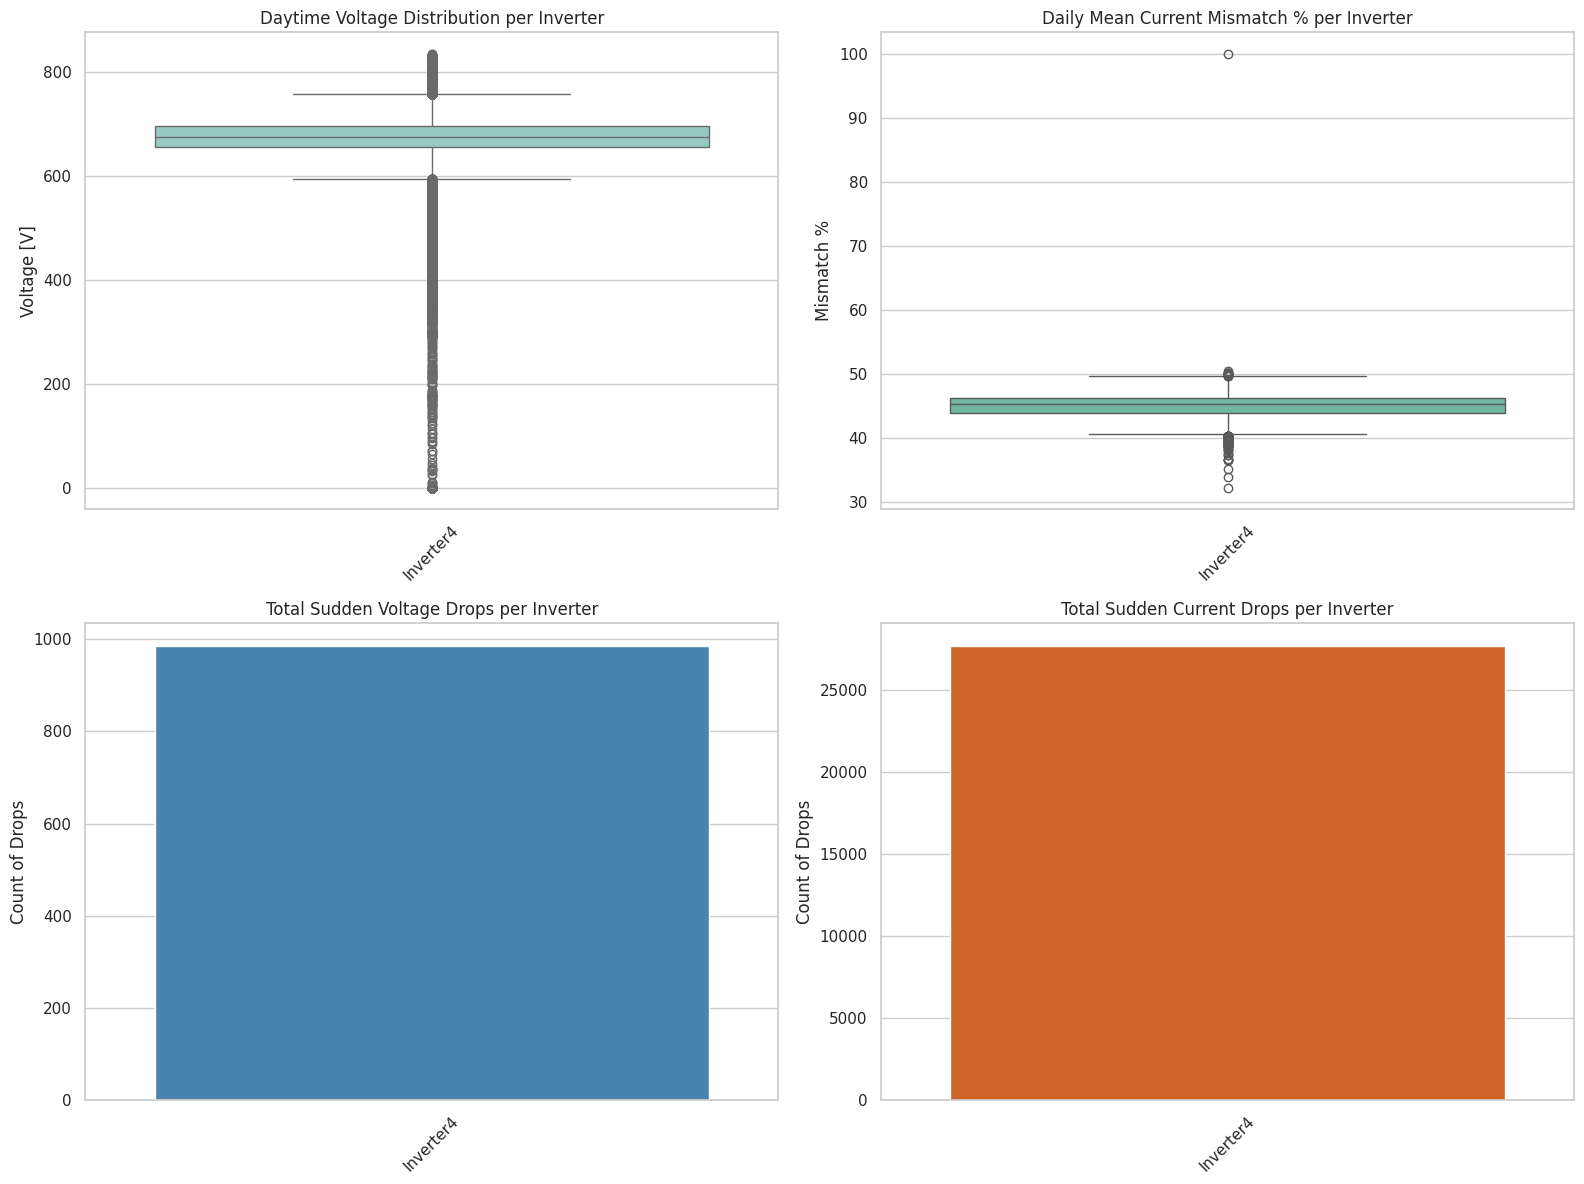

In [ ]:
plot_inverter_voltage_current_summary(type1_df_3, type1_summary_df_3)

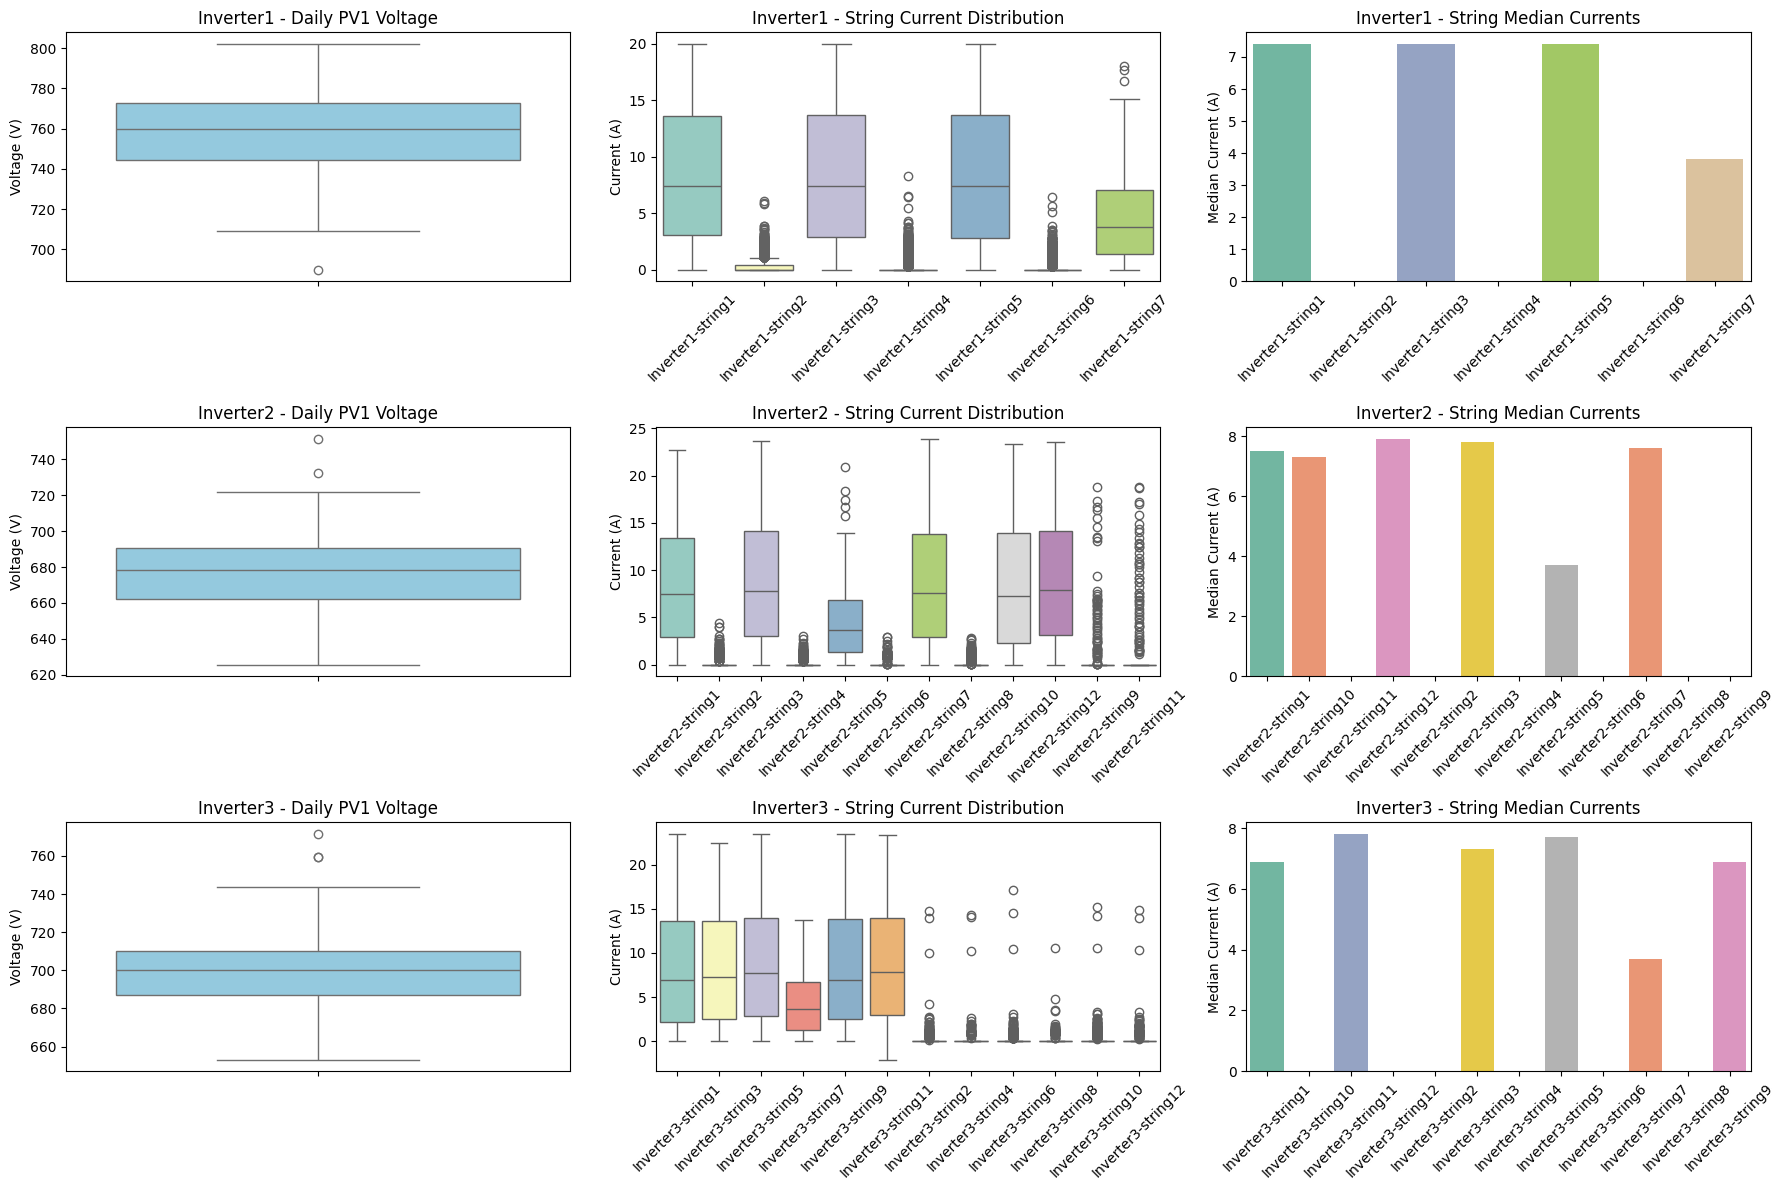

None

In [ ]:
outlier_df_3=plot_type2_string_summary(type2_df_3, type2_inverters_3,return_outliers=False)
display(outlier_df_3)

In [ ]:
type2_summary_df_3 = type2_inverter_string_summary(type2_df_3, type2_inverters_3)
pd.set_option('display.max_colwidth', None)
display(type2_summary_df_3)

Inverter  Sudden Drops PV1 (V)  Daily Mean Drops PV1 (>20%) (V)  \
0  Inverter1                   691                                4   
1  Inverter2                  1497                                4   
2  Inverter3                  2664                                4   

   Total Sudden String Current Drops  \
0                              70075   
1                              89886   
2                              90963   

                                                                                                                                                        Low Performing Strings  \
0                                                                                                   Inverter1-string2, Inverter1-string4, Inverter1-string6, Inverter1-string7   
1                                         Inverter2-string2, Inverter2-string4, Inverter2-string5, Inverter2-string6, Inverter2-string8, Inverter2-string9, Inverter2-string11   
2  Inverter3-string1, Inverter3-string7, Inverter3-string9, Inverter3-string2, Inverter3-string4, Inverter3-string6, Inverter3-string8, Inverter3-string10, Inverter3-string12   

   Mean String Current (A)  Std Dev String Current (A)  CV String Current  
0                     4.66                        5.90              1.265  
1                    29.48                    16138.40            547.483  
2                  3186.82                  2613824.17            820.198

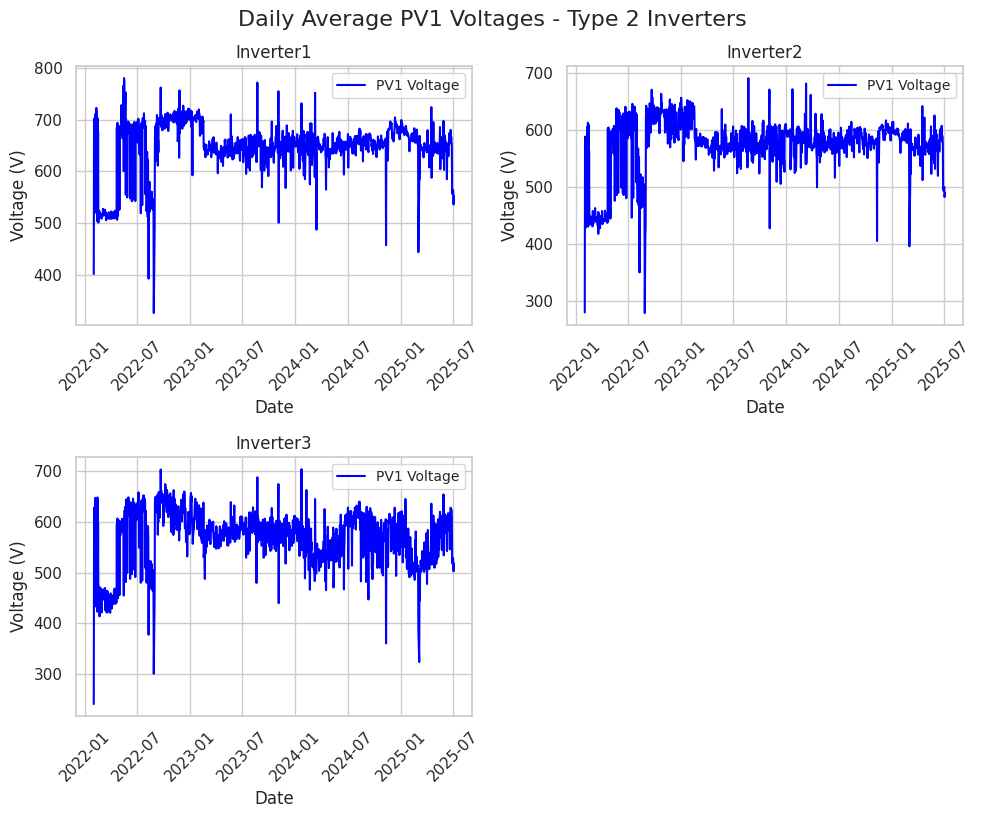

In [ ]:
plot_daily_voltage_type2(type2_df_3)

In [ ]:
data_wardha = '/content/drive/My Drive/FPE Data/LOG BOOKS/NER/combined_with_PR_CUF.xlsx'
data_wardha = pd.read_excel(data_wardha)

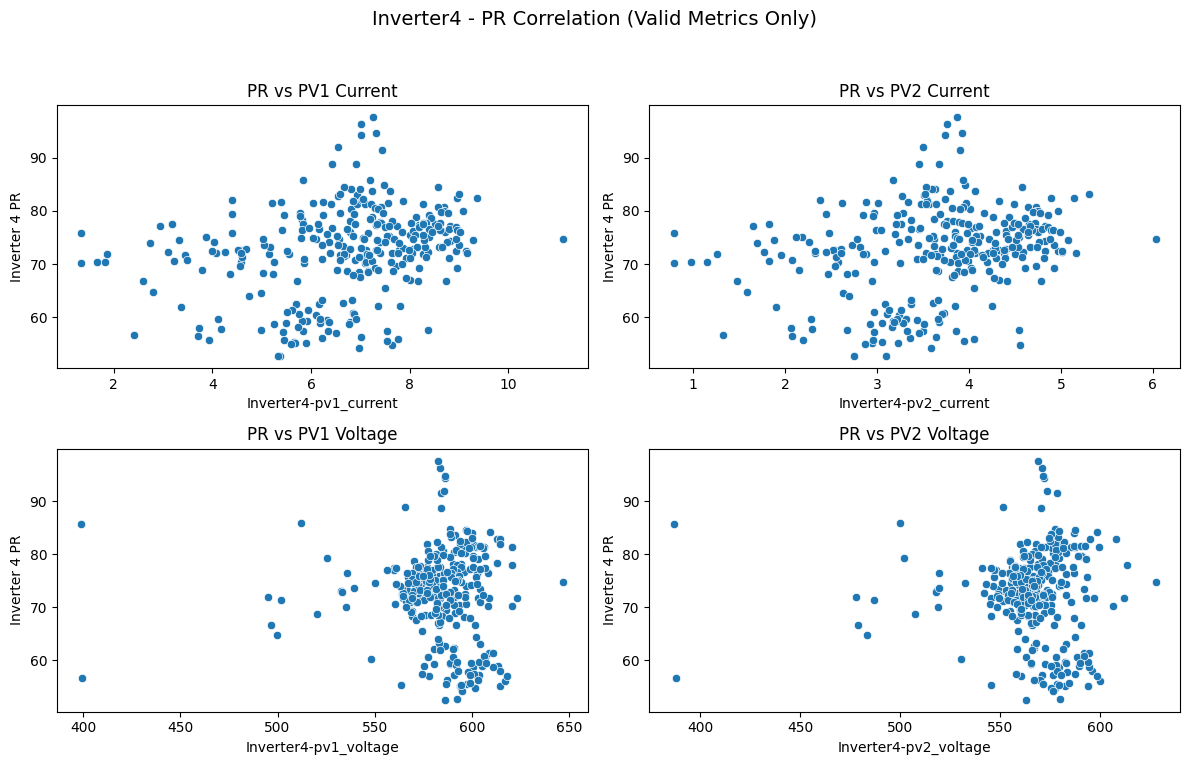

In [ ]:
summary_list_3 = []

for inverter in type1_inverters_3:
    summary = plot_pr_correlation_type1_v2_final_clean(type1_df_3, data_wardha, inverter)
    summary_list_3.append(summary)

summary_df_type1_3 = pd.DataFrame(summary_list_3)

In [ ]:
display(summary_df_type1_3)

Inverter Skipped Metrics  PV1 Current Outliers Replaced  \
0  Inverter4              []                              0   

   PV2 Current Outliers Replaced  PV1 Voltage Outliers Replaced  \
0                              2                             12   

   PV2 Voltage Outliers Replaced  
0                             13

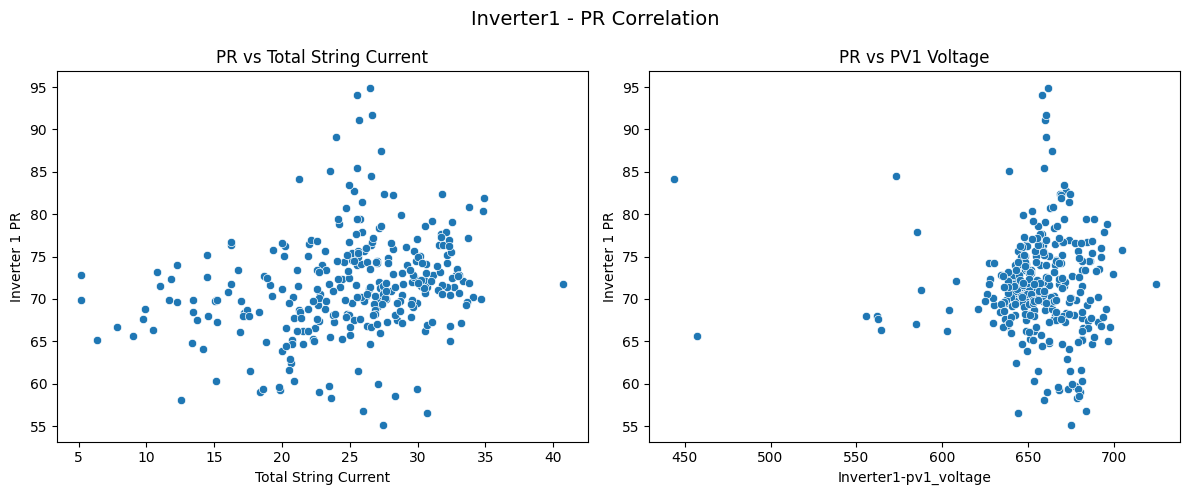

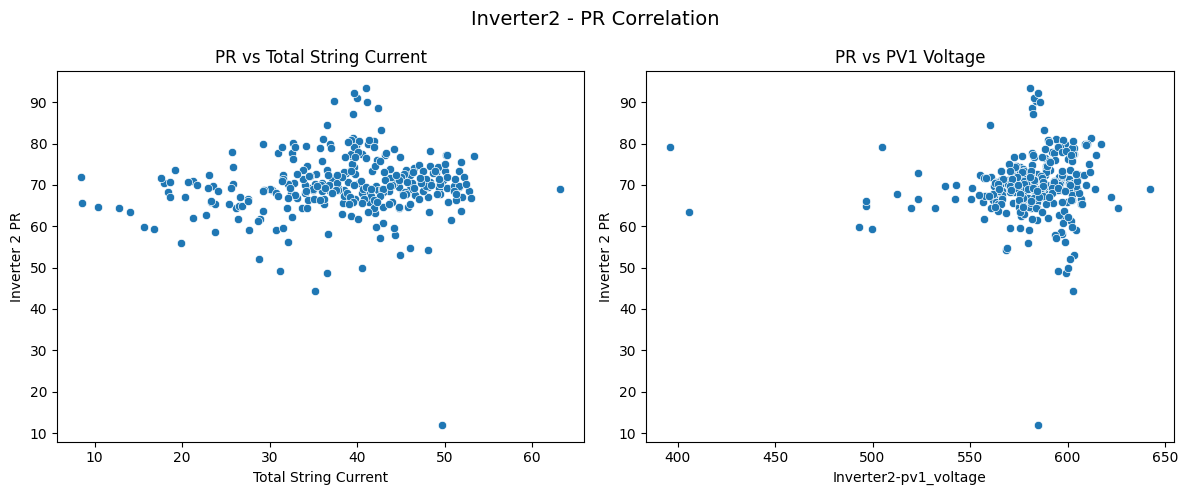

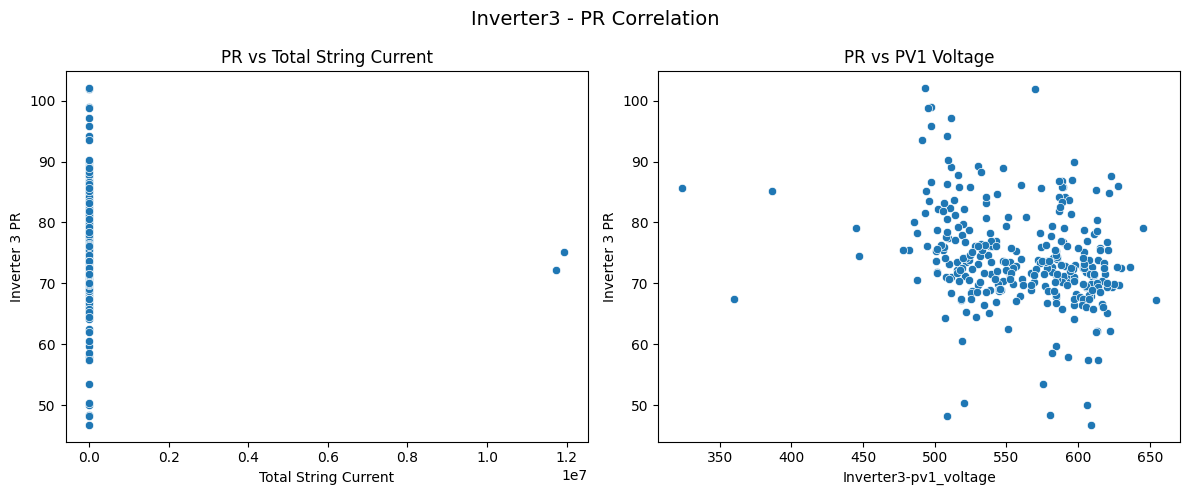

In [ ]:
summary_df_type2_3 = []
for inv in type2_inverters_3:
    summary_wardha_3 = analyze_type2_inverter(type2_df_3, data_wardha, inv)
    plot_type2_inverter_correlation(type2_df_3,data_wardha, inv)
    summary_df_type2_3.append(summary_wardha_3)

summary_df_type2_3 = pd.DataFrame(summary_df_type2_3)

In [ ]:
display(summary_df_type2_3)

Inverter  Unhealthy Strings Count  \
0  Inverter1                        2   
1  Inverter2                        6   
2  Inverter3                        6   

                                                                                                                                                                                      Unhealthy Strings Details  \
0                                                                                                                                            string4 (Zero%=31.1%, Mean=0.01); string6 (Zero%=42.1%, Mean=0.01)   
1    string11 (Zero%=7.9%, Mean=0.02); string2 (Zero%=29.7%, Mean=0.00); string4 (Zero%=43.4%, Mean=0.00); string6 (Zero%=26.2%, Mean=0.00); string8 (Zero%=36.9%, Mean=0.01); string9 (Zero%=13.2%, Mean=0.01)   
2  string10 (Zero%=38.6%, Mean=0.00); string12 (Zero%=33.1%, Mean=0.00); string2 (Zero%=27.6%, Mean=0.00); string4 (Zero%=17.4%, Mean=0.00); string6 (Zero%=28.2%, Mean=0.01); string8 (Zero%=16.2%, Mean=0.00)   

   Avg String Imbalance (Std Dev)  Total Outliers Replaced (Current)  \
0                            3.17                                  0   
1                            2.85                                  4   
2                            2.59                                  3   

   Total Outliers Replaced (Voltage)  
0                                  0  
1                                  0  
2                                  0

In [ ]:
type1_final_3 = combine_type1_health_summary(
     type1_summary_df_3,
     summary_df_type1_3,
     {
         'mismatch_volt_pct': 10,
         'mismatch_curr_pct': 10,
         'drop_voltage_count': 50,
         'drop_current_count': 50,
         'outlier_count': 30
     }
 )

type2_final_3 = combine_type2_health_summary(
     type2_summary_df_3,
     summary_df_type2_3,
     {
         'low_string_count': 1,
         'cv_threshold': 0.2,
         'voltage_drop_count': 50,
         'outlier_count': 30
     }
 )

display(type1_final_3)
display(type2_final_3)
from google.colab import files
# Export to Excel
type1_final_3.to_excel('Type1_Health_Summary_w.xlsx', index=False)
type2_final_3.to_excel('Type2_Health_Summary_W.xlsx', index=False)
files.download('Type1_Health_Summary_w.xlsx')
files.download('Type2_Health_Summary_W.xlsx')

Inverter  High_Volt_Mismatch  High_Curr_Mismatch  Frequent_Volt_Drops  \
0  Inverter4               False                True                 True   

   Frequent_Curr_Drops High_Volt_Mismatch_Reason High_Curr_Mismatch_Reason  \
0                 True                         -                     44.4%   

  Frequent_Volt_Drops_Reason Frequent_Curr_Drops_Reason High_Outliers_Reason  \
0           Drops V1+V2: 985         Drops C1+C2: 27709                    -   

   High_Outliers High_Outliers_Reason Overall_Health  \
0          False                    -      Unhealthy   

                                Overall_Reason  
0  44.4%; Drops V1+V2: 985; Drops C1+C2: 27709

Inverter  Frequent_Volt_Drops  Low_String_Performance  CV_Imbalance  \
0  Inverter1                 True                    True          True   
1  Inverter2                 True                    True          True   
2  Inverter3                 True                    True          True   

  Frequent_Volt_Drops_Reason  \
0             Drops PV1: 691   
1            Drops PV1: 1497   
2            Drops PV1: 2664   

                                                                                                                                                                         Low_String_Reason  \
0                                                                                                   Inverter1-string2, Inverter1-string4, Inverter1-string6, Inverter1-string7 low strings   
1                                         Inverter2-string2, Inverter2-string4, Inverter2-string5, Inverter2-string6, Inverter2-string8, Inverter2-string9, Inverter2-string11 low strings   
2  Inverter3-string1, Inverter3-string7, Inverter3-string9, Inverter3-string2, Inverter3-string4, Inverter3-string6, Inverter3-string8, Inverter3-string10, Inverter3-string12 low strings   

  CV_Imbalance_Reason High_Outliers_Reason  High_Outliers  \
0             CV=1.26                    -          False   
1           CV=547.48                    -          False   
2           CV=820.20                    -          False   

  High_Outliers_Reason Overall_Health  \
0                    -      Unhealthy   
1                    -      Unhealthy   
2                    -      Unhealthy   

                                                                                                                                                                                                        Overall_Reason  
0                                                                                                      Drops PV1: 691; Inverter1-string2, Inverter1-string4, Inverter1-string6, Inverter1-string7 low strings; CV=1.26  
1                                         Drops PV1: 1497; Inverter2-string2, Inverter2-string4, Inverter2-string5, Inverter2-string6, Inverter2-string8, Inverter2-string9, Inverter2-string11 low strings; CV=547.48  
2  Drops PV1: 2664; Inverter3-string1, Inverter3-string7, Inverter3-string9, Inverter3-string2, Inverter3-string4, Inverter3-string6, Inverter3-string8, Inverter3-string10, Inverter3-string12 low strings; CV=820.20

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 3. **DMART DOMBIWALI**

In [ ]:
combine_excel_yearwise(
    input_folder="/content/drive/MyDrive/FPE Data/DMART DOMBIVALI WEEKLY/2025",
    output_path="/content/drive/MyDrive/FPE Data/DMART DOMBIVALI WEEKLY/COMBINED DATA/DMART DOMBIVALI 2025.xlsx"
)

✅ Saved combined data to: /content/drive/MyDrive/FPE Data/DMART DOMBIVALI WEEKLY/COMBINED DATA/DMART DOMBIVALI 2025.xlsx


In [ ]:
combine_excel_yearwise(
    input_folder="/content/drive/MyDrive/FPE Data/DMART DOMBIVALI WEEKLY/2024",
    output_path="/content/drive/MyDrive/FPE Data/DMART DOMBIVALI WEEKLY/COMBINED DATA/DMART DOMBIVALI 2024.xlsx"
)

✅ Saved combined data to: /content/drive/MyDrive/FPE Data/DMART DOMBIVALI WEEKLY/COMBINED DATA/DMART DOMBIVALI 2024.xlsx


In [ ]:
combine_excel_yearwise(
    input_folder="/content/drive/MyDrive/FPE Data/DMART DOMBIVALI WEEKLY/2023",
    output_path="/content/drive/MyDrive/FPE Data/DMART DOMBIVALI WEEKLY/COMBINED DATA/DMART DOMBIVALI 2023.xlsx"
)

✅ Saved combined data to: /content/drive/MyDrive/FPE Data/DMART DOMBIVALI WEEKLY/COMBINED DATA/DMART DOMBIVALI 2023.xlsx


In [ ]:
combine_excel_yearwise(
    input_folder="/content/drive/MyDrive/FPE Data/DMART DOMBIVALI WEEKLY/2022",
    output_path="/content/drive/MyDrive/FPE Data/DMART DOMBIVALI WEEKLY/COMBINED DATA/DMART DOMBIVALI 2022.xlsx"
)

✅ Saved combined data to: /content/drive/MyDrive/FPE Data/DMART DOMBIVALI WEEKLY/COMBINED DATA/DMART DOMBIVALI 2022.xlsx


In [ ]:
df_final_2_1 =fast_combine_excels_by_year(
    folder_path="/content/drive/MyDrive/FPE Data/DMART DOMBIVALI WEEKLY/COMBINED DATA 1",
    output_path="/content/drive/MyDrive/FPE Data/DMART DOMBIVALI WEEKLY/DMART_DOMBIVALI_ALL_YEARS_1.xlsx"
)

📄 Loaded: DMART DOMBIVALI 2022.xlsx → 46551 rows
📄 Loaded: DMART DOMBIVALI 2023.xlsx → 68394 rows

✅ Combined file saved at: /content/drive/MyDrive/FPE Data/DMART DOMBIVALI WEEKLY/DMART_DOMBIVALI_ALL_YEARS_1.xlsx
🔢 Total rows: 114945


In [ ]:
df_final_2_2 =fast_combine_excels_by_year(
    folder_path="/content/drive/MyDrive/FPE Data/DMART DOMBIVALI WEEKLY/COMBINED DATA 2",
    output_path="/content/drive/MyDrive/FPE Data/DMART DOMBIVALI WEEKLY/DMART_DOMBIVALI_ALL_YEARS_2.xlsx"
)

📄 Loaded: DMART DOMBIVALI 2024.xlsx → 70835 rows
📄 Loaded: DMART DOMBIVALI 2025.xlsx → 35451 rows

✅ Combined file saved at: /content/drive/MyDrive/FPE Data/DMART DOMBIVALI WEEKLY/DMART_DOMBIVALI_ALL_YEARS_2.xlsx
🔢 Total rows: 106286


In [ ]:
#final_df = pd.concat([df_final_2_1, df_final_2_2], ignore_index=True)
#final_df.to_excel("combined_all_years.xlsx", index=False)

file_path_domb1 = '/content/drive/MyDrive/FPE Data/DMART DOMBIVALI WEEKLY/DMART_DOMBIVALI_ALL_YEARS_1.xlsx'
file_path_domb2 = '/content/drive/MyDrive/FPE Data/DMART DOMBIVALI WEEKLY/DMART_DOMBIVALI_ALL_YEARS_2.xlsx'
df_final_2_1 = pd.read_excel(file_path_domb1)
#final_df = pd.concat([df_final_2_1, df_final_2_2], ignore_index=True)
#final_df.to_excel("combined_all_years_dombivali.xlsx", index=False)

In [ ]:
df_final_2_2 = pd.read_excel(file_path_domb2)

FOR DOMBIVALI 2024-25

In [ ]:
def clean_single_dataframe(df_raw):
    """
    Cleans an already loaded raw DataFrame:
    - Applies summarization
    - Normalizes column names
    - Removes rows with all PV/string data <= 0

    Parameters:
        df_raw (pd.DataFrame): Raw Excel data

    Returns:
        pd.DataFrame: Cleaned and normalized data
    """
    # Step 1: Clean and summarize
    df_week, _ = clean_and_summarize_dataframe(df_raw)

    # Step 2: Normalize column names
    df_norm = normalize_inverter_column_names(df_week)

    # Step 3: Drop rows with all numeric PV/string values ≤ 0
    df_cleaned = remove_fully_zero_rows(df_norm)

    return df_cleaned


In [ ]:
df_final_2_1.columns = df_final_2_1.columns.astype(str)
type1_inverters_4, type2_inverters_4, hybrid_inverters_4=split_inverters_by_type(df_final_2_1)


🔎 Inverter Type Counts: {'hybrid': 7}

⚙️ Type 1 Inverters: 0
⚙️ Type 2 Inverters: 0
⚙️ Hybrid Inverters: 7


# 4. **DMART ADGAON**

In [ ]:
combine_excel_yearwise(
    input_folder="/content/drive/MyDrive/FPE Data/DMART ADGAON WEEKLY/2025",
    output_path="/content/drive/MyDrive/FPE Data/DMART ADGAON WEEKLY/COMBINED DATA/DMART ADGAON 2025.xlsx"
)

✅ Saved combined data to: /content/drive/MyDrive/FPE Data/DMART ADGAON WEEKLY/COMBINED DATA/DMART ADGAON 2025.xlsx


In [ ]:
combine_excel_yearwise(
    input_folder="/content/drive/MyDrive/FPE Data/DMART ADGAON WEEKLY/2024",
    output_path="/content/drive/MyDrive/FPE Data/DMART ADGAON WEEKLY/COMBINED DATA/DMART ADGAON 2024.xlsx"
)

✅ Saved combined data to: /content/drive/MyDrive/FPE Data/DMART ADGAON WEEKLY/COMBINED DATA/DMART ADGAON 2024.xlsx


In [ ]:
combine_excel_yearwise(
    input_folder="/content/drive/MyDrive/FPE Data/DMART ADGAON WEEKLY/2024",
    output_path="/content/drive/MyDrive/FPE Data/DMART ADGAON WEEKLY/COMBINED DATA/DMART ADGAON 2024.xlsx"
)

✅ Saved combined data to: /content/drive/MyDrive/FPE Data/DMART ADGAON WEEKLY/COMBINED DATA/DMART ADGAON 2024.xlsx


In [ ]:
combine_excel_yearwise(
    input_folder="/content/drive/MyDrive/FPE Data/DMART ADGAON WEEKLY/2024",
    output_path="/content/drive/MyDrive/FPE Data/DMART ADGAON WEEKLY/COMBINED DATA/DMART ADGAON 2024.xlsx"
)

✅ Saved combined data to: /content/drive/MyDrive/FPE Data/DMART ADGAON WEEKLY/COMBINED DATA/DMART ADGAON 2024.xlsx


In [ ]:
df_final_3 = fast_combine_excels_by_year(
    folder_path="/content/drive/MyDrive/FPE Data/DMART ADGAON WEEKLY/COMBINED DATA",
    output_path="/content/drive/MyDrive/FPE Data/DMART ADGAON WEEKLY/DMART_ADGAON_ALL_YEARS.xlsx"
)

📄 Loaded: DMART ADGAON 2024.xlsx → 62134 rows
📄 Loaded: DMART ADGAON 2025.xlsx → 31765 rows

✅ Combined file saved at: /content/drive/MyDrive/FPE Data/DMART ADGAON WEEKLY/DMART_ADGAON_ALL_YEARS.xlsx
🔢 Total rows: 93899
